# load data and library

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import silhouette_score
from sklearn import metrics
from sklearn.metrics import *

%matplotlib inline


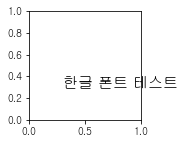

In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## Test
plt.figure(figsize=(2,2))
plt.text(0.3, 0.3, '한글 폰트 테스트', size=15)
plt.show() 

In [3]:
dat = pd.read_csv(r'C:/Users/cny13/OneDrive/바탕 화면/빅콘/segmentation용 데이터/segmentation.csv')  

C:\Users\cny13\anaconda3\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# dat = dat.rename(columns={'frequency':'frequency_apply'}) #오해 방지. 가입일수대비 얼마나 자주 신청서 냈냐는 변수임.
# dat = dat.rename(columns={'recency':'recency_apply'})

In [5]:
dat.personal_rehabilitation_yn.value_counts()

0.0            58574
no_response    22858
1.0              488
0.0              453
1.0                3
Name: personal_rehabilitation_yn, dtype: int64

In [6]:
dat['loanapply_insert_time'] = pd.to_datetime(dat['loanapply_insert_time'])
dat['insert_time'] = pd.to_datetime(dat['insert_time'])
dat['date'] = pd.to_datetime(dat['date'])
dat = dat.astype({'personal_rehabilitation_yn':'str'})

In [7]:
#bool 형변환
dat['is_holiday'] = dat['is_holiday'].astype('str')
dat['more_loan_desired'] = dat['more_loan_desired'].astype('str')
dat['loan_limit_outlier'] = dat['loan_limit_outlier'].astype('str')
dat['first_confirmed'] = dat['first_confirmed'].astype('str')

In [8]:
dat['isjob'] = np.where(dat['company_enter_month']==0,0,1)

In [9]:
unique_user = dat.copy()

# 1건이라도 신청한 유저와 신청안한 유저는 뭐가 다를까?

In [9]:
pd.set_option('display.max_columns',None)
unique_user.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,company_enter_year,age,Session_x,insert_time_month,insert_time_day,insert_time_hour,insert_time_weekday,insert_time_timezone,company_enter_month_year,company_enter_month_month,is_holiday,insert_time_diff,application_id_cnt,diff_amount,more_loan_desired,loan_limit_outlier,first_confirmed,bank_cumcnt,bank_popularity,product_cumcnt,product_popularity,bank_group,product_group,date,loanapply_insert_time_s,apply_cnt,mp_os,Session_y,how_long,visit_cumsum,visit_rate,frequency2,CompleteIDCertification_sum,EndLoanApply_sum,GetCreditInfo_sum,Login_sum,OpenApp_sum,StartLoanApply_sum,UseDSRCalc_sum,UseLoanManage_sum,UsePrepayCalc_sum,ViewLoanApplyIntro_sum,how_long_total,managing_service,frequency,recency,recency2,applied_user,isjob
0,584435,2022-03-01 00:15:40,55,186,25000000.0,10.6,0,334783,1984.0,male,2022-03-01 00:15:22,830.0,60000000.0,PRIVATEBUSINESS,201608.0,정규직,기타가족소유,100000000.0,BUSINESS,no_response,no_response,1.0,6.299001e+07,2016.0,39.0,1.0,3,1,0,1,dawn_not1,2016,8,True,18.0,11,75000000.0,False,False,False,7,0.000000,2,0.000000,5,6,2022-03-01,87340,2,Android,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,91,92,1,1
1,1449958,2022-03-01 00:17:06,27,148,11000000.0,7.5,1,661317,1994.0,female,2022-03-01 00:17:06,200.0,30000000.0,EARNEDINCOME2,202104.0,정규직,기타가족소유,1000000.0,LIVING,no_response,no_response,1.0,2.000000e+07,2021.0,29.0,1.0,3,1,0,1,dawn_not1,2021,4,True,0.0,1,-10000000.0,True,False,True,10,0.200000,4,0.250000,2,2,2022-03-01,87426,1,unknown,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,91,92,1,1
2,505245,2022-03-01 01:31:19,38,16,3000000.0,5.8,0,720040,1978.0,male,2022-03-01 01:30:37,730.0,65000000.0,EARNEDINCOME,201508.0,정규직,자가,100000000.0,LIVING,no_response,no_response,7.0,1.800000e+08,2015.0,45.0,0.0,3,1,1,1,early morning_w1,2015,8,True,42.0,33,97000000.0,False,False,False,135,0.074074,30,0.000000,5,7,2022-03-01,91879,0,unknown,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,91,92,0,1
3,149229,2022-03-01 01:31:38,23,108,36000000.0,12.6,0,835507,1994.0,male,2022-03-01 01:30:52,770.0,24000000.0,EARNEDINCOME,202101.0,정규직,전월세,8000000.0,LIVING,no_response,no_response,1.0,8.000000e+06,2021.0,29.0,1.0,3,1,1,1,early morning_w1,2021,1,True,46.0,52,-28000000.0,True,False,False,13,0.000000,7,0.000000,5,7,2022-03-01,91898,2,Android,2.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0,2.0,91,92,1,1
4,1104187,2022-03-01 04:12:26,47,138,30000000.0,15.6,1,485721,1978.0,female,2022-03-01 04:12:19,650.0,30000000.0,EARNEDINCOME,201805.0,정규직,전월세,20000000.0,LIVING,no_response,no_response,3.0,3.300000e+07,2018.0,45.0,1.0,3,1,4,1,dawn_not1,2018,5,True,7.0,5,-10000000.0,True,False,False,124,0.080645,60,0.033333,5,7,2022-03-01,101546,1,Android,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,91,92,1,1


<AxesSubplot:xlabel='applied_user', ylabel='count'>

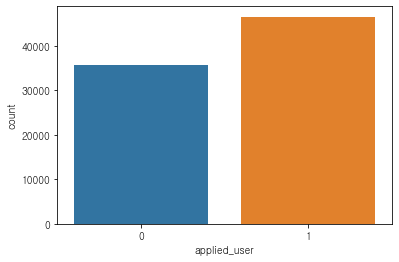

In [10]:
sns.countplot(x='applied_user',data=unique_user) #1건이라도 신청한 유저가 더 많다.

In [19]:
unique_user.groupby(['applied_user']).size()/unique_user.shape[0]

applied_user
0    0.434338
1    0.565662
dtype: float64

In [20]:
#범주형 변수들
cat_cols = ['bank_id', 'product_id', 'gender', 'income_type',
       'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn','isjob','gender','mp_os','is_holiday',
        'more_loan_desired', 'loan_limit_outlier','insert_time_timezone']
#연속형 변수들
num_cols = ['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate',
        'birth_year', 'credit_score', 'yearly_income',
       'company_enter_month', 'desired_amount', 'existing_loan_cnt',
       'existing_loan_amt', 'company_enter_year', 'age',
       'insert_time_month', 'insert_time_day', 'insert_time_hour',
       'insert_time_weekday', 'company_enter_month_year',
       'company_enter_month_month', 'application_id_cnt',
       'diff_amount', 'bank_popularity', 
       'product_popularity', 'bank_group', 'product_group',
        'apply_cnt', 'how_long',
       'visit_rate', 'frequency2',
       'CompleteIDCertification_sum', 'EndLoanApply_sum', 'GetCreditInfo_sum',
       'Login_sum', 'OpenApp_sum', 'StartLoanApply_sum', 'UseDSRCalc_sum',
       'UseLoanManage_sum', 'UsePrepayCalc_sum', 'ViewLoanApplyIntro_sum',
       'how_long_total', 'managing_service', 'frequency', 'recency',
       'recency2', 'applied_user', 'isjob']

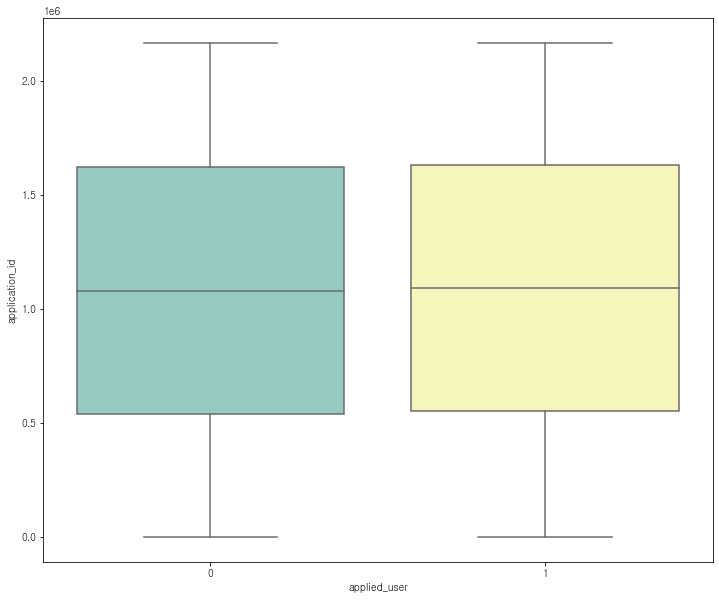

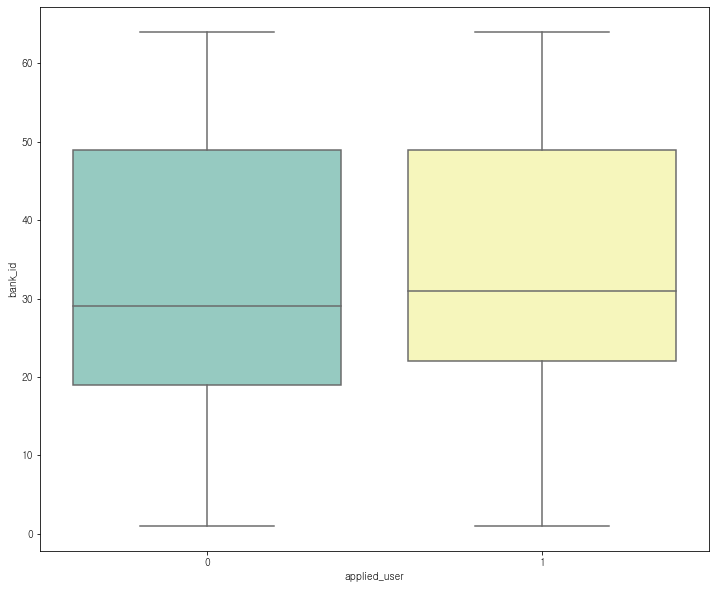

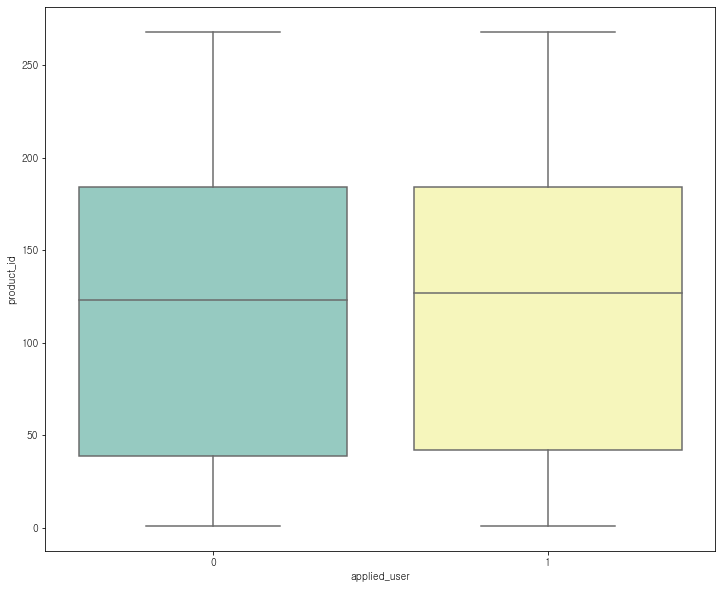

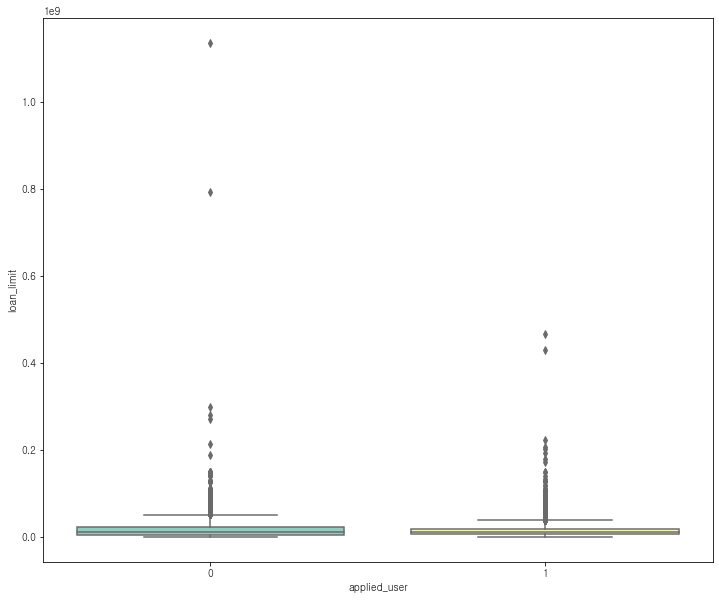

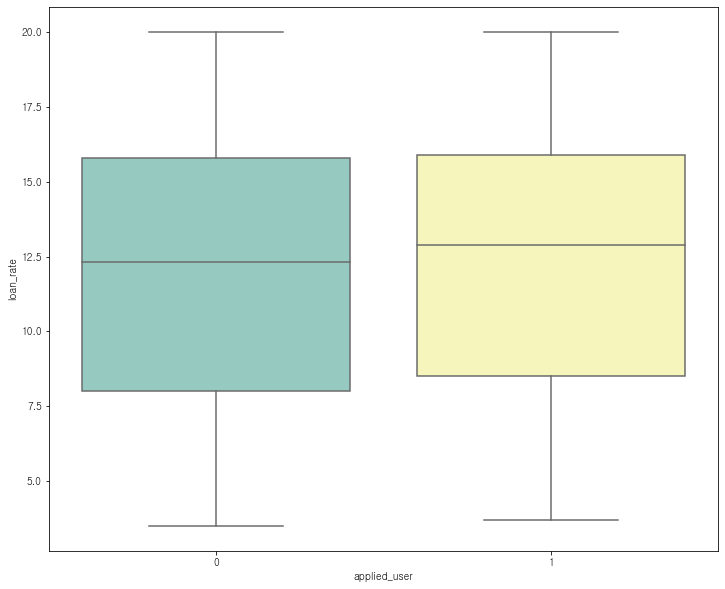

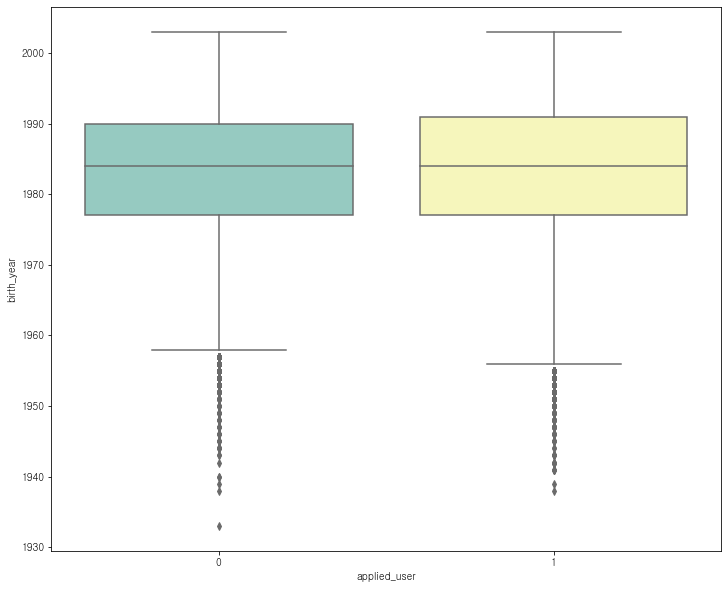

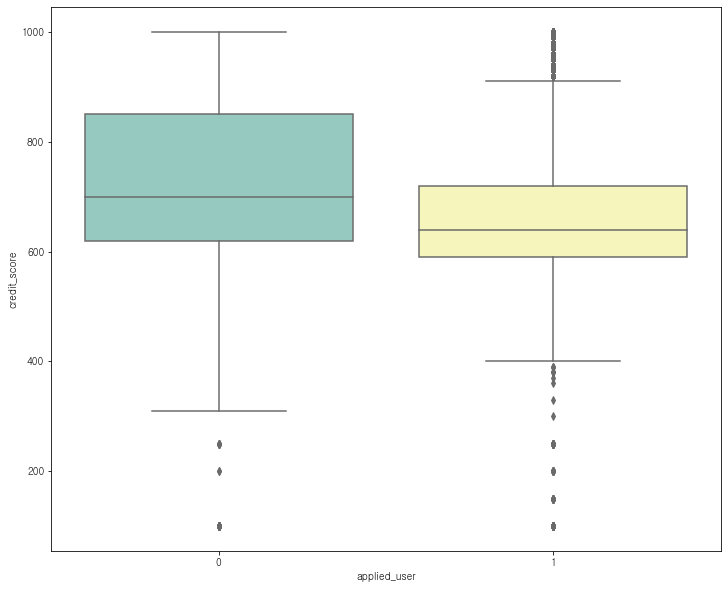

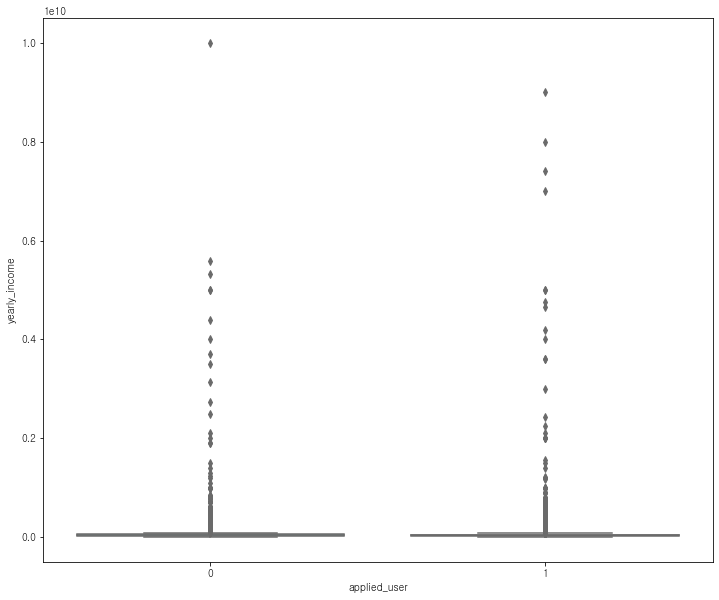

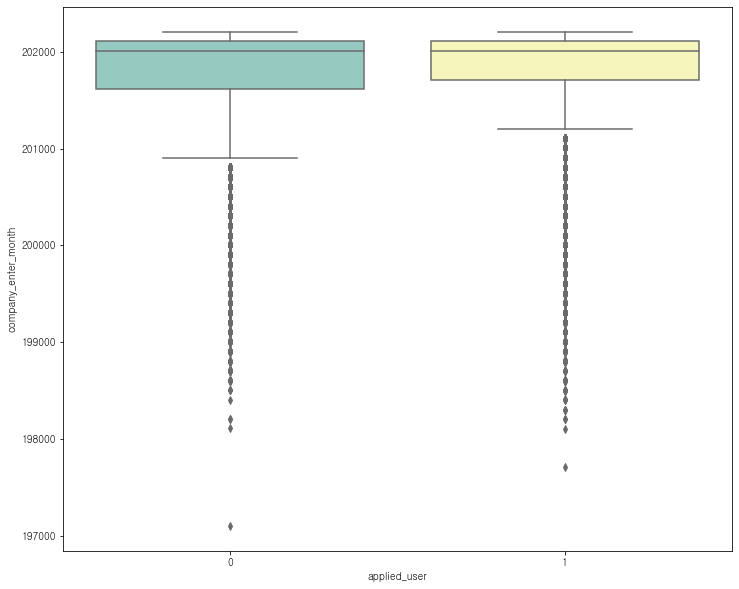

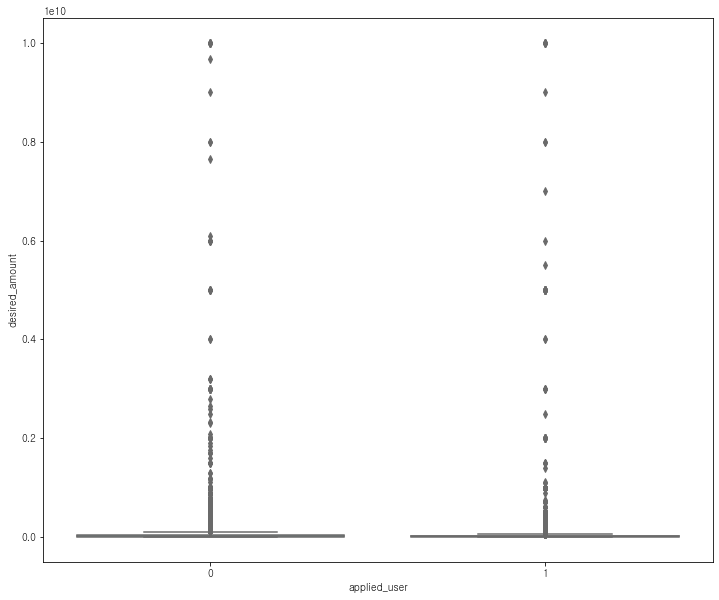

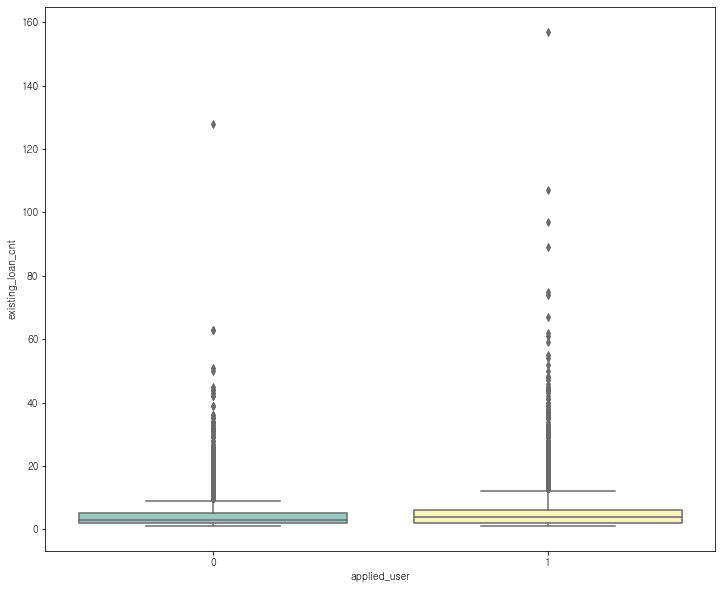

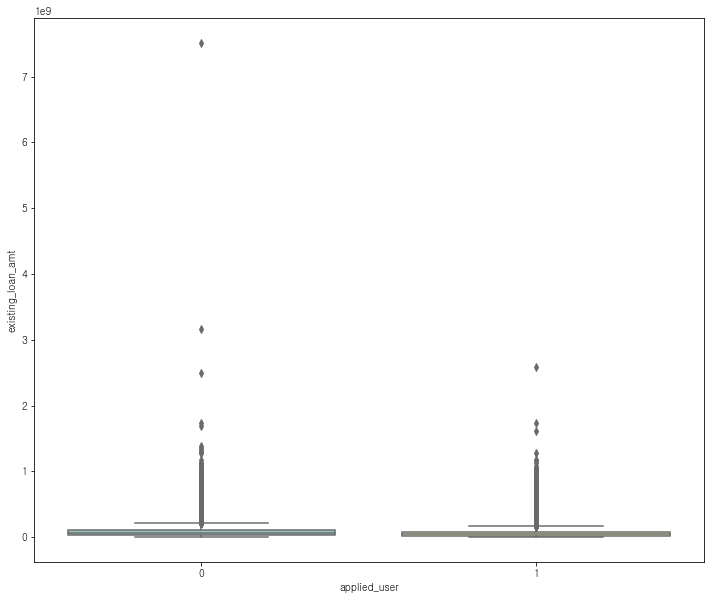

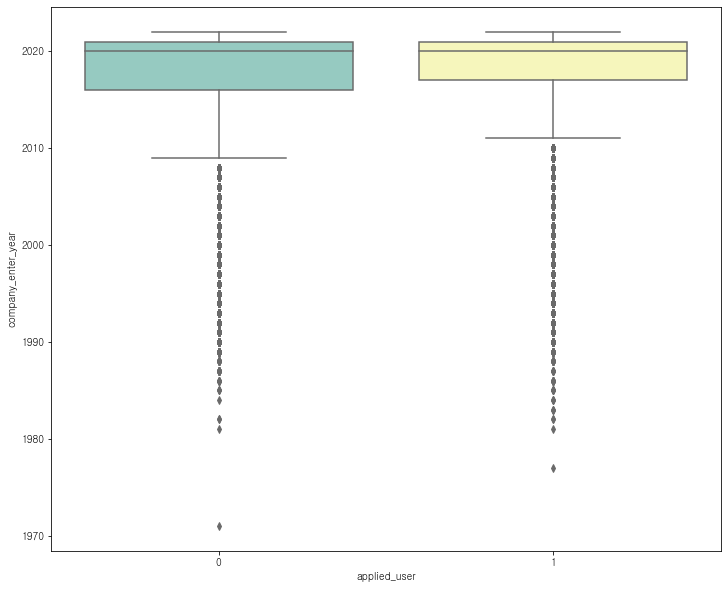

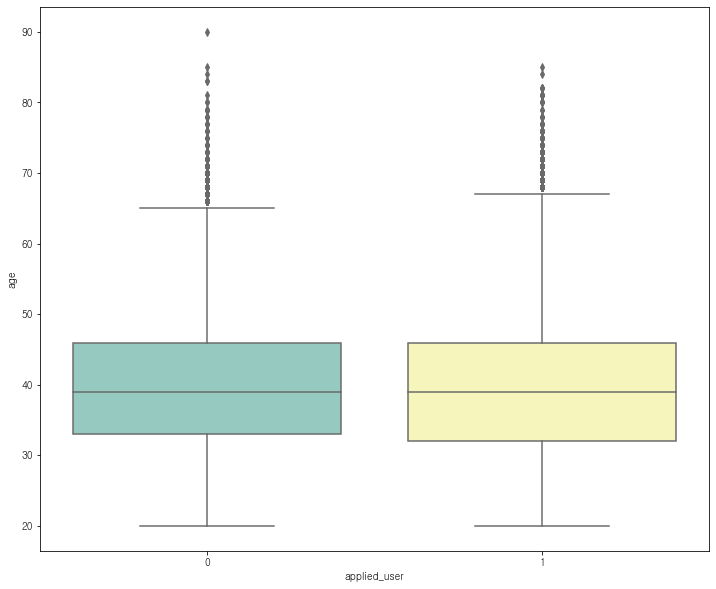

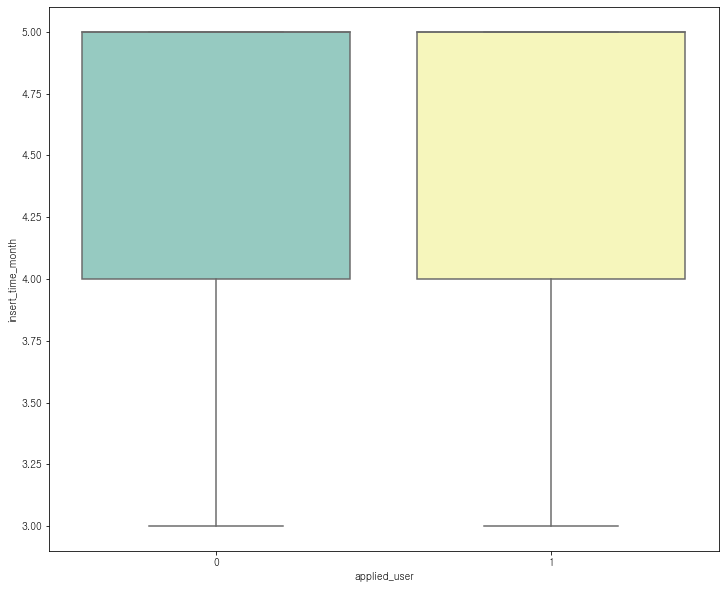

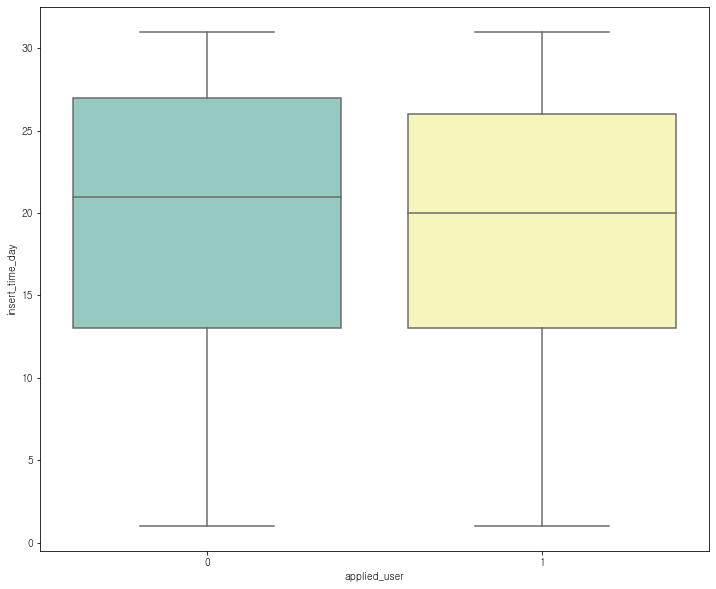

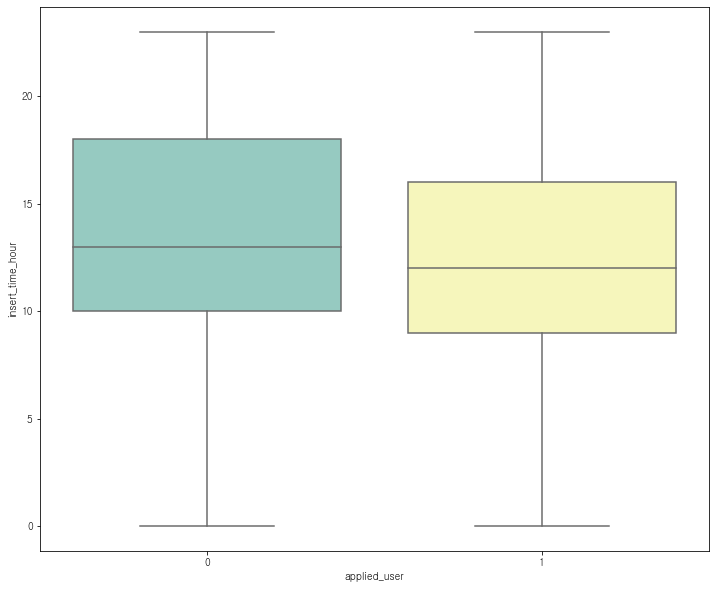

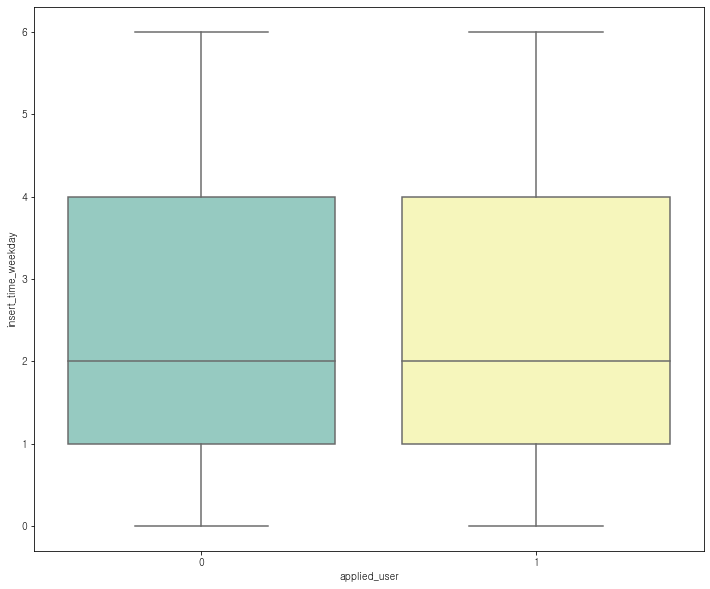

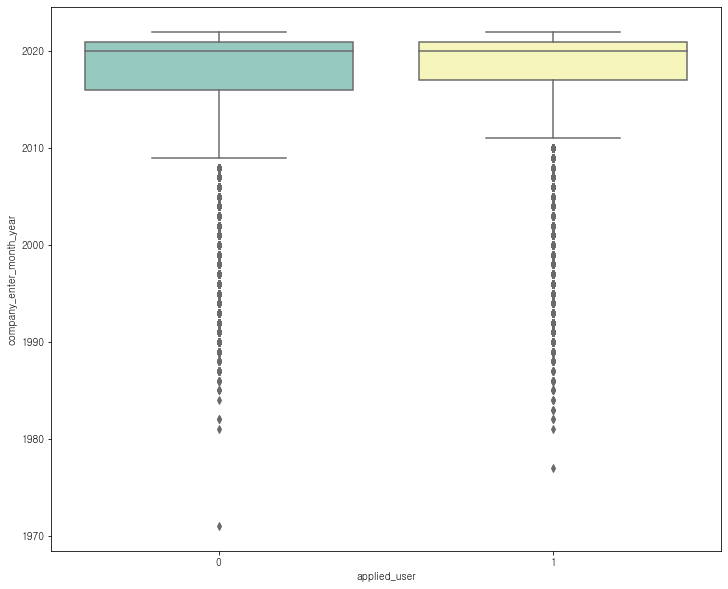

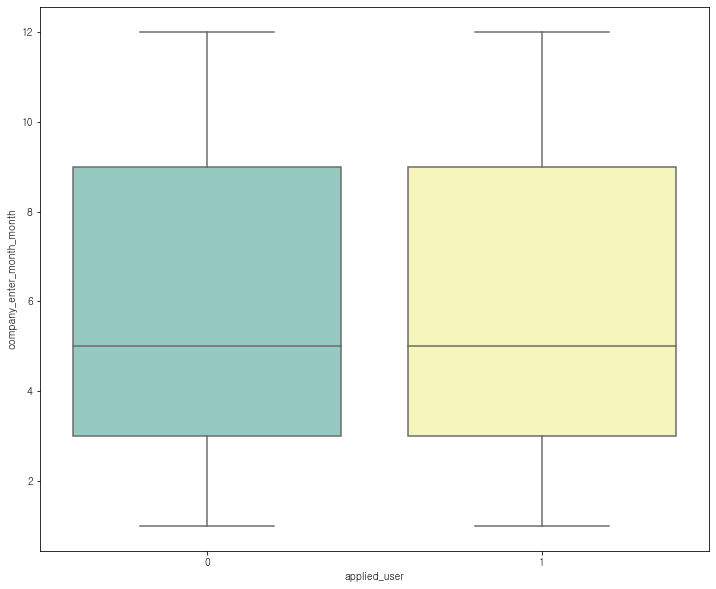

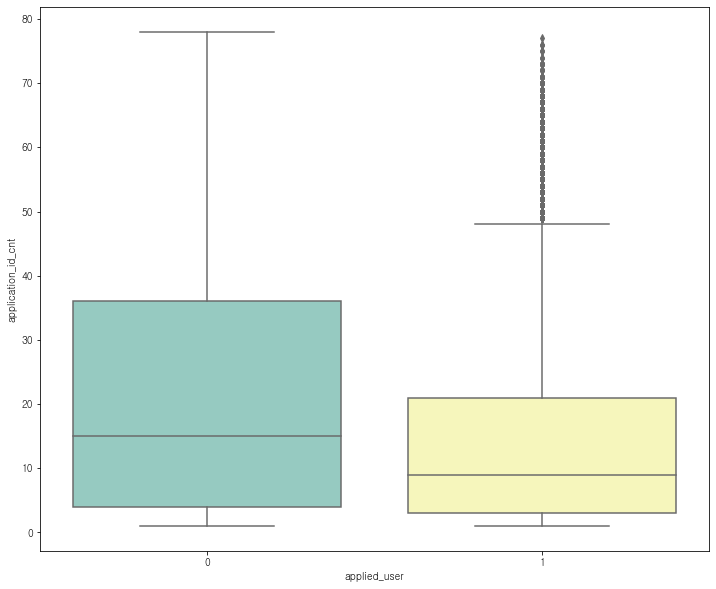

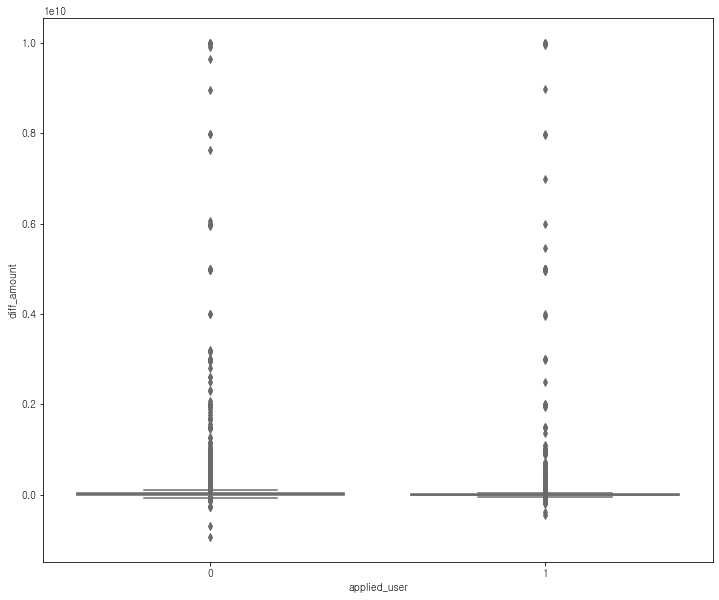

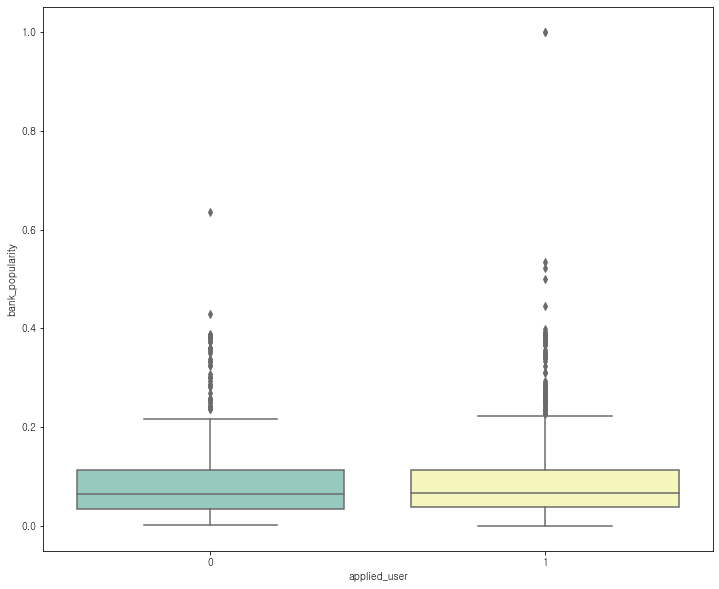

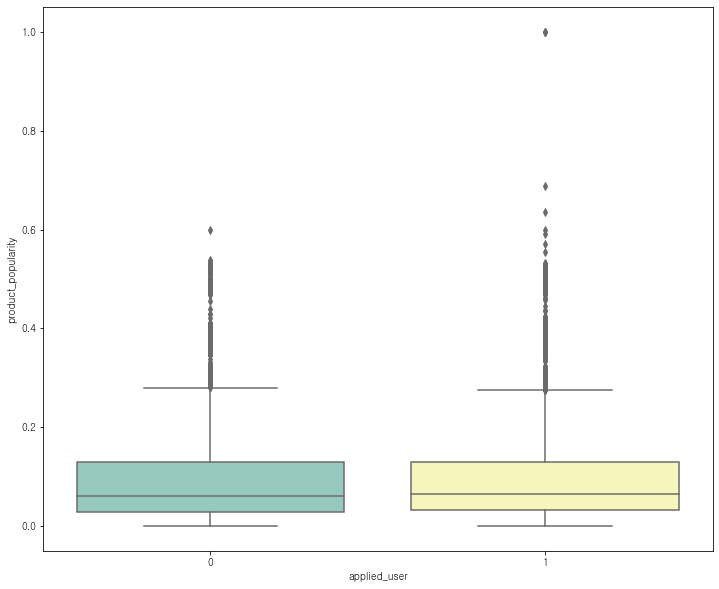

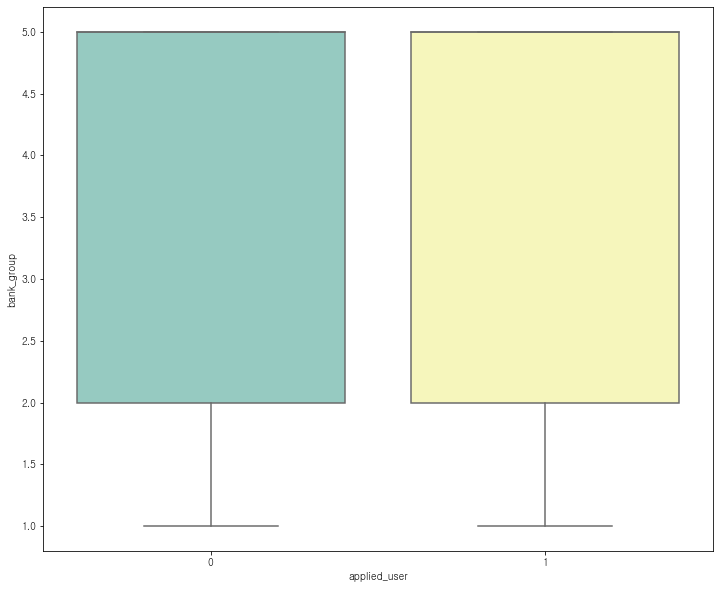

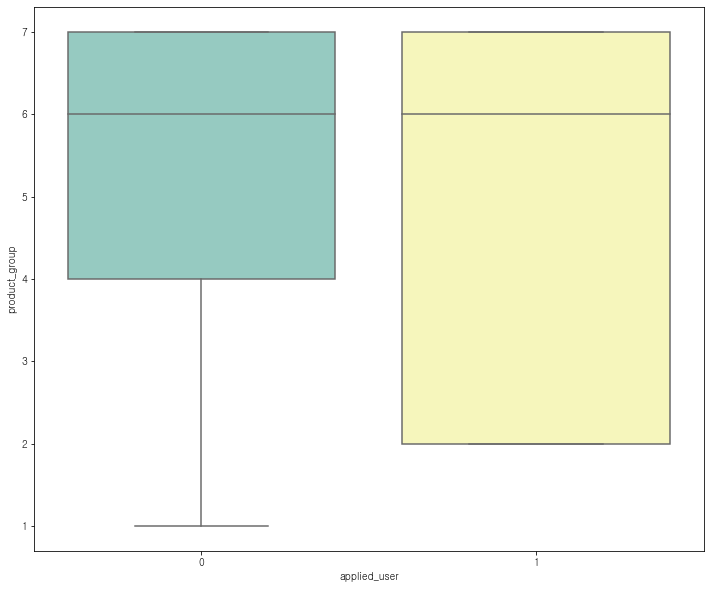

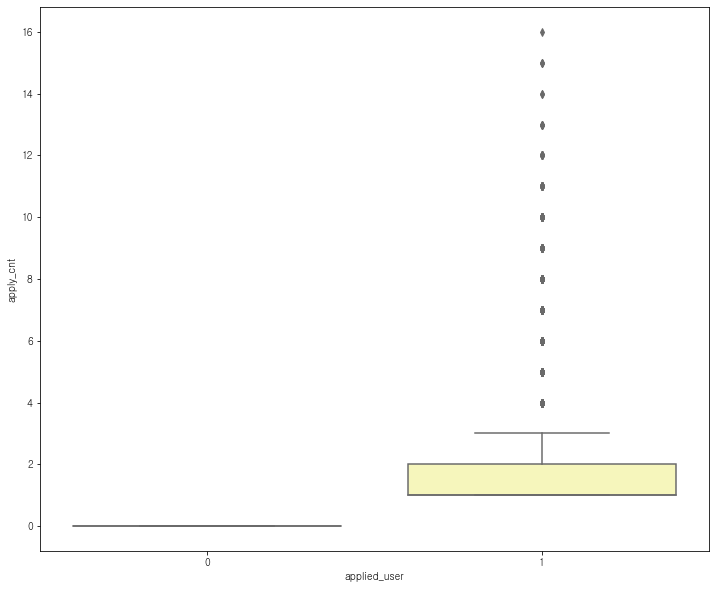

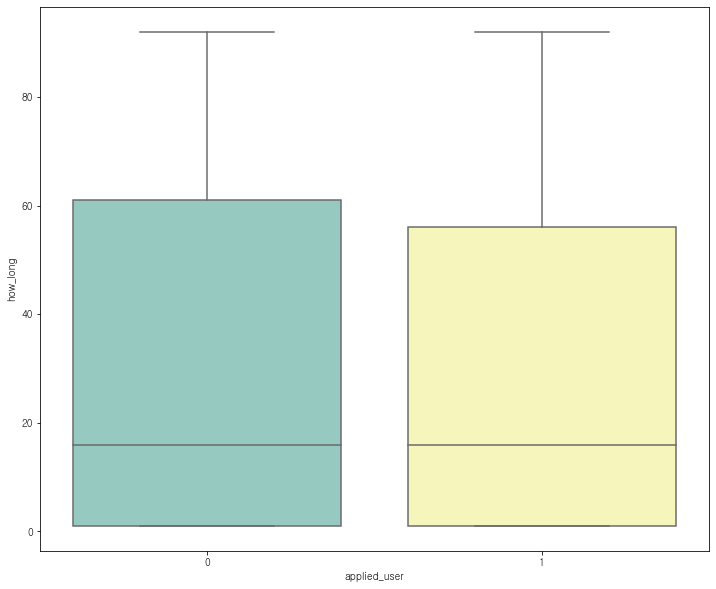

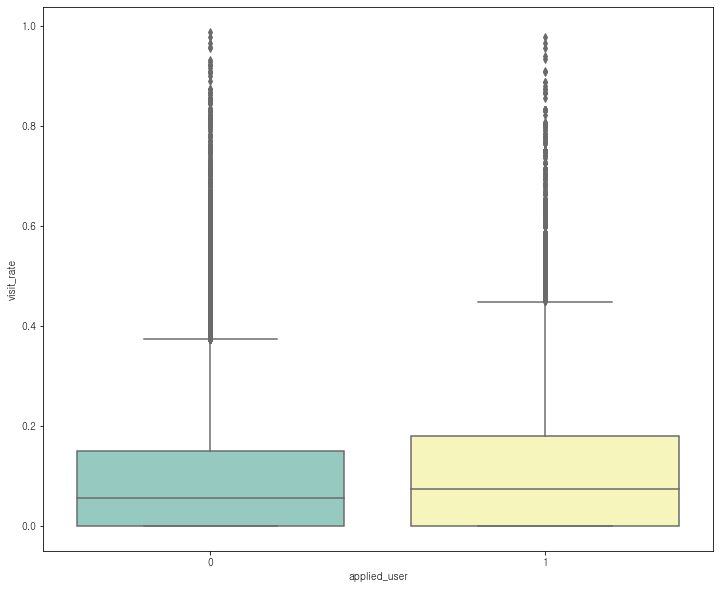

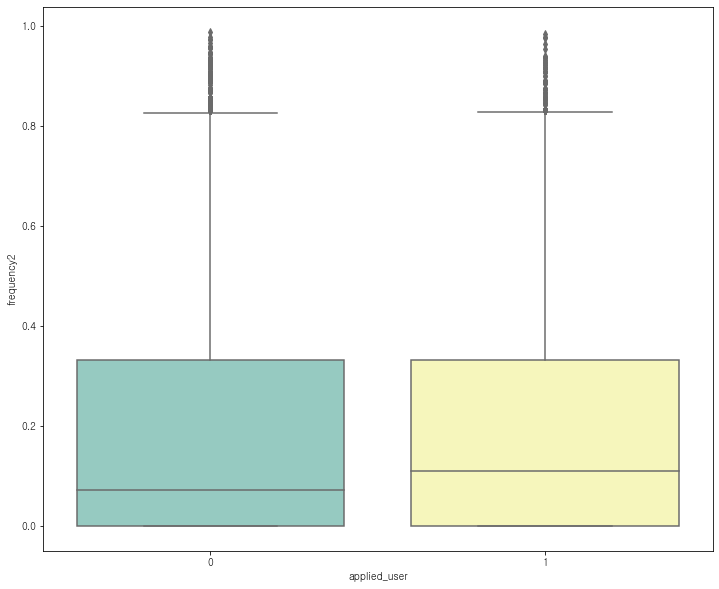

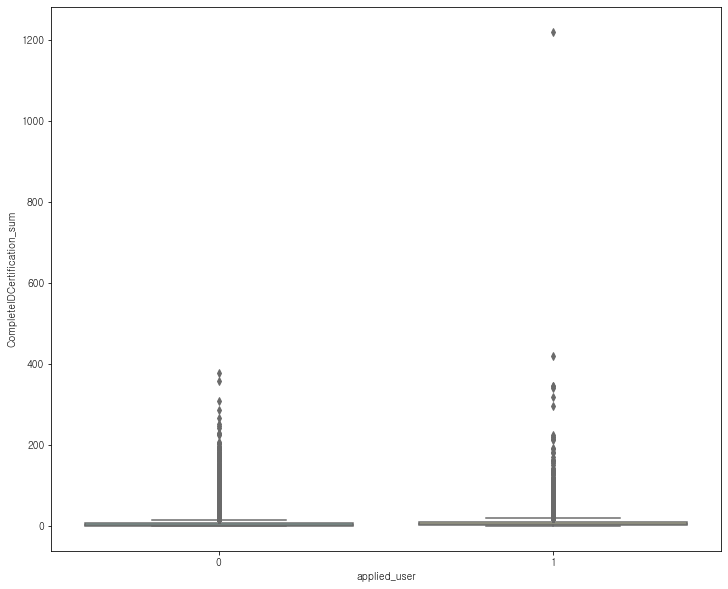

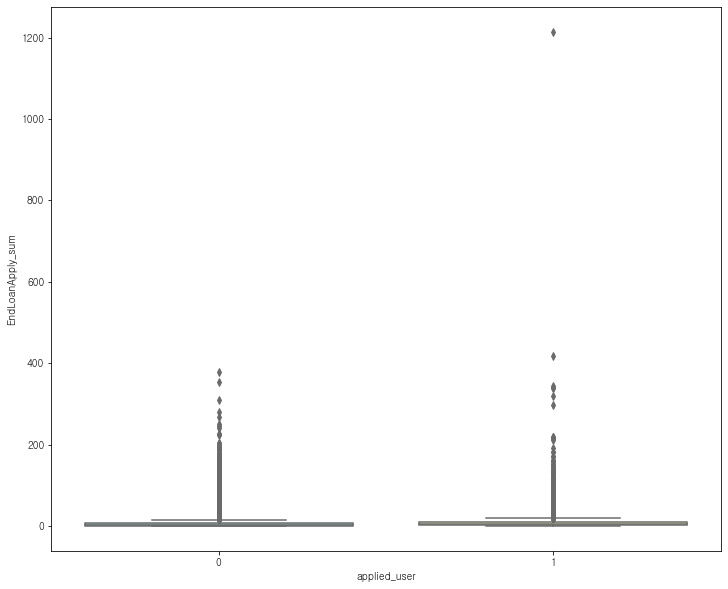

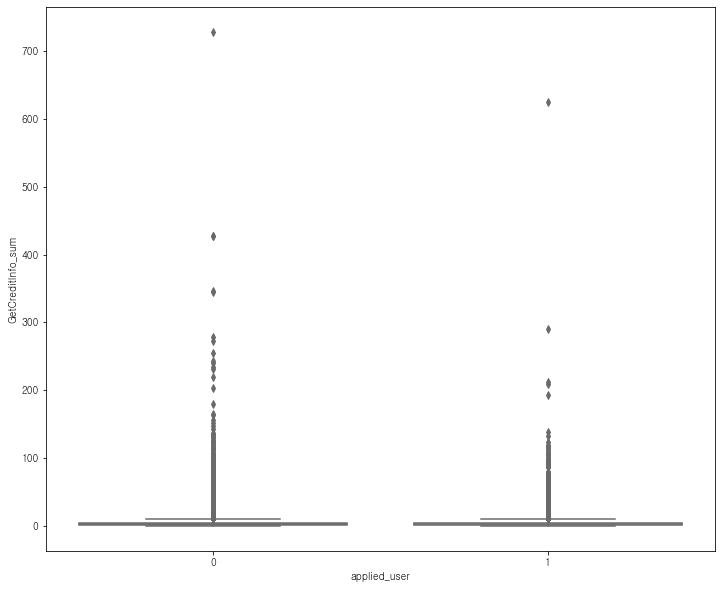

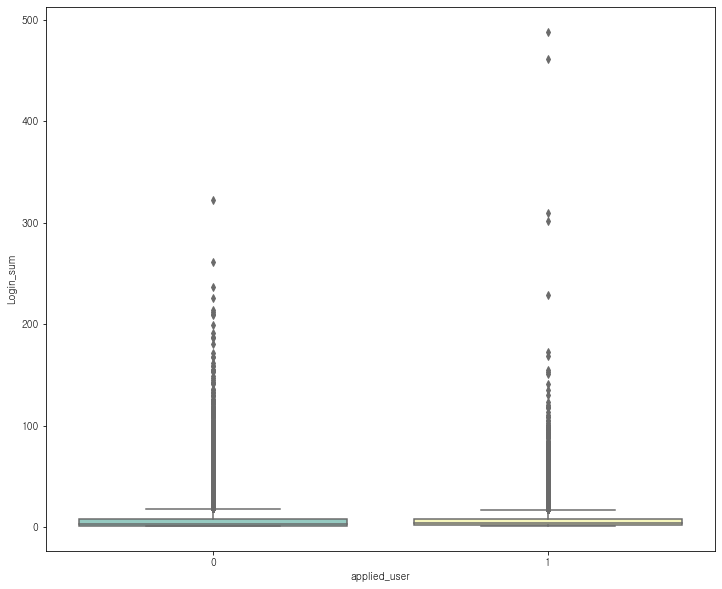

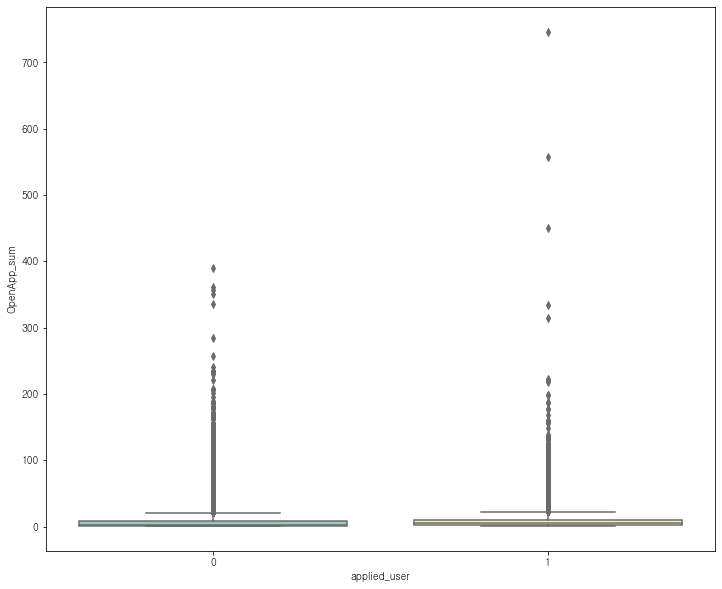

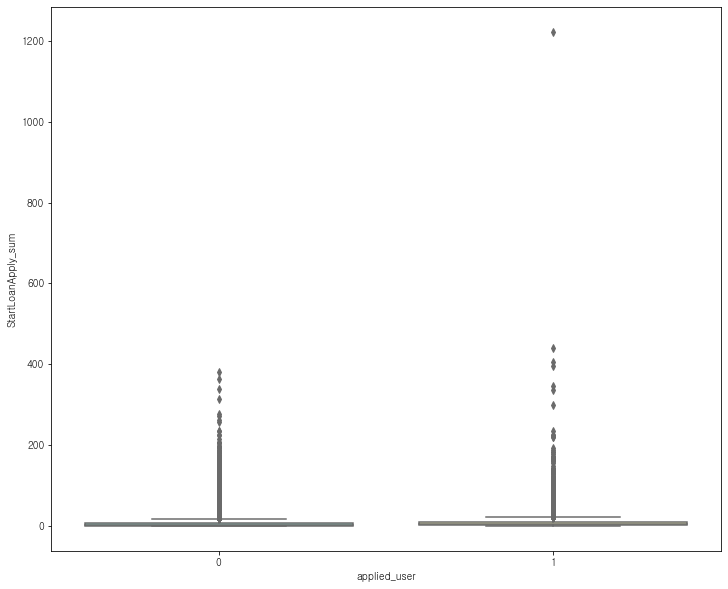

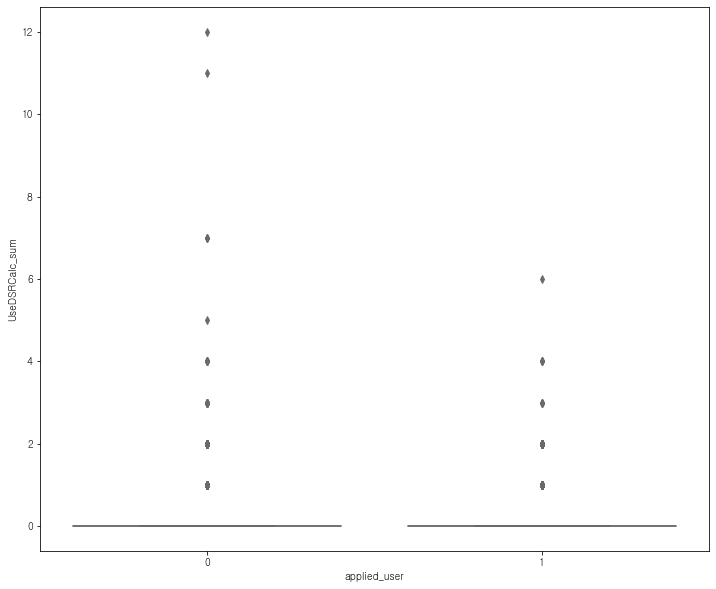

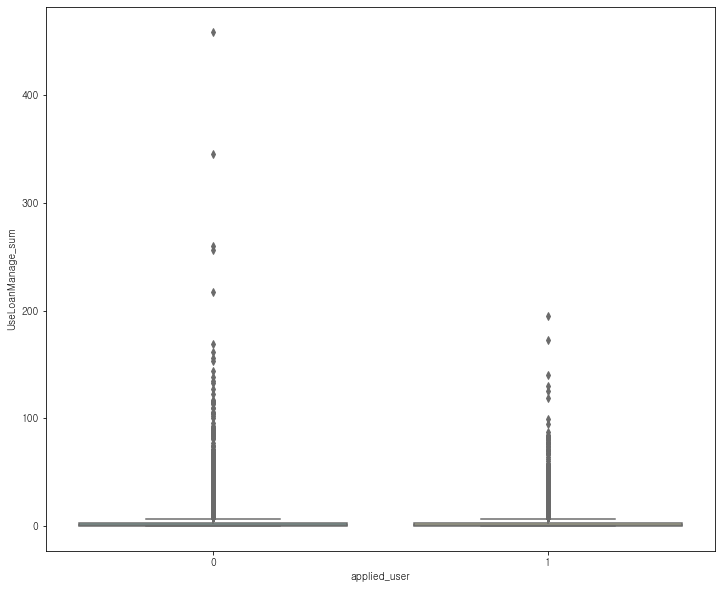

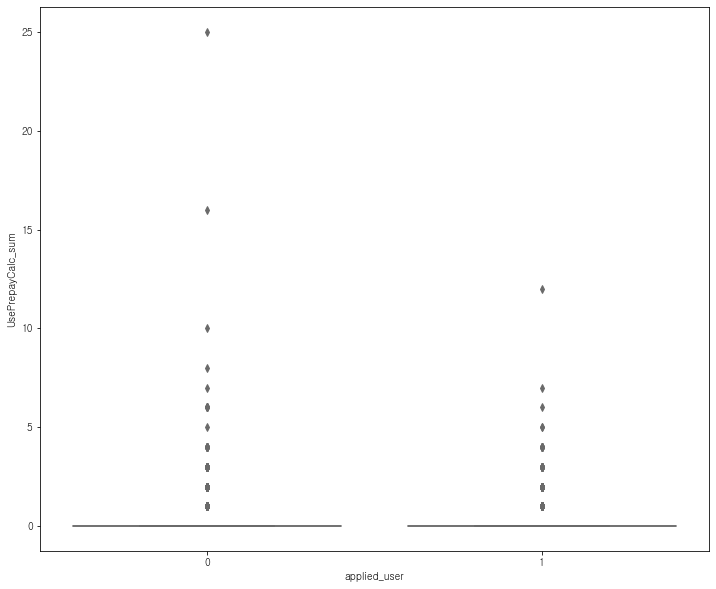

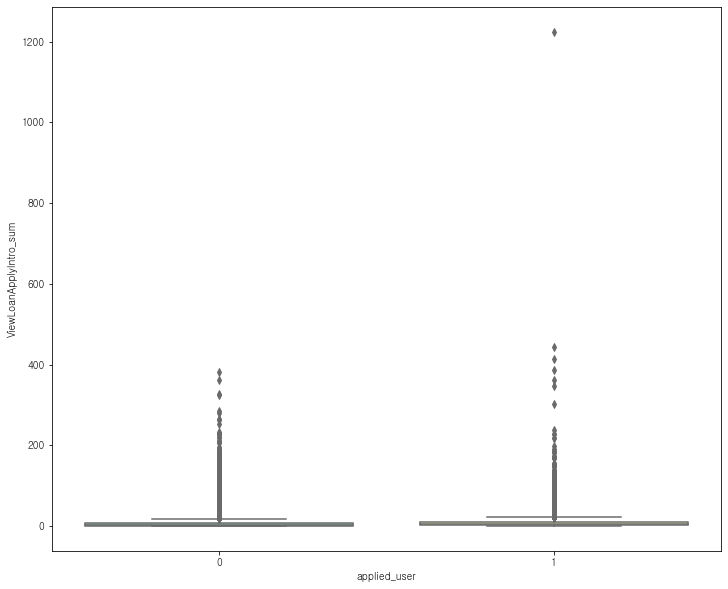

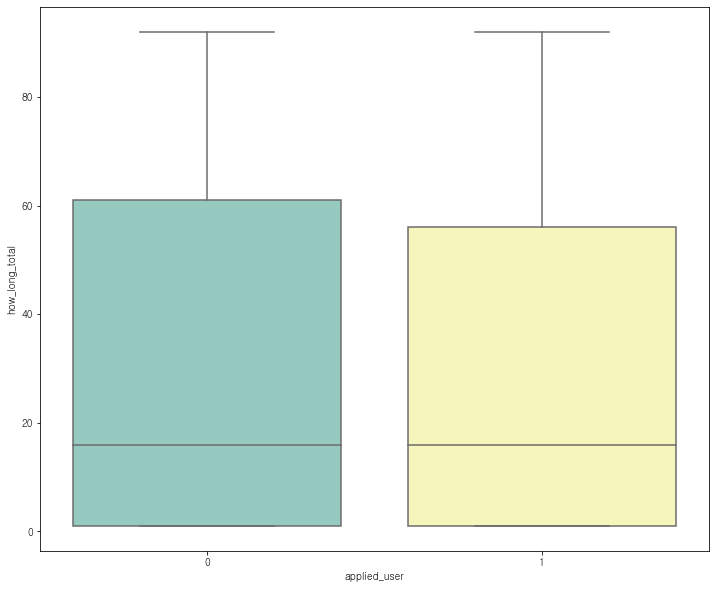

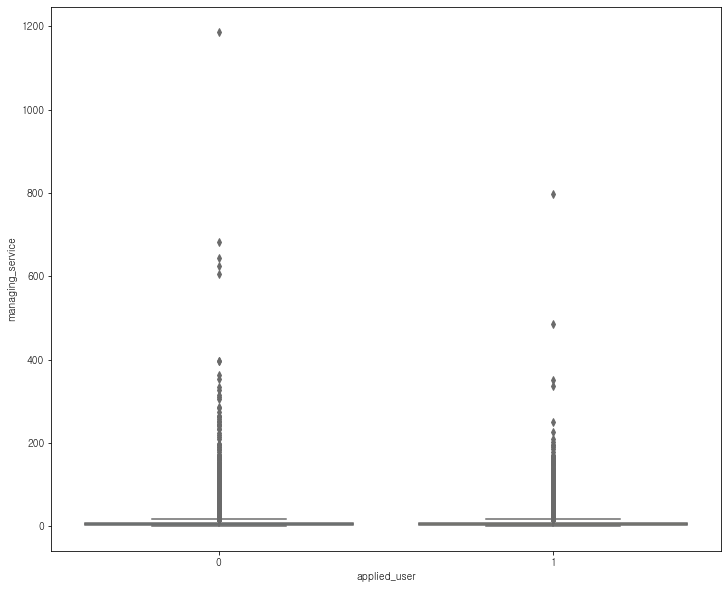

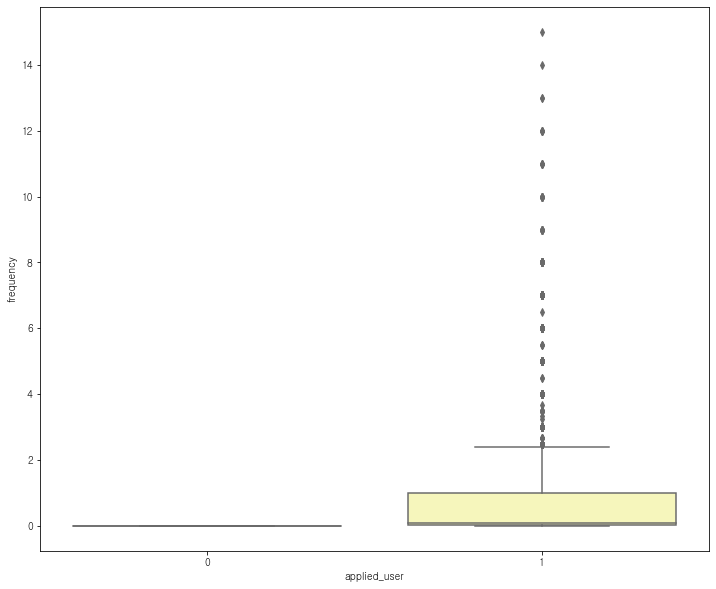

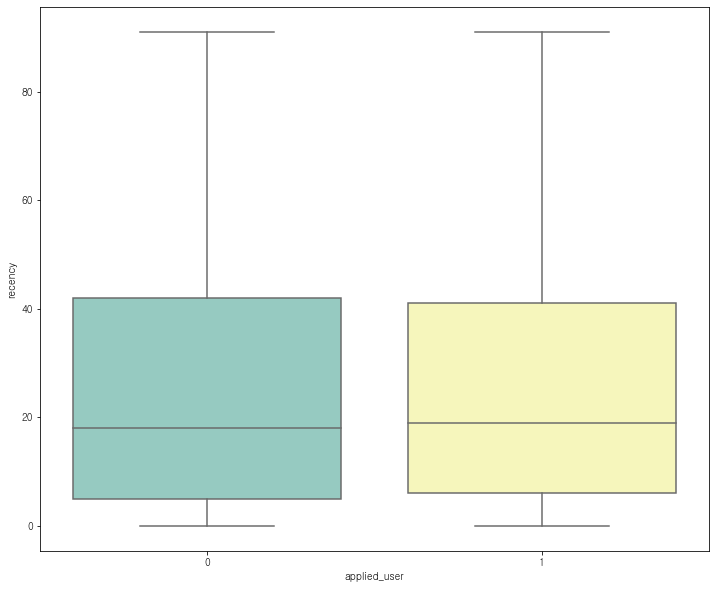

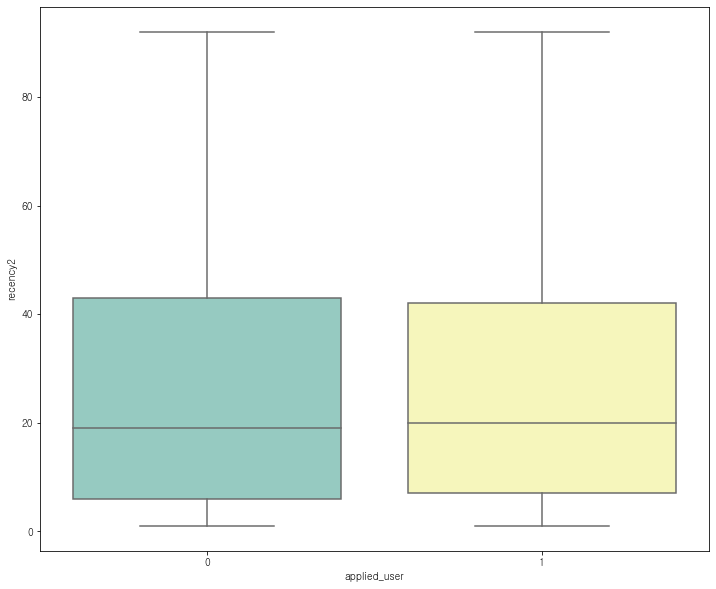

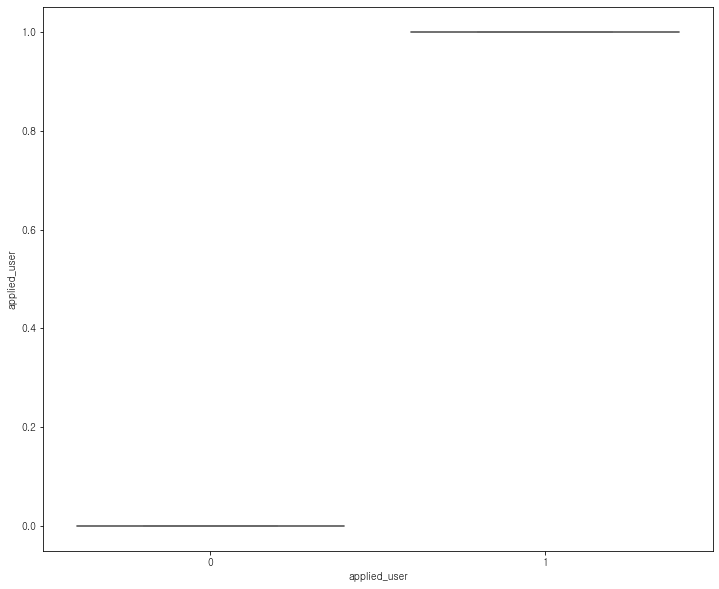

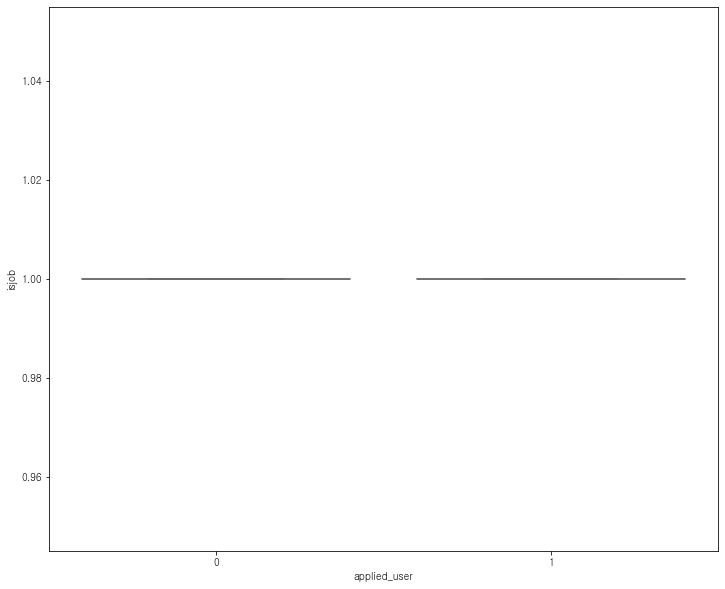

In [24]:
for col in num_cols:
    qualitative_colors = sns.color_palette("Set3", 16)
    sns.set_palette(qualitative_colors)
    plt.figure(figsize=(12,10))
    sns.boxplot(data=unique_user, y=col, x='applied_user')
    plt.show();

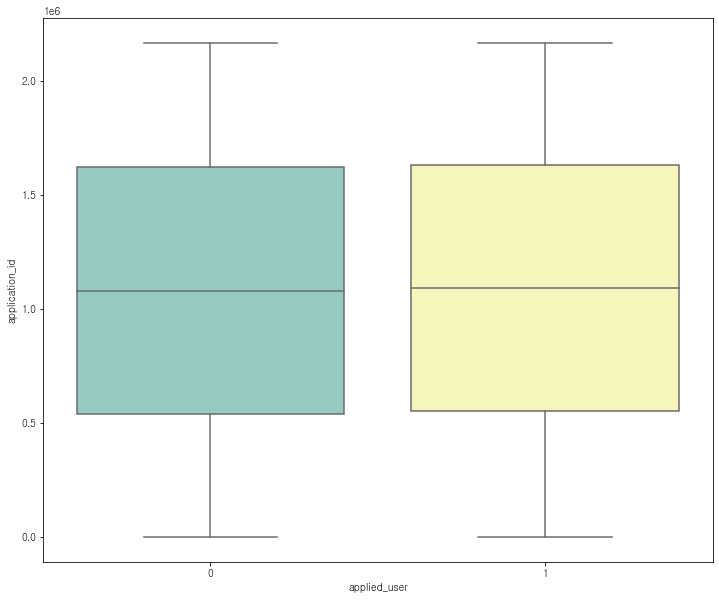

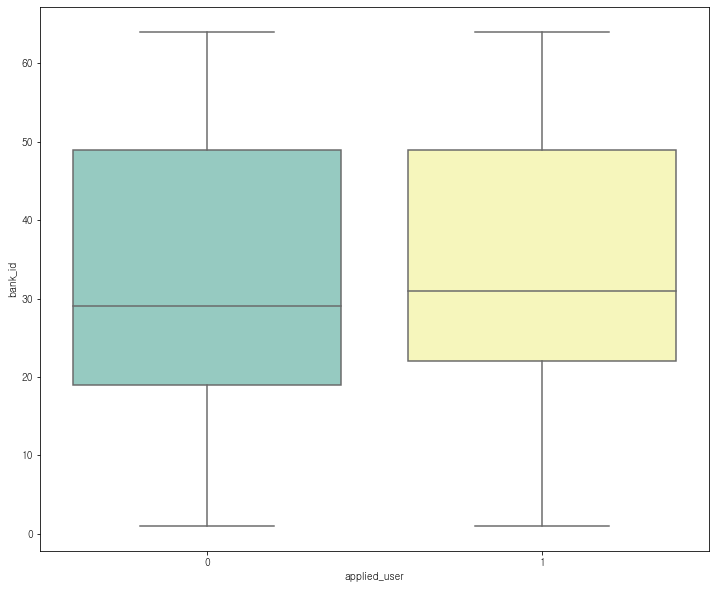

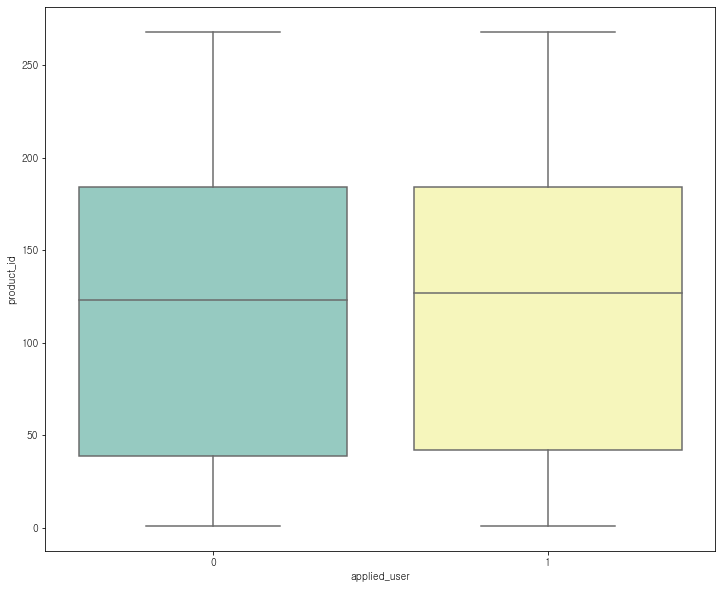

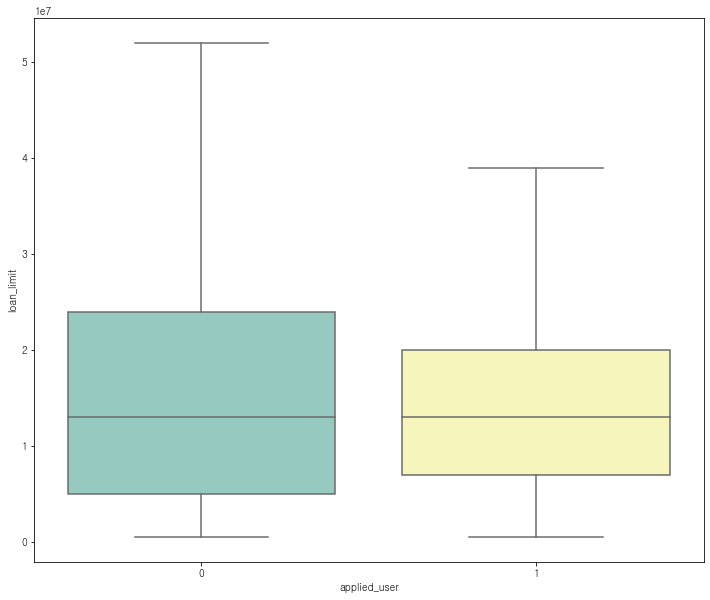

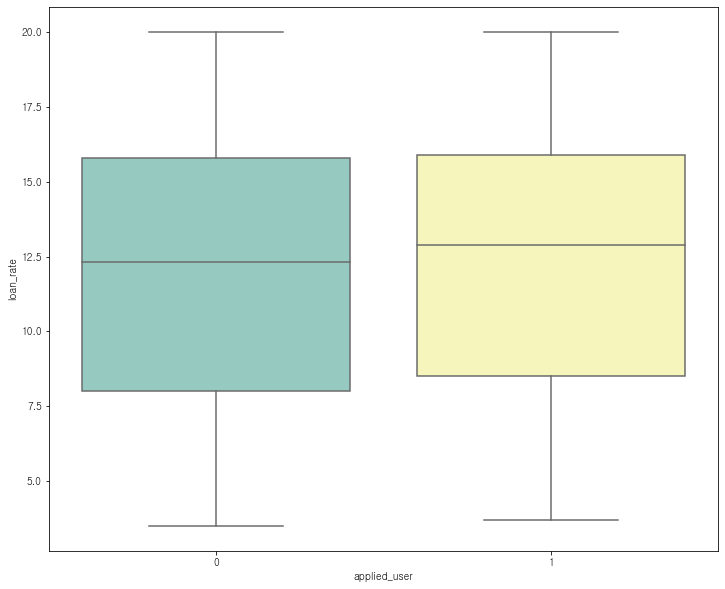

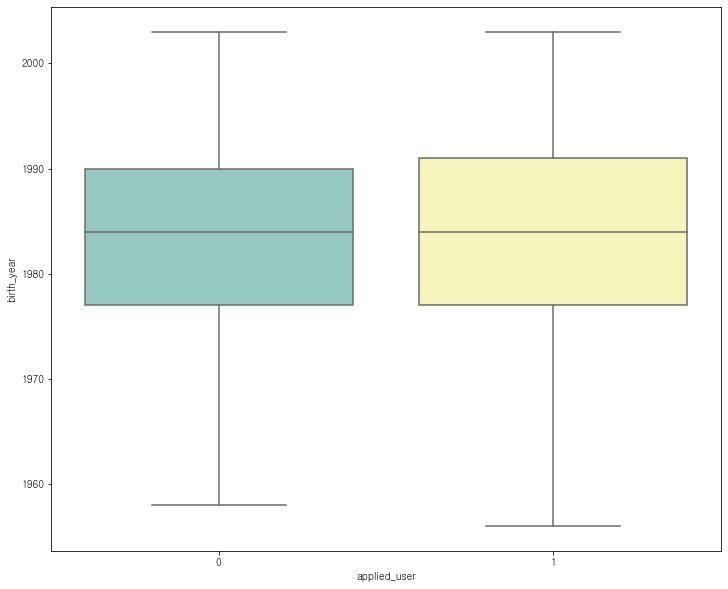

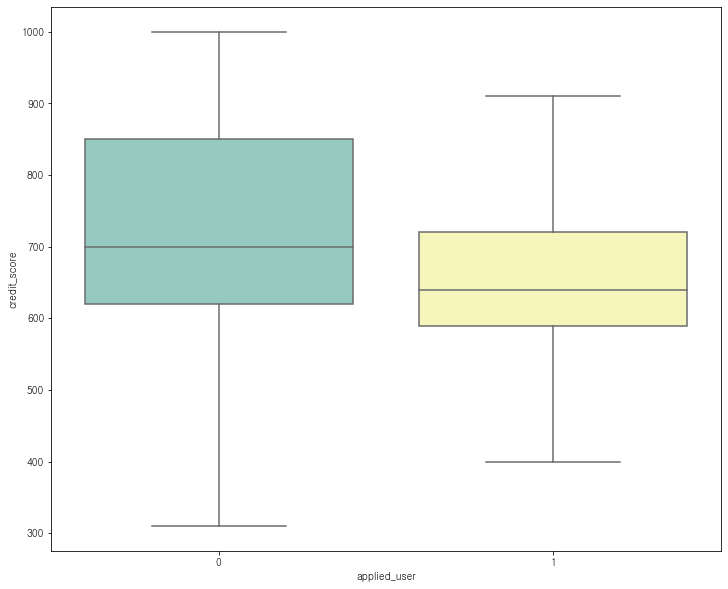

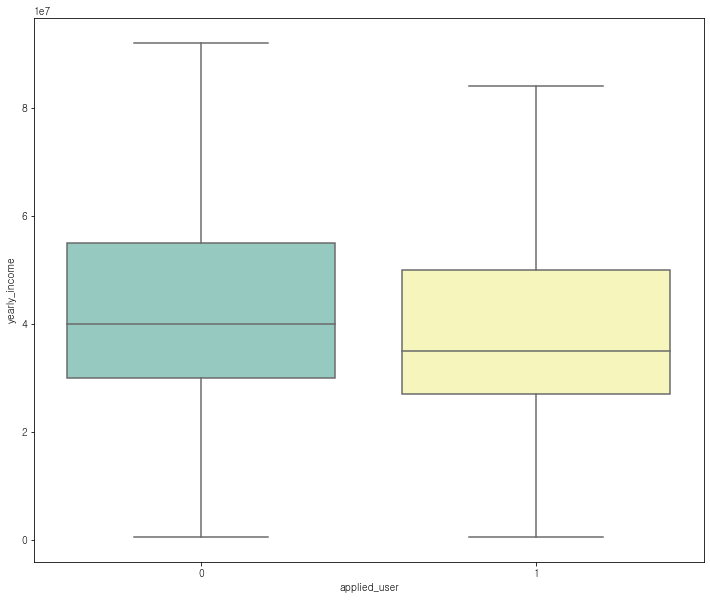

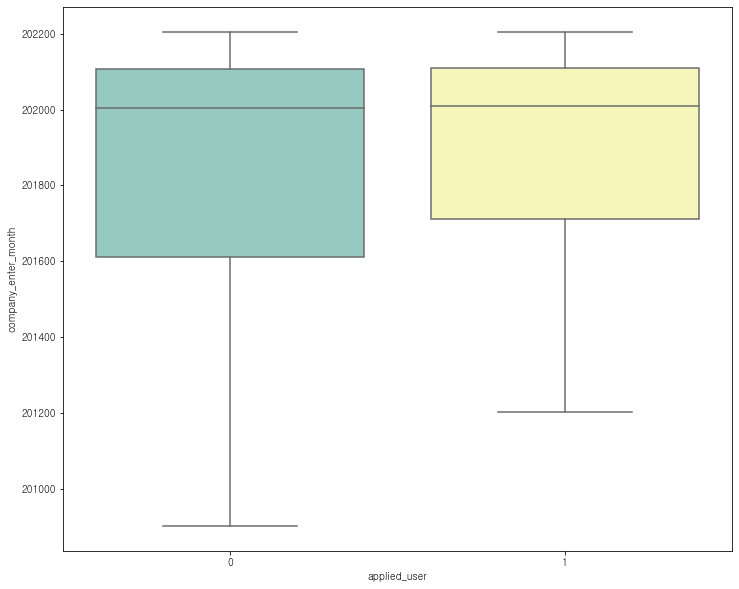

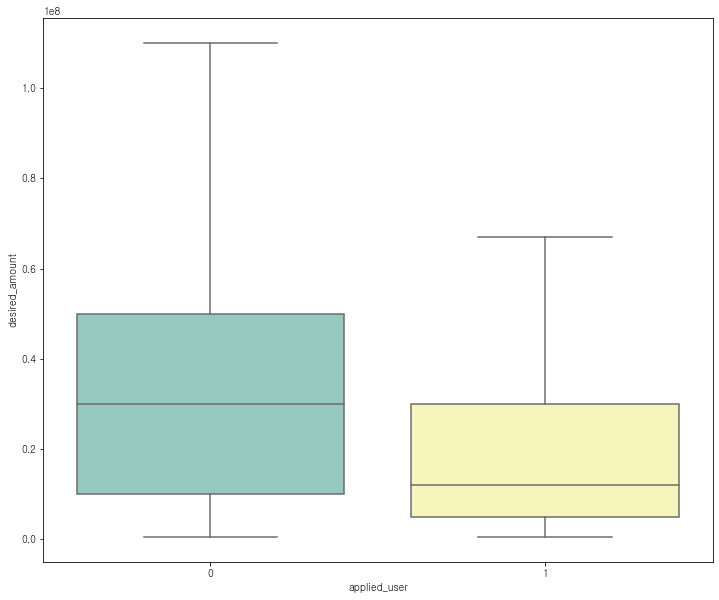

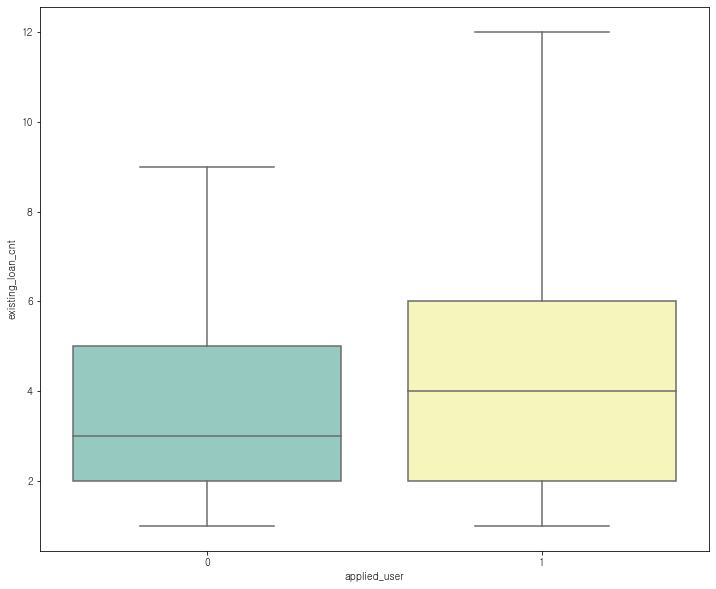

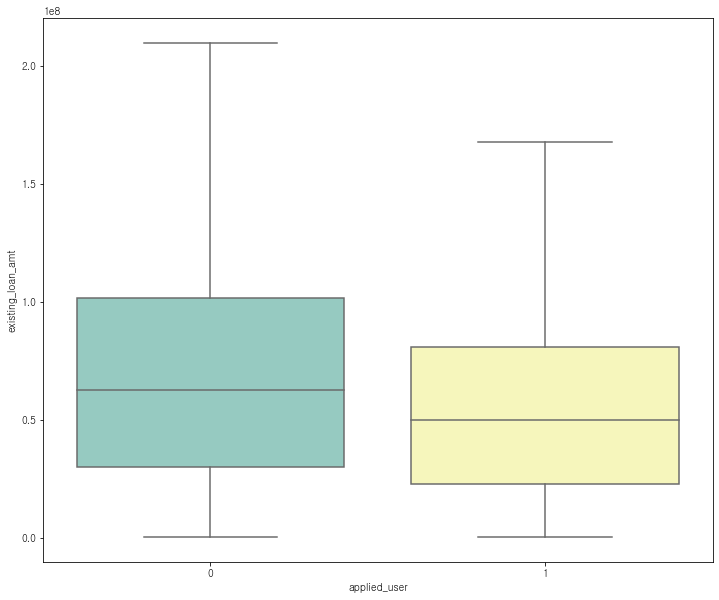

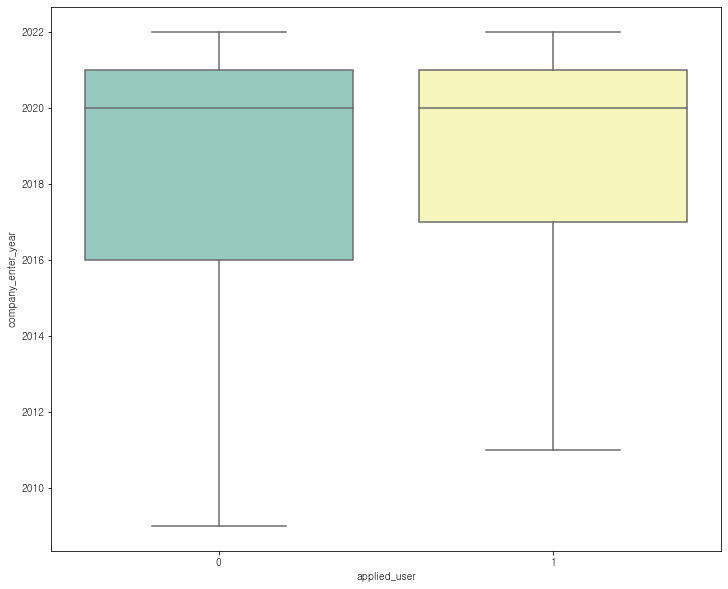

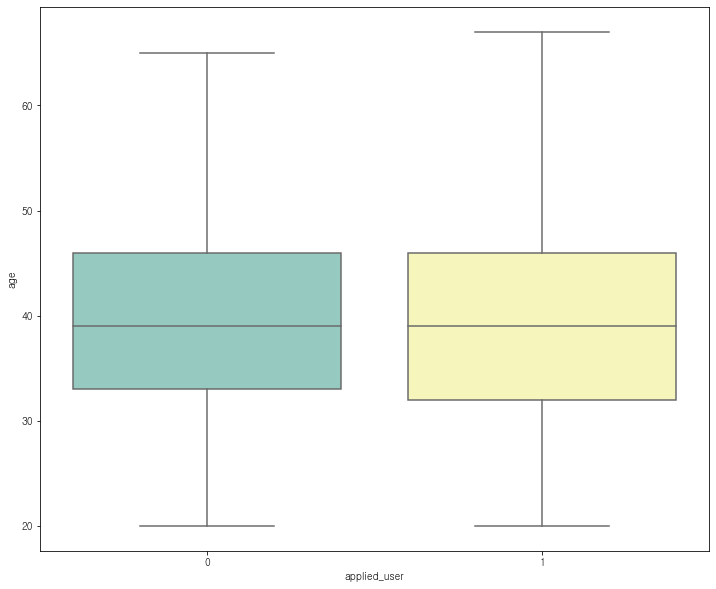

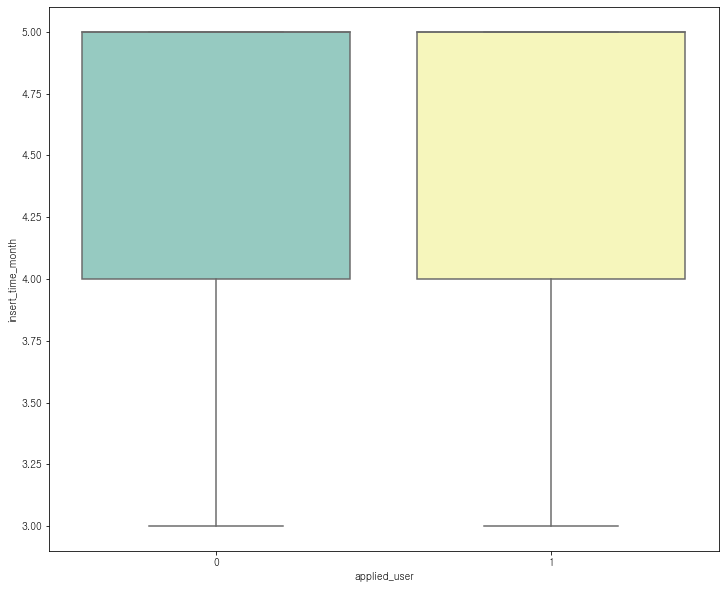

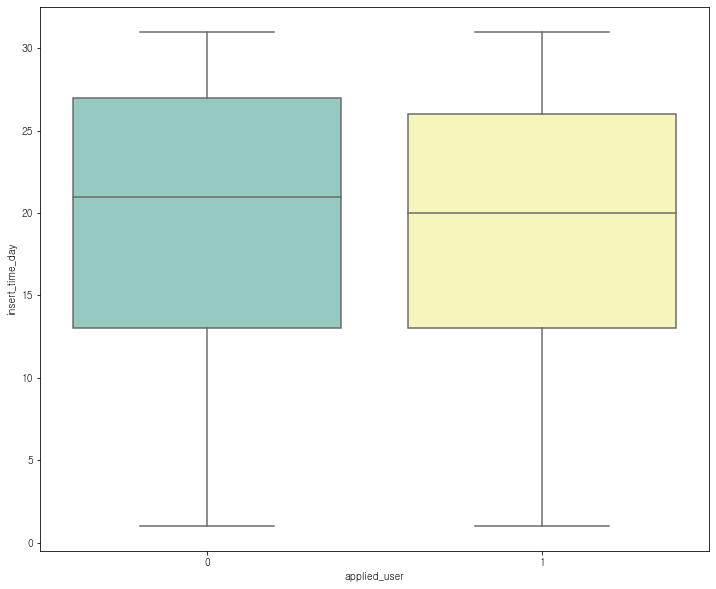

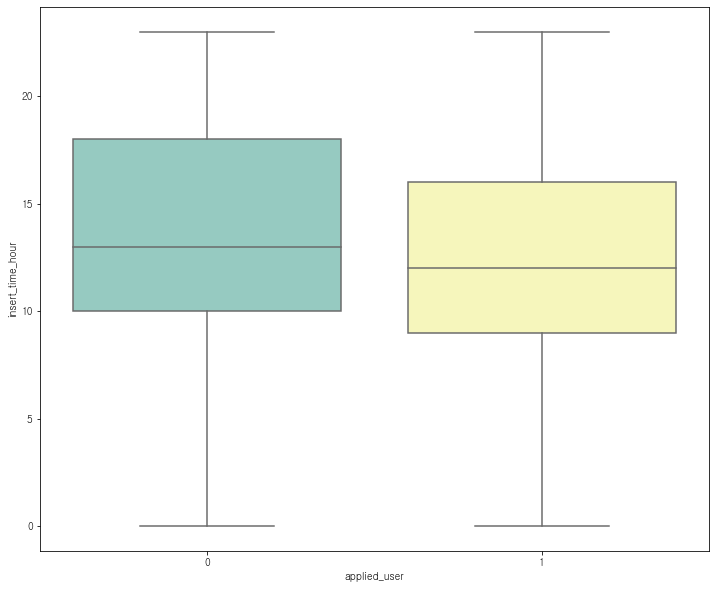

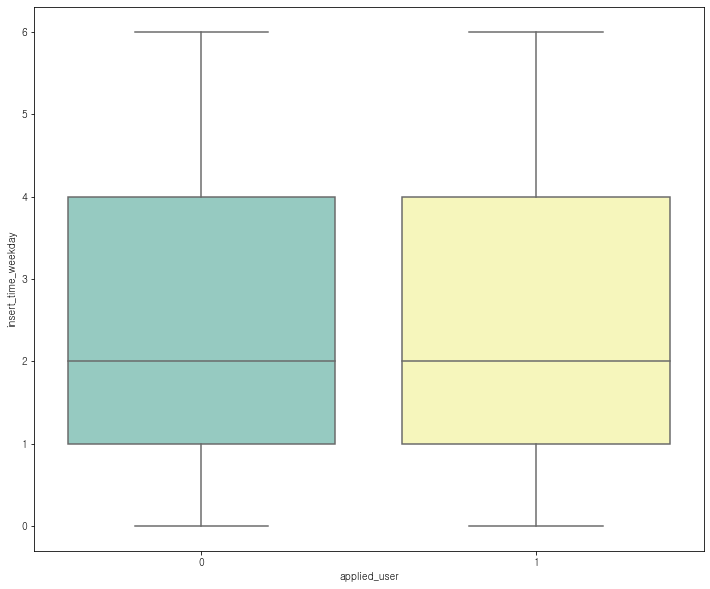

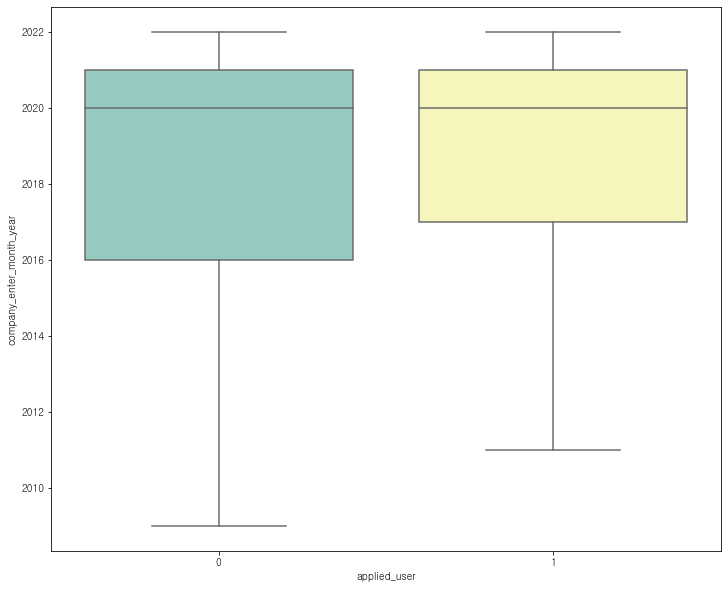

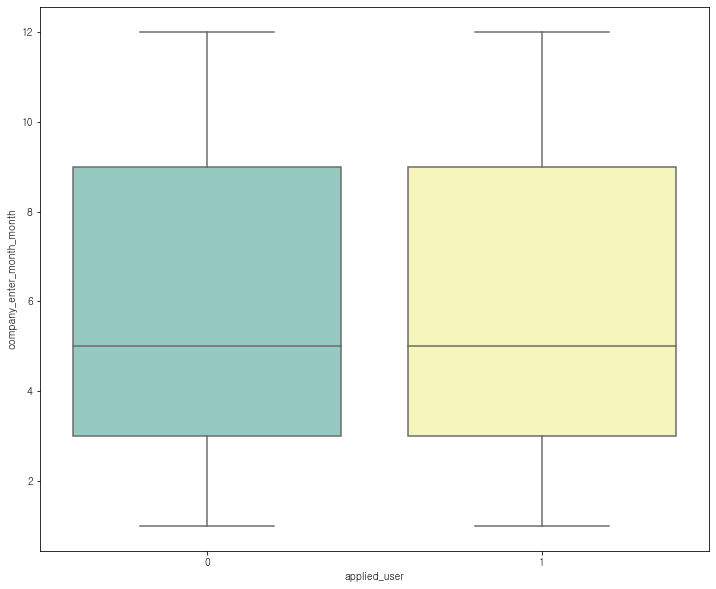

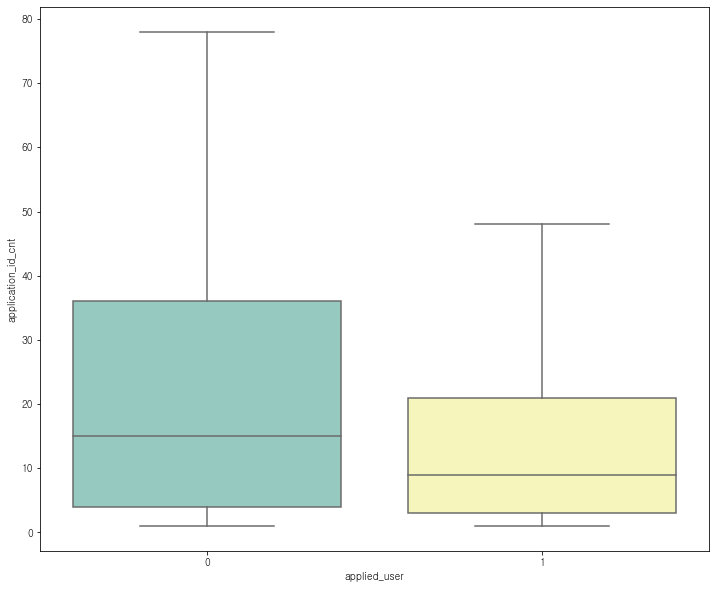

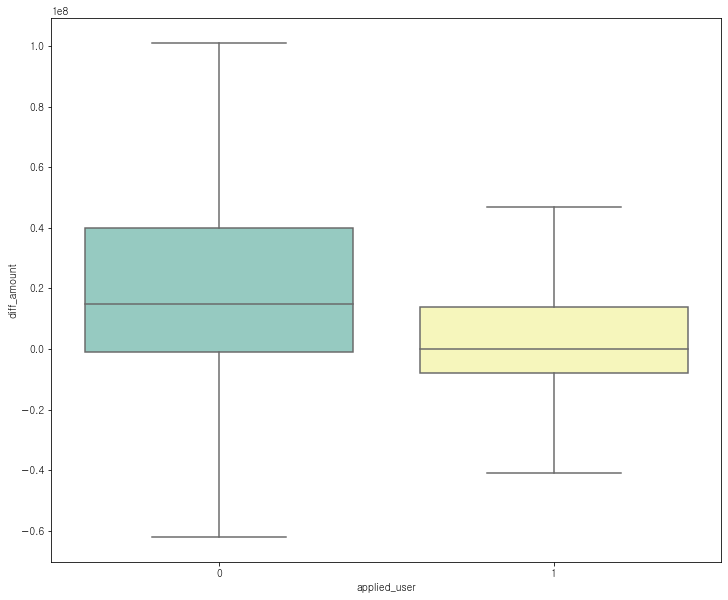

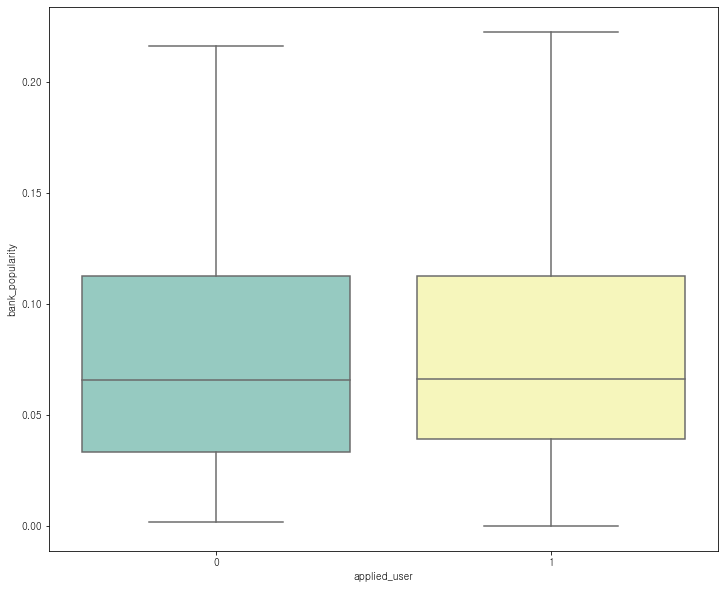

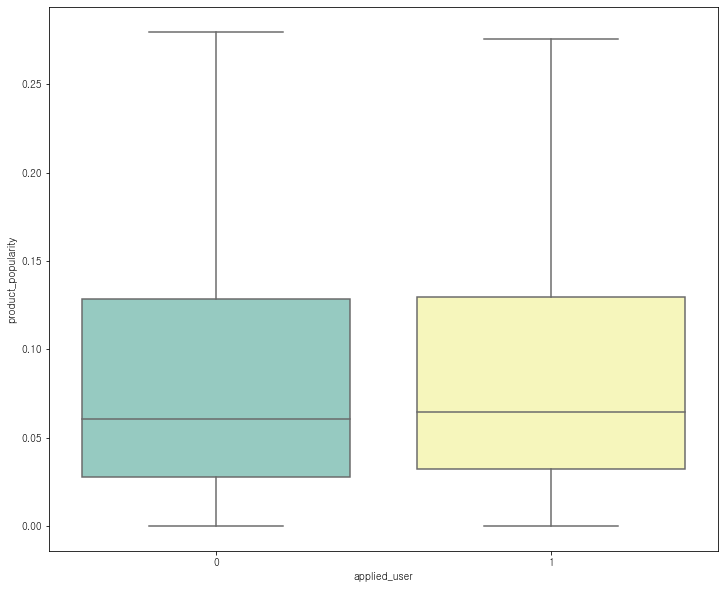

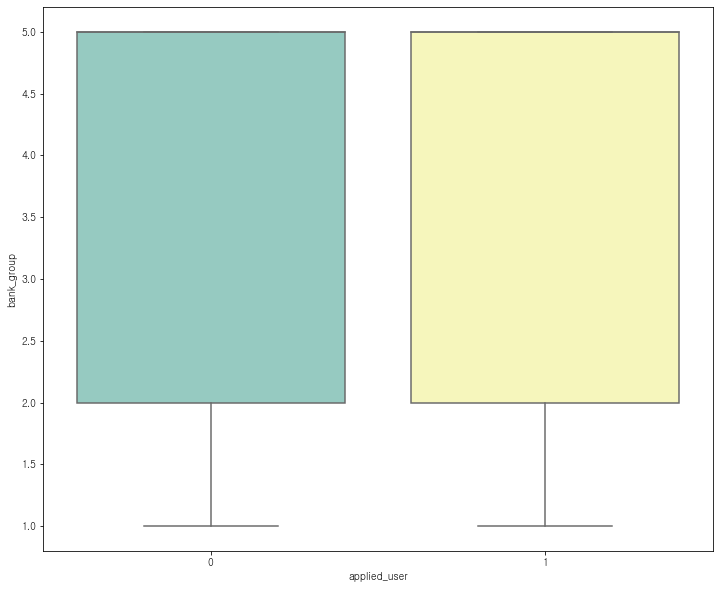

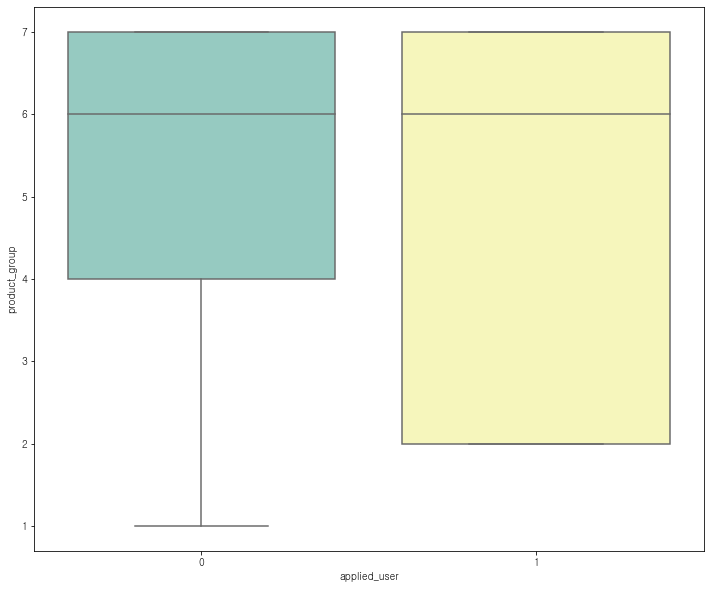

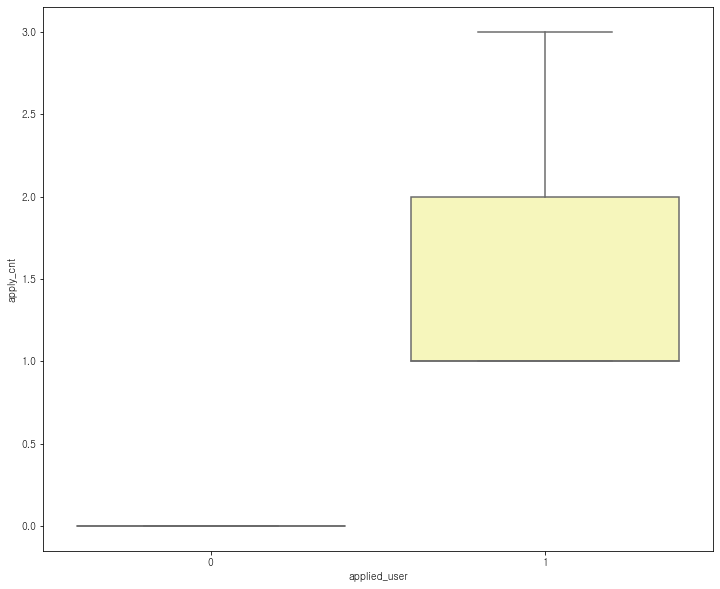

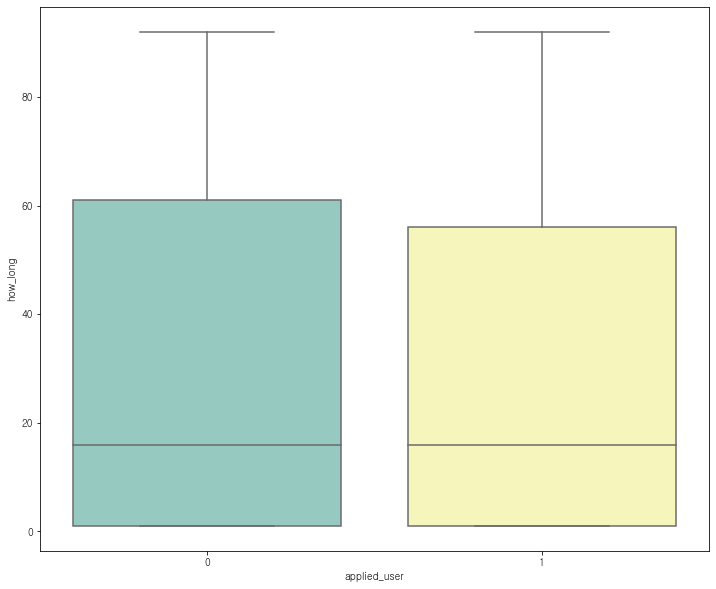

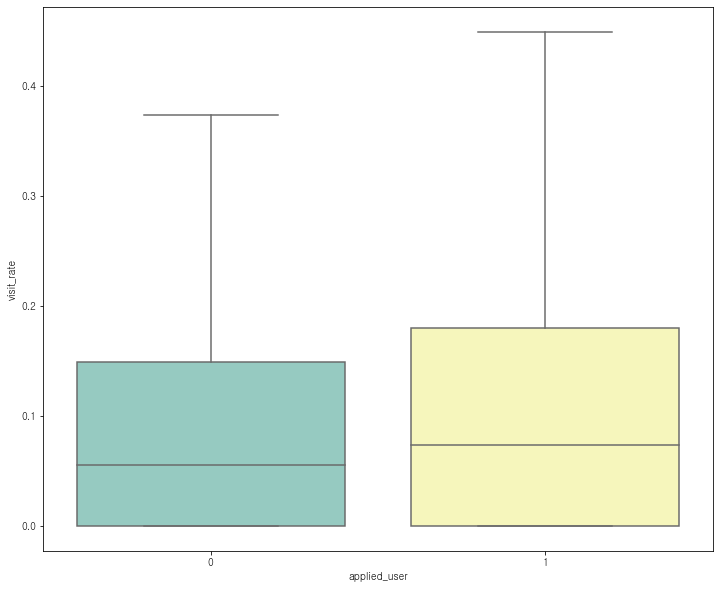

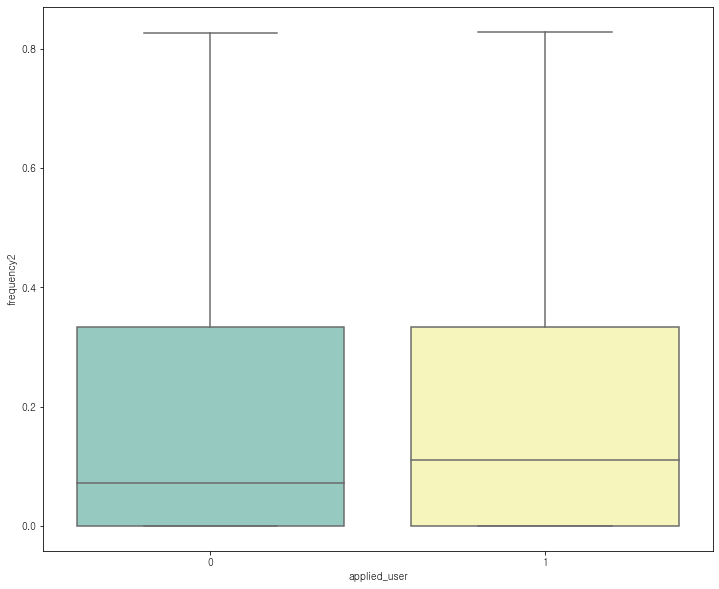

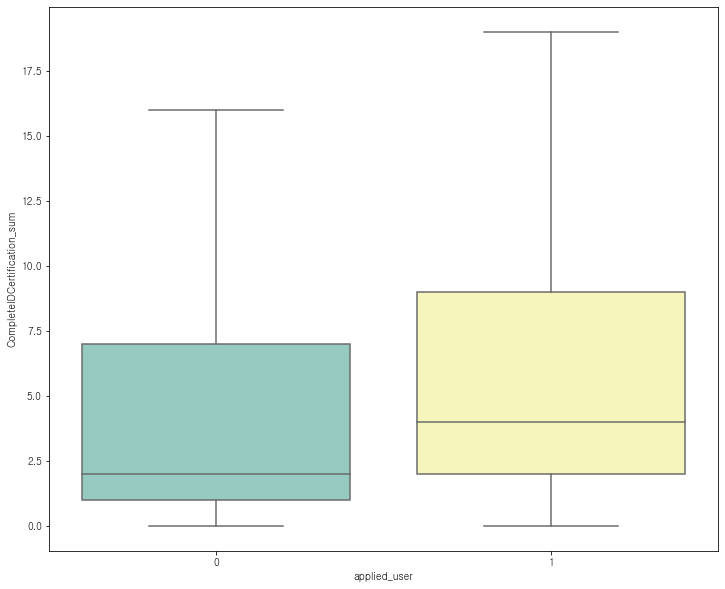

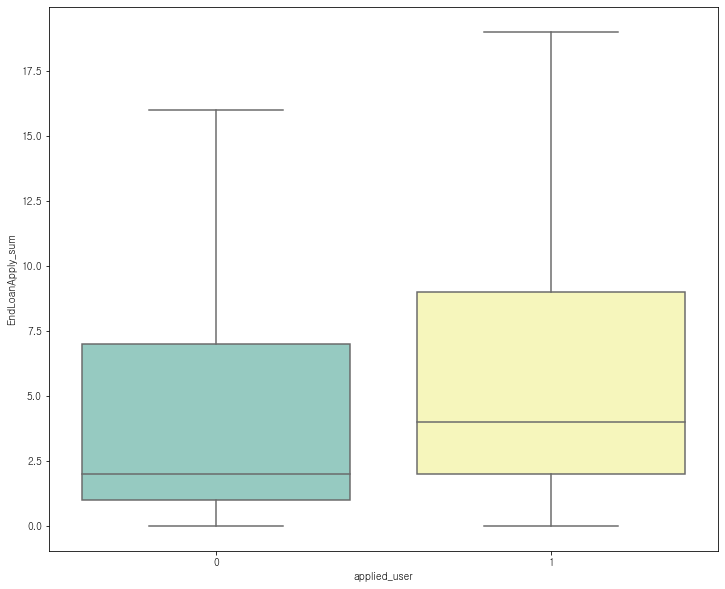

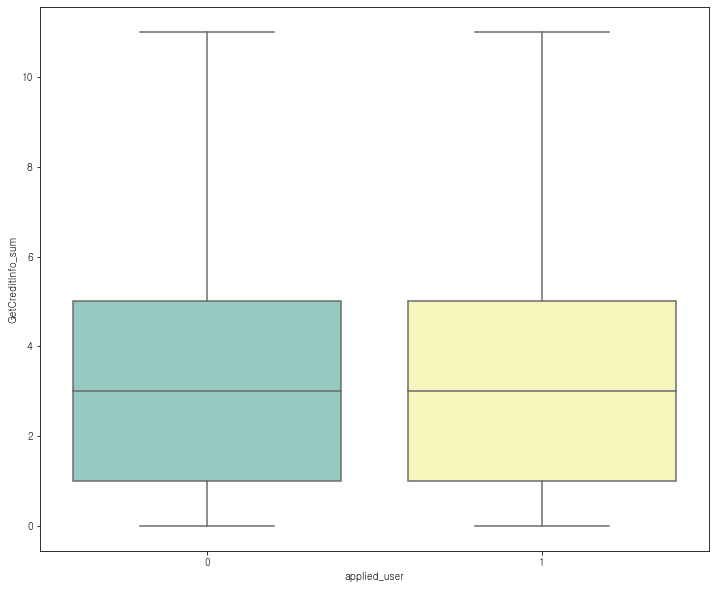

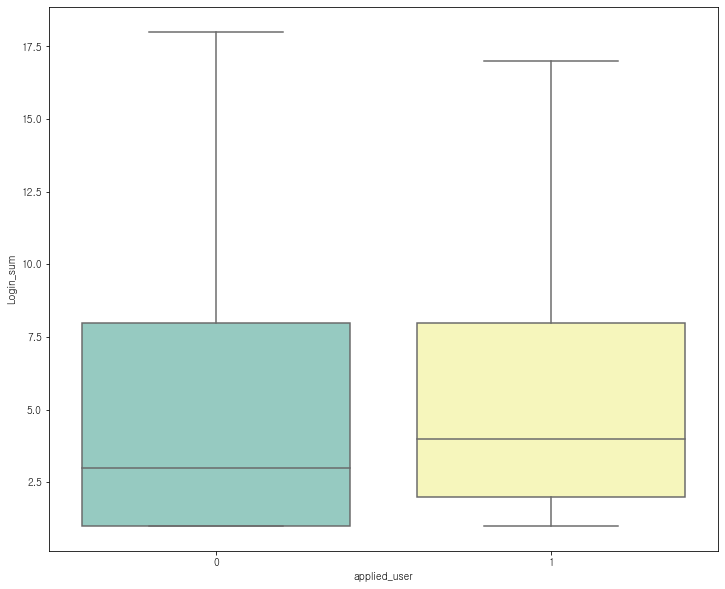

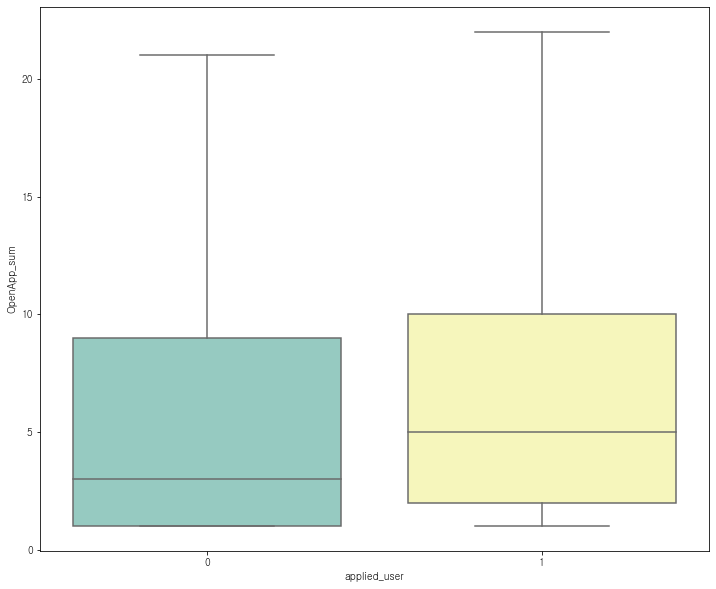

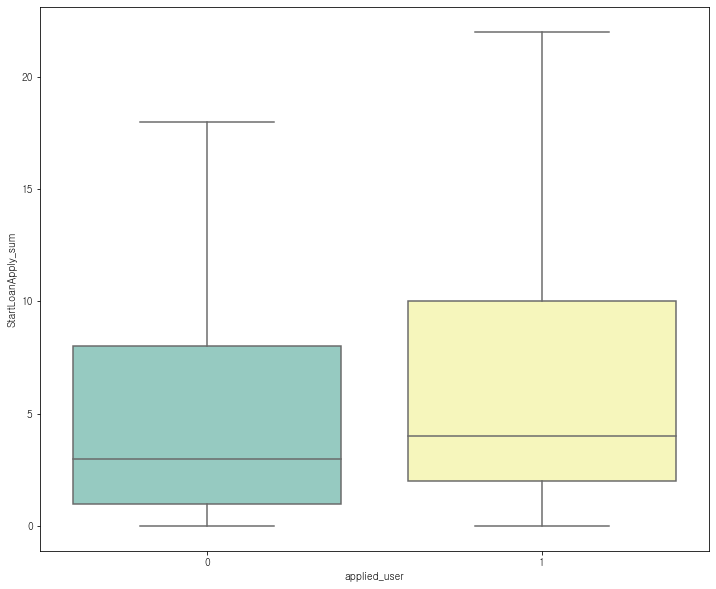

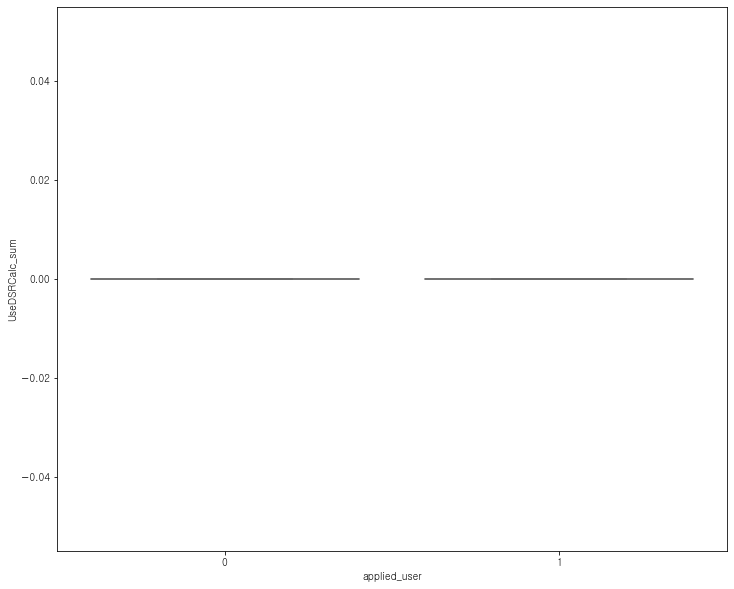

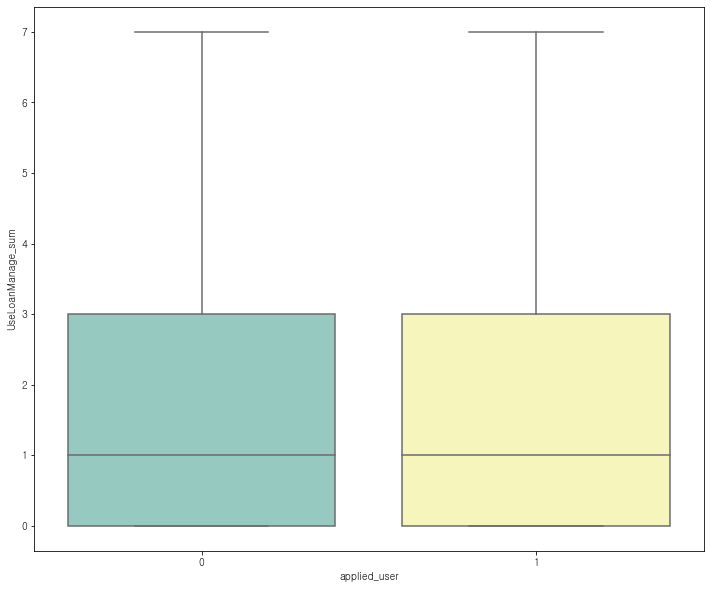

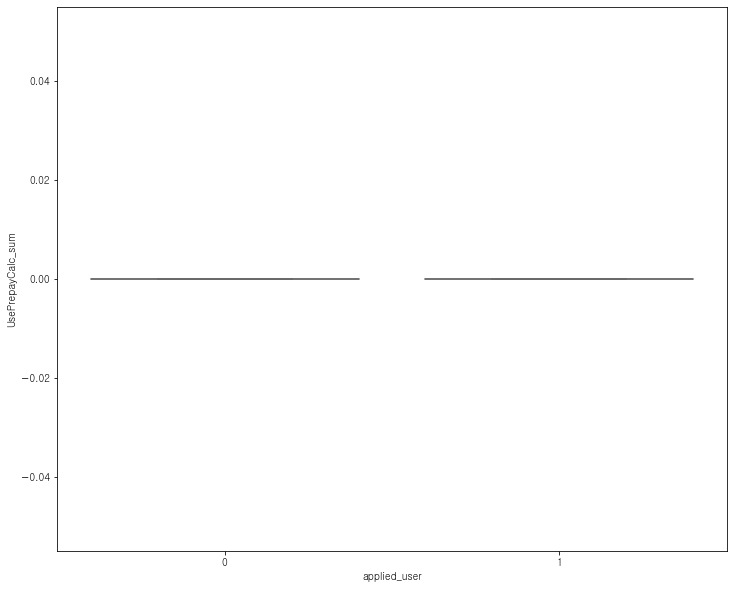

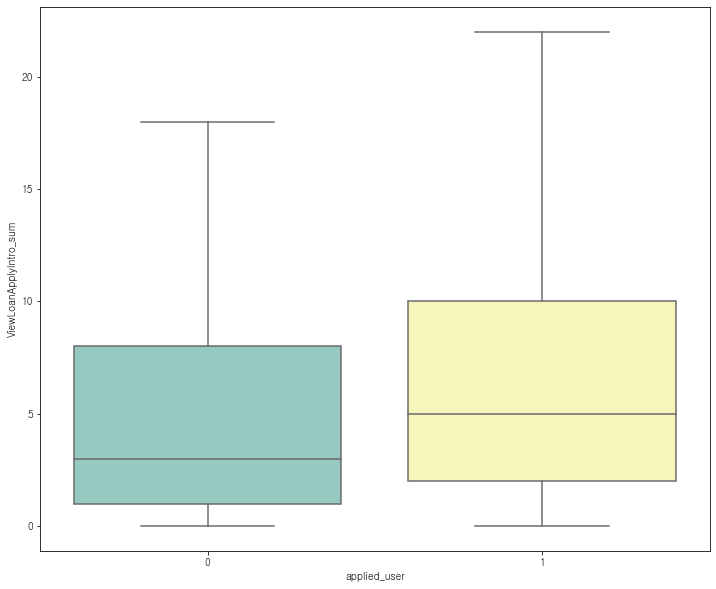

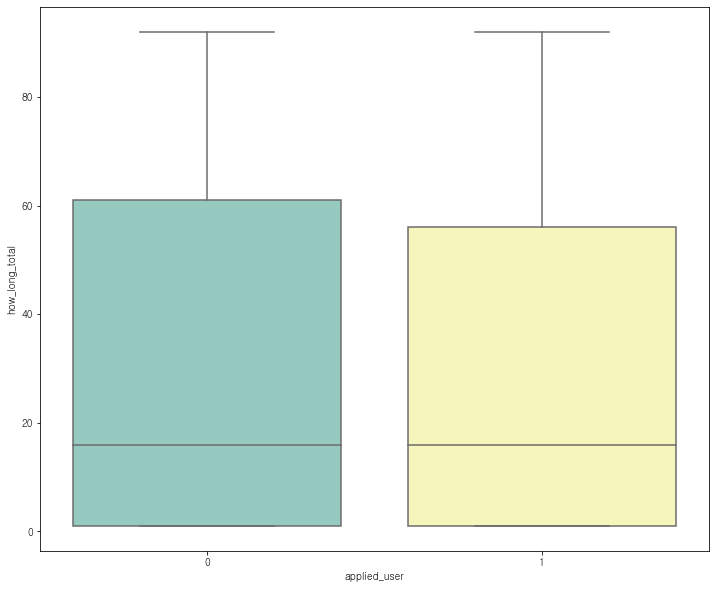

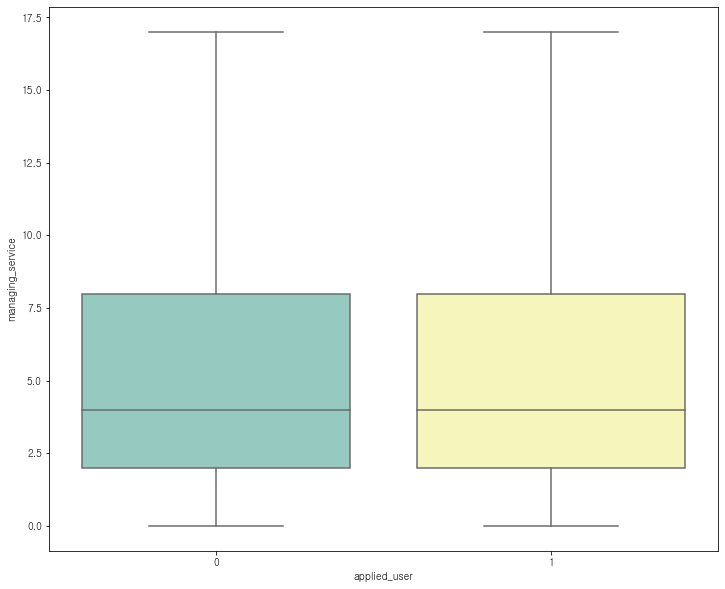

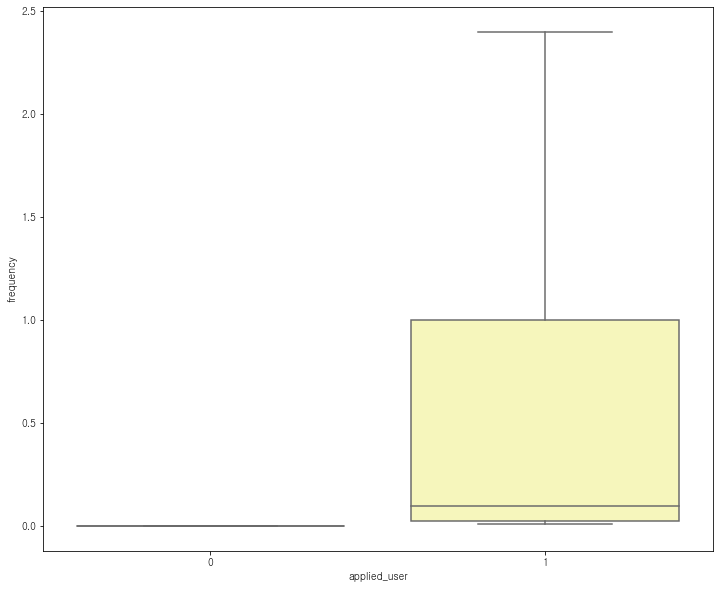

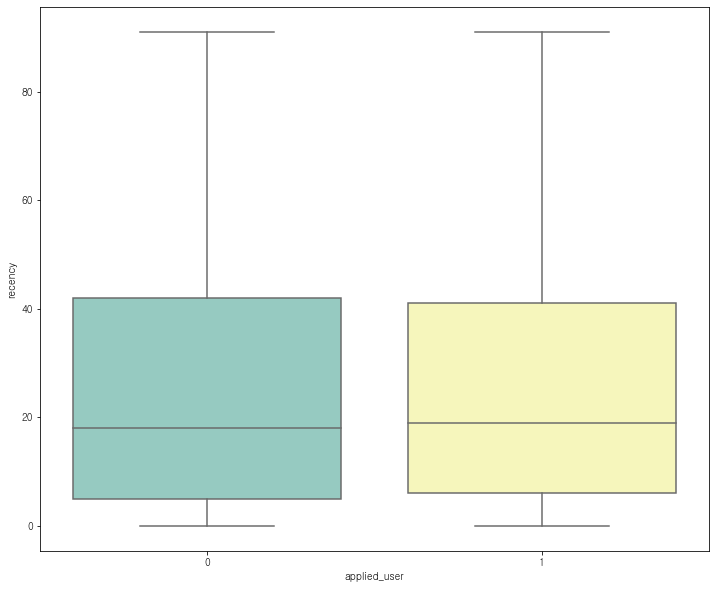

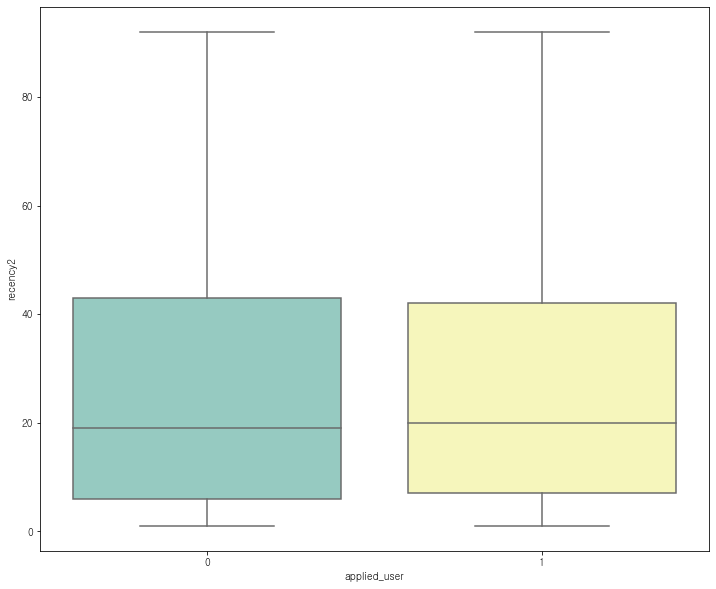

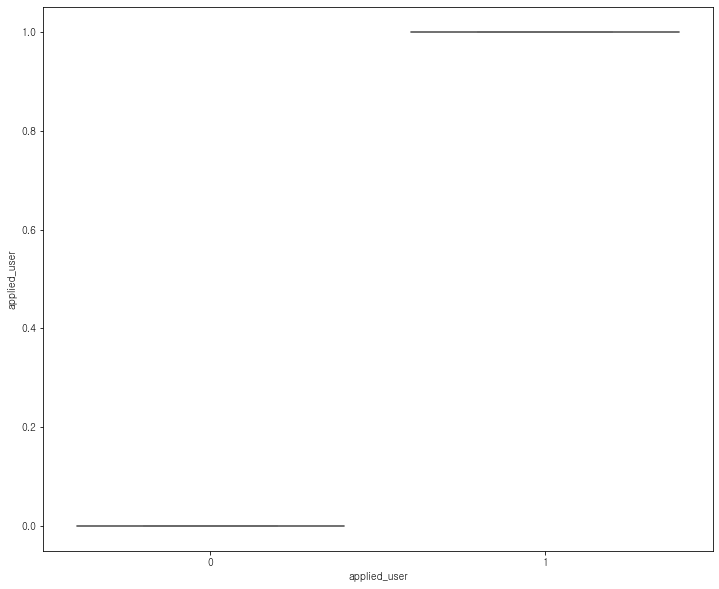

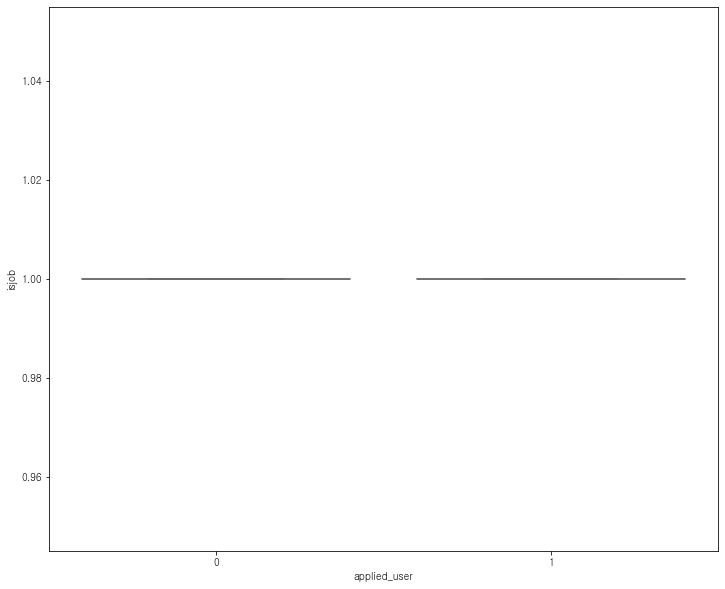

In [22]:
for col in num_cols:
    qualitative_colors = sns.color_palette("Set3", 16)
    sns.set_palette(qualitative_colors)
    plt.figure(figsize=(12,10))
    sns.boxplot(data=unique_user, y=col, x='applied_user',showfliers=False)
    plt.show();

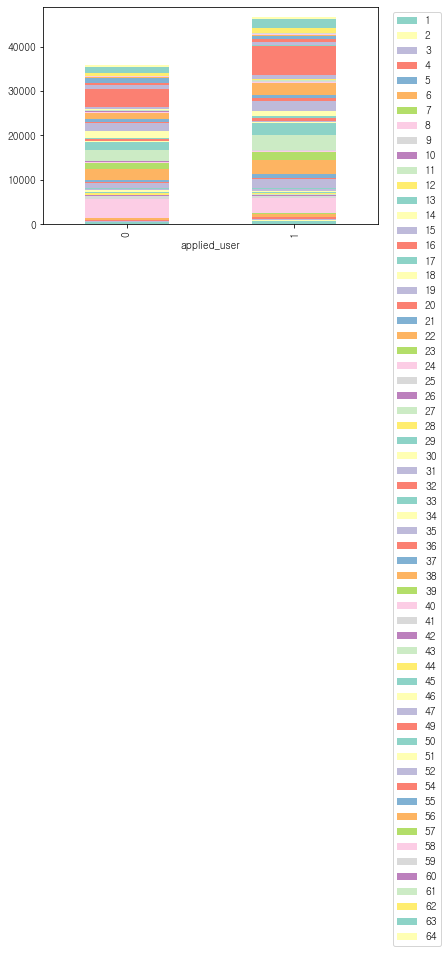

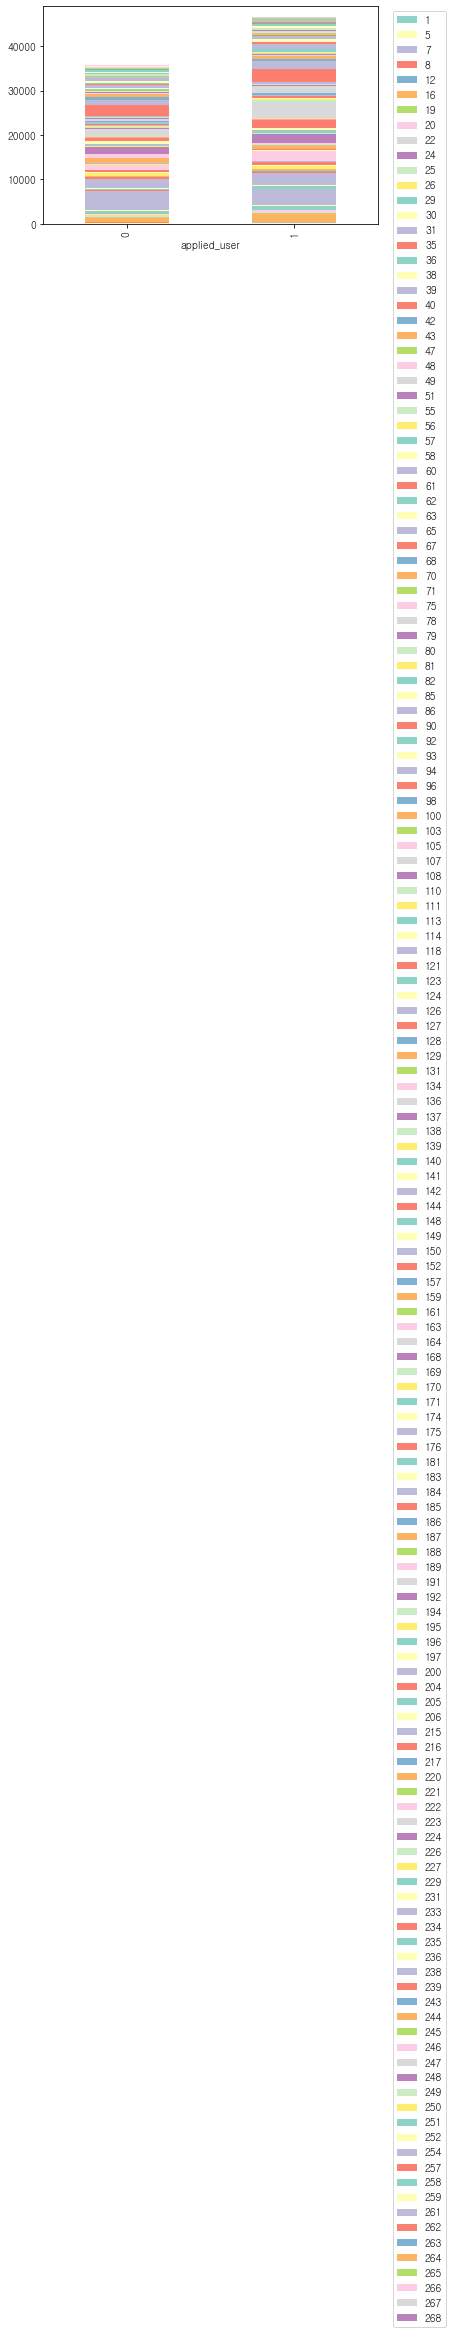

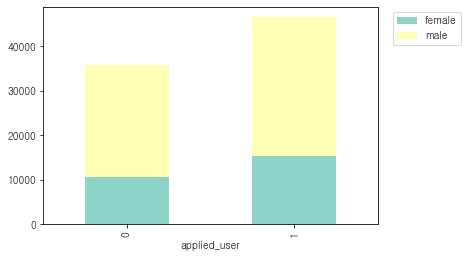

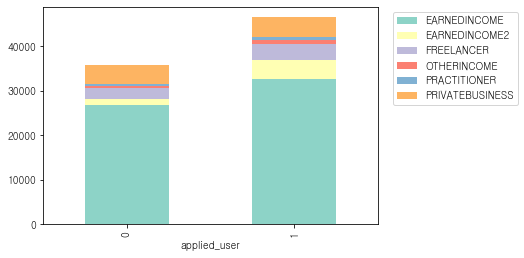

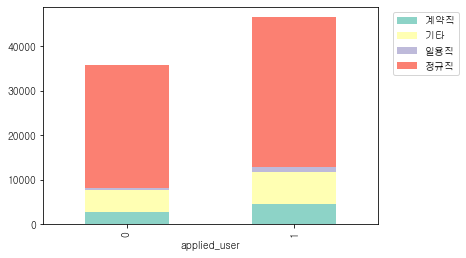

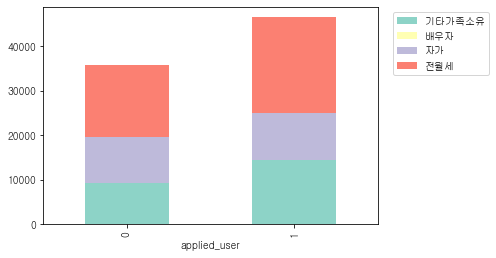

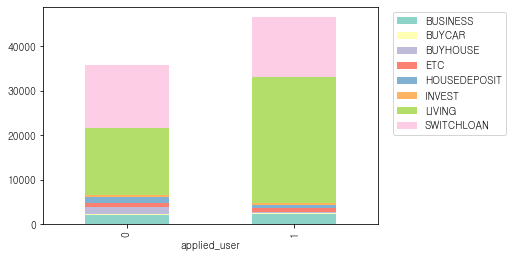

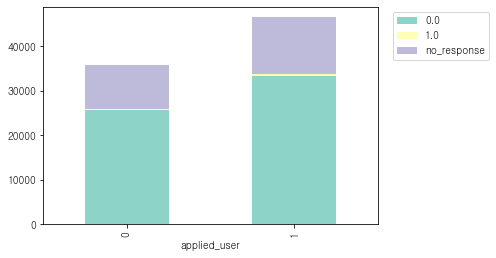

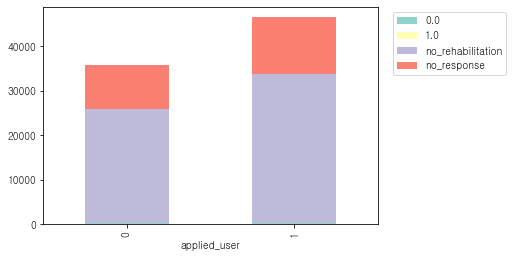

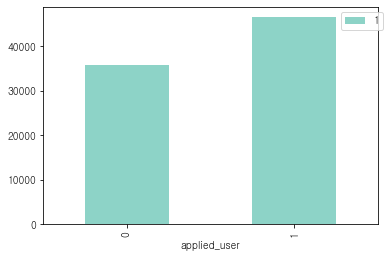

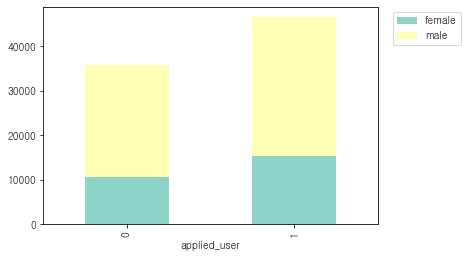

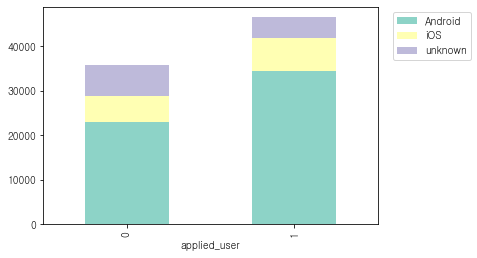

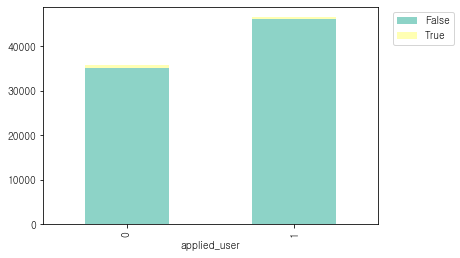

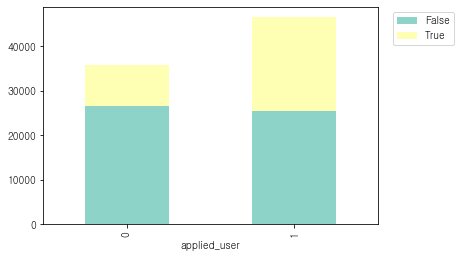

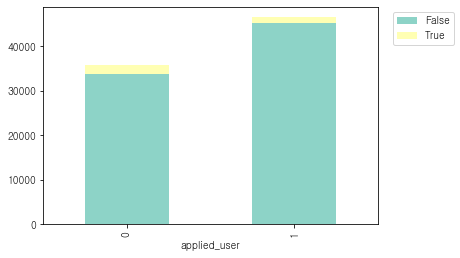

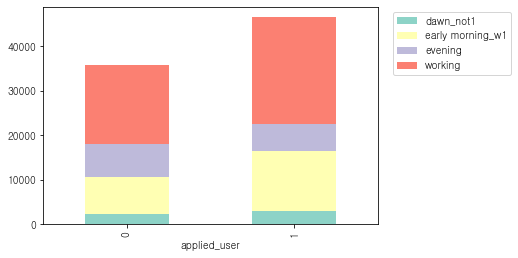

In [23]:
horiz_offset = 1.03
vert_offset = 1.

for col in cat_cols:
  df_plot = unique_user.groupby([col,'applied_user']).size().reset_index().pivot(columns =col, index='applied_user', values=0)
  ax=df_plot.plot(kind ='bar', stacked=True)
  ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))

# FRA : 얼마나 최근, 얼마나 자주, 얼마나 많이 신청

## k-means

In [9]:
pd.set_option('display.max_columns',None)
unique_user.head(5)

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,company_enter_year,age,Session_x,insert_time_month,insert_time_day,insert_time_hour,insert_time_weekday,insert_time_timezone,company_enter_month_year,company_enter_month_month,is_holiday,insert_time_diff,application_id_cnt,diff_amount,more_loan_desired,loan_limit_outlier,first_confirmed,bank_cumcnt,bank_popularity,product_cumcnt,product_popularity,bank_group,product_group,date,loanapply_insert_time_s,apply_cnt,mp_os,Session_y,how_long,visit_cumsum,visit_rate,frequency2,CompleteIDCertification_sum,EndLoanApply_sum,GetCreditInfo_sum,Login_sum,OpenApp_sum,StartLoanApply_sum,UseDSRCalc_sum,UseLoanManage_sum,UsePrepayCalc_sum,ViewLoanApplyIntro_sum,how_long_total,managing_service,frequency,recency,recency2,applied_user,isjob
0,584435,2022-03-01 00:15:40,55,186,25000000.0,10.6,0,334783,1984.0,male,2022-03-01 00:15:22,830.0,60000000.0,PRIVATEBUSINESS,201608.0,정규직,기타가족소유,100000000.0,BUSINESS,no_response,no_response,1.0,6.299001e+07,2016.0,39.0,1.0,3,1,0,1,dawn_not1,2016,8,True,18.0,11,75000000.0,False,False,False,7,0.000000,2,0.000000,5,6,2022-03-01,87340,2,Android,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,91,92,1,1
1,1449958,2022-03-01 00:17:06,27,148,11000000.0,7.5,1,661317,1994.0,female,2022-03-01 00:17:06,200.0,30000000.0,EARNEDINCOME2,202104.0,정규직,기타가족소유,1000000.0,LIVING,no_response,no_response,1.0,2.000000e+07,2021.0,29.0,1.0,3,1,0,1,dawn_not1,2021,4,True,0.0,1,-10000000.0,True,False,True,10,0.200000,4,0.250000,2,2,2022-03-01,87426,1,unknown,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,91,92,1,1
2,505245,2022-03-01 01:31:19,38,16,3000000.0,5.8,0,720040,1978.0,male,2022-03-01 01:30:37,730.0,65000000.0,EARNEDINCOME,201508.0,정규직,자가,100000000.0,LIVING,no_response,no_response,7.0,1.800000e+08,2015.0,45.0,0.0,3,1,1,1,early morning_w1,2015,8,True,42.0,33,97000000.0,False,False,False,135,0.074074,30,0.000000,5,7,2022-03-01,91879,0,unknown,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,91,92,0,1
3,149229,2022-03-01 01:31:38,23,108,36000000.0,12.6,0,835507,1994.0,male,2022-03-01 01:30:52,770.0,24000000.0,EARNEDINCOME,202101.0,정규직,전월세,8000000.0,LIVING,no_response,no_response,1.0,8.000000e+06,2021.0,29.0,1.0,3,1,1,1,early morning_w1,2021,1,True,46.0,52,-28000000.0,True,False,False,13,0.000000,7,0.000000,5,7,2022-03-01,91898,2,Android,2.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0,2.0,91,92,1,1
4,1104187,2022-03-01 04:12:26,47,138,30000000.0,15.6,1,485721,1978.0,female,2022-03-01 04:12:19,650.0,30000000.0,EARNEDINCOME,201805.0,정규직,전월세,20000000.0,LIVING,no_response,no_response,3.0,3.300000e+07,2018.0,45.0,1.0,3,1,4,1,dawn_not1,2018,5,True,7.0,5,-10000000.0,True,False,False,124,0.080645,60,0.033333,5,7,2022-03-01,101546,1,Android,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,91,92,1,1


In [10]:
col3 =['visit_rate','recency2','applied_user'] 

In [11]:
# 정규화
data = unique_user[col3]
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

In [ ]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(1,10))
# visualizer.fit(data_scale)
# visualizer.show()


## k = 8

In [12]:
# 클러스터링 학습
from sklearn.cluster import KMeans

#클러스터 개수  
k=8

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

#정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇번째 그룹에 속하는 지 저장
unique_user['cluster'] = model.fit_predict(data_scale)

1단계: 클러스터의 크기 확인

<AxesSubplot:xlabel='cluster', ylabel='count'>

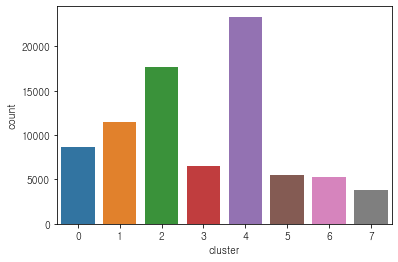

In [106]:
sns.countplot(x='cluster',data=unique_user)

2단계: 클러스터의 전반적인 특성 차이를 한눈에 확인하기

In [93]:
pd.set_option('display.max_columns',None)
unique_user.groupby(['cluster']).median() #클러스터별 변수들의 중간값

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt,company_enter_year,age,Session_x,insert_time_month,insert_time_day,insert_time_hour,insert_time_weekday,company_enter_month_year,company_enter_month_month,insert_time_diff,application_id_cnt,diff_amount,bank_cumcnt,bank_popularity,product_cumcnt,product_popularity,bank_group,product_group,loanapply_insert_time_s,apply_cnt,Session_y,how_long,visit_cumsum,visit_rate,frequency2,CompleteIDCertification_sum,EndLoanApply_sum,GetCreditInfo_sum,Login_sum,OpenApp_sum,StartLoanApply_sum,UseDSRCalc_sum,UseLoanManage_sum,UsePrepayCalc_sum,ViewLoanApplyIntro_sum,how_long_total,managing_service,frequency,recency,recency2,applied_user,isjob
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1081437.5,27.0,136.0,14000000.0,11.9,0.0,444364.0,1983.0,740.0,40000000.0,202001.0,30000000.0,3.0,6.299001e+07,2020.0,40.0,1.0,4.0,17.0,14.0,2.0,2020.0,5.0,17.0,18.0,17000000.0,84437.0,0.061804,36730.0,0.060167,5.0,6.0,4625029.5,0.0,1.0,1.0,0.0,0.000000,0.000000,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.000000,39.0,40.0,0.0,1.0
1,1090615.0,29.0,138.0,12000000.0,12.9,0.0,443140.0,1983.0,650.0,36000000.0,202006.0,13000000.0,4.0,5.000000e+07,2020.0,40.0,1.0,4.0,18.0,13.0,2.0,2020.0,5.0,14.0,10.0,1000000.0,90308.0,0.061124,39158.0,0.060330,5.0,6.0,4626263.0,1.0,1.0,6.0,1.0,0.027027,0.027027,2.0,2.0,2.0,2.0,3.0,3.0,0.0,1.0,0.0,3.0,6.0,3.0,0.250000,39.0,40.0,1.0,1.0
2,1081357.0,29.0,108.0,13000000.0,12.5,0.0,440912.0,1984.0,690.0,39000000.0,202004.0,30000000.0,3.0,6.200000e+07,2020.0,39.0,1.0,5.0,24.0,14.0,2.0,2020.0,5.0,17.0,13.0,13000000.0,142634.0,0.068362,59413.0,0.063278,5.0,6.0,7401577.0,0.0,1.0,50.0,3.0,0.065789,0.100000,4.0,3.0,3.0,5.0,5.0,4.0,0.0,2.0,0.0,4.0,50.0,5.0,0.000000,7.0,8.0,0.0,1.0
3,1105302.0,32.0,136.0,11000000.0,13.3,0.0,438181.0,1983.0,650.0,35000000.0,202007.0,15000000.0,4.0,4.800000e+07,2020.0,40.0,1.0,3.0,16.0,12.0,2.0,2020.0,6.0,16.0,11.0,1000000.0,30986.0,0.061528,12695.5,0.059947,5.0,6.0,1871537.5,1.0,1.0,2.0,1.0,0.035099,0.035099,2.0,2.0,2.0,2.0,3.0,3.0,0.0,1.0,0.0,3.0,2.0,3.0,1.000000,71.0,72.0,1.0,1.0
4,1091325.0,32.0,127.0,14000000.0,12.7,0.0,442060.0,1984.0,640.0,35000000.0,202010.0,10000000.0,4.0,5.000000e+07,2020.0,39.0,1.0,5.0,24.0,13.0,2.0,2020.0,5.0,15.0,8.0,0.0,158858.0,0.068987,65423.5,0.065121,5.0,6.0,7346517.5,1.0,1.0,48.0,3.0,0.071429,0.108696,5.0,5.0,3.0,5.0,6.0,6.0,0.0,2.0,0.0,6.0,48.0,5.0,0.032258,7.0,8.0,1.0,1.0
5,1064645.0,30.0,123.0,13000000.0,12.5,0.0,441619.0,1984.0,740.0,40000000.0,201911.0,30000000.0,3.0,6.299001e+07,2019.0,39.0,1.0,3.0,15.0,14.0,2.0,2019.0,6.0,18.0,18.0,19000000.0,28048.5,0.062197,11213.5,0.059661,5.0,6.0,1928432.5,0.0,1.0,1.0,0.0,0.000000,0.000000,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.000000,70.0,71.0,0.0,1.0
6,1082057.5,29.0,136.0,13000000.0,11.9,0.0,437507.0,1984.0,650.0,35000000.0,202010.0,15000000.0,3.0,5.000000e+07,2020.0,39.0,1.0,5.0,21.0,11.0,2.0,2020.0,5.0,15.0,10.0,1000000.0,125304.0,0.070265,57948.0,0.064755,5.0,4.0,6715062.0,1.0,1.0,4.0,2.0,0.500000,0.500000,7.0,7.0,3.0,5.0,6.0,7.0,0.0,2.0,0.0,8.0,4.0,6.0,0.333333,15.0,16.0,1.0,1.0
7,1076511.5,29.0,127.0,12000000.0,12.9,0.0,437578.0,1984.0,660.0,36000000.0,202009.0,20000000.0,3.0,5.900000e+07,2020.0,39.0,1.0,5.0,26.0,12.0,1.0,2020.0,5.0,14.0,9.0,9000000.0,145219.5,0.062028,62475.5,0.057839,5.0,6.0,7554951.5,0.0,1.0,20.0,8.0,0.400000,0.500000,14.0,14.0,7.0,14.0,17.0,15.0,0.0,4.0,0.0,16.0,20.0,11.0,0.000000,5.0,6.0,0.0,1.0


In [94]:
unique_user.groupby(['cluster']).agg(pd.Series.mode) #클러스터별 변수들의 최빈값

,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,company_enter_year,age,Session_x,insert_time_month,insert_time_day,insert_time_hour,insert_time_weekday,insert_time_timezone,company_enter_month_year,company_enter_month_month,is_holiday,insert_time_diff,application_id_cnt,diff_amount,more_loan_desired,loan_limit_outlier,first_confirmed,bank_group,product_group,date,apply_cnt,mp_os,Session_y,how_long,visit_cumsum,visit_rate,frequency2,CompleteIDCertification_sum,EndLoanApply_sum,GetCreditInfo_sum,Login_sum,OpenApp_sum,StartLoanApply_sum,UseDSRCalc_sum,UseLoanManage_sum,UsePrepayCalc_sum,ViewLoanApplyIntro_sum,how_long_total,managing_service,frequency,recency,recency2,applied_user,isjob
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"[2022-04-15 22:10:26, 2022-04-18 14:55:35, 202...",8,31,3000000.0,11.9,0,1982.0,male,"[2022-04-11 11:21:12, 2022-04-11 12:27:15, 202...",950.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,50000000.0,SWITCHLOAN,0.0,no_rehabilitation,1.0,6.299001e+07,2021.0,41.0,1.0,4,6,10,0,working,2021,1,False,2.0,1,0.0,False,False,False,5,4,2022-04-18,0,Android,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,43,44,0,1
1,"[2022-04-06 15:25:25, 2022-04-13 12:05:40, 202...",27,176,3000000.0,6.5,0,1982.0,male,"[2022-04-06 14:38:17, 2022-04-07 10:33:44, 202...",610.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,10000000.0,LIVING,0.0,no_rehabilitation,1.0,6.299001e+07,2021.0,41.0,1.0,4,6,10,0,working,2021,1,False,2.0,1,0.0,False,False,False,5,7,2022-04-18,1,Android,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,43,44,1,1
2,"[2022-05-09 19:22:27, 2022-05-10 08:27:21, 202...",49,31,3000000.0,6.5,0,1982.0,male,"[2022-05-09 07:30:51, 2022-05-09 22:48:40, 202...",620.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,10000000.0,LIVING,0.0,no_rehabilitation,1.0,6.299001e+07,2021.0,41.0,1.0,5,31,10,1,working,2021,1,False,2.0,1,7000000.0,False,False,False,5,7,2022-05-31,0,Android,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0,1,0,1
3,"[2022-03-07 12:07:58, 2022-03-08 13:48:36, 202...",27,31,3000000.0,12.9,0,1982.0,male,"[2022-03-02 15:06:37, 2022-03-14 09:52:47, 202...",610.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,10000000.0,LIVING,no_response,no_response,1.0,6.299001e+07,2021.0,41.0,1.0,3,4,10,0,working,2021,1,False,2.0,1,0.0,False,False,False,5,7,2022-03-21,1,Android,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,71,72,1,1
4,"[2022-05-17 12:55:26, 2022-05-30 11:48:37]",49,39,3000000.0,6.5,0,1992.0,male,2022-05-23 13:39:49,610.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,10000000.0,LIVING,0.0,no_rehabilitation,1.0,6.299001e+07,2021.0,31.0,1.0,5,31,10,1,working,2021,1,False,2.0,1,0.0,False,False,False,5,7,2022-05-31,1,Android,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,0,1,1,1
5,"[2022-03-03 22:40:25, 2022-03-20 09:26:14, 202...",8,31,3000000.0,11.9,0,1981.0,male,2022-04-01 14:22:29,630.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,50000000.0,SWITCHLOAN,no_response,no_response,1.0,6.299001e+07,2021.0,42.0,1.0,3,4,10,1,working,2021,3,False,2.0,1,0.0,False,False,False,5,4,2022-04-05,0,Android,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,56,57,0,1
6,"[2022-05-06 12:55:33, 2022-05-19 11:11:24, 202...",49,31,3000000.0,6.5,0,1992.0,male,"[2022-04-18 10:36:54, 2022-05-18 10:59:47, 202...",620.0,30000000.0,EARNEDINCOME,202201.0,정규직,전월세,10000000.0,LIVING,0.0,no_rehabilitation,1.0,6.299001e+07,2021.0,31.0,1.0,5,31,9,1,working,2021,1,False,2.0,1,0.0,False,False,False,5,7,2022-05-31,1,Android,1.0,2.0,1.0,0.5,0.5,3.0,3.0,2.0,3.0,3.0,4.0,0.0,1.0,0.0,3.0,2.0,3.0,0.5,0,1,1,1
7,"[2022-05-13 09:15:54, 2022-05-29 18:56:10, 20

In [95]:
# # 클러스터별 applied_user
# print('cluster0:', unique_user.loc[unique_user['cluster']==0, 'applied_user'].value_counts())
# print('cluster1:', unique_user.loc[unique_user['cluster']==1, 'applied_user'].value_counts())
# print('cluster2:', unique_user.loc[unique_user['cluster']==2, 'applied_user'].value_counts())
# print('cluster3:', unique_user.loc[unique_user['cluster']==3, 'applied_user'].value_counts())


cluster0: 0    8706
Name: applied_user, dtype: int64
cluster1: 1    11487
Name: applied_user, dtype: int64
cluster2: 0    17731
Name: applied_user, dtype: int64
cluster3: 1    6466
Name: applied_user, dtype: int64


클러스터 결과 시각화

Text(0.5, 0, 'applied_user')

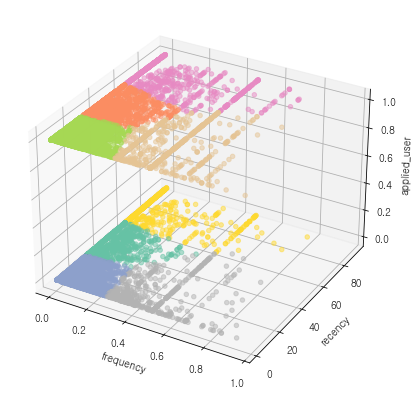

In [48]:
#몇몇 점만 뽑아서 시각화
sample = unique_user.sample(n=10000, replace = False)

# https://frhyme.github.io/python-lib/matplotlib_3dplotting/
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d') 

x = sample['visit_rate']
y = sample['recency2']
z = sample['applied_user']
ax.scatter(x, y, z, c = sample.cluster, s= 20, alpha=0.5, cmap='Set2')

ax.set_xlabel('frequency')
ax.set_ylabel('recency')
ax.set_zlabel('applied_user')



In [108]:
unique_user.apply_cnt.quantile([0,0.25,0.5,0.75,1])

0.00     0.0
0.25     0.0
0.50     1.0
0.75     1.0
1.00    16.0
Name: apply_cnt, dtype: float64

# 군집별 분석

In [112]:
unique_user.groupby(['cluster']).min()[['visit_rate','recency2','applied_user']] #클러스터별 변수들의 최소값

,visit_rate,recency2,applied_user
cluster,,,
0,0.000000,24,0
1,0.000000,25,1
2,0.000000,1,0
3,0.000000,50,1
4,0.000000,1,1
5,0.000000,54,0
6,0.250000,1,1
7,0.243243,1,0


In [113]:
unique_user.groupby(['cluster']).max()[['visit_rate','recency2','applied_user']] #클러스터별 변수들의 최대값

,visit_rate,recency2,applied_user
cluster,,,
0,0.454545,56,0
1,0.375000,58,1
2,0.258427,26,0
3,0.833333,92,1
4,0.321429,26,1
5,0.909091,92,0
6,0.978261,73,1
7,0.989130,65,0


In [13]:
#unique_user['cluster2']=np.nan

unique_user.loc[(unique_user['cluster']==0),'cluster2']='leftworried'
unique_user.loc[(unique_user['cluster']==1),'cluster2']='soonsleep'
unique_user.loc[(unique_user['cluster']==2),'cluster2']='new'
unique_user.loc[(unique_user['cluster']==3),'cluster2']='hibernate'
unique_user.loc[(unique_user['cluster']==4),'cluster2']='potentialloyal'
unique_user.loc[(unique_user['cluster']==5),'cluster2']='left'
unique_user.loc[(unique_user['cluster']==6),'cluster2']='loyal'
unique_user.loc[(unique_user['cluster']==7),'cluster2']='careneed'

<AxesSubplot:xlabel='cluster2', ylabel='count'>

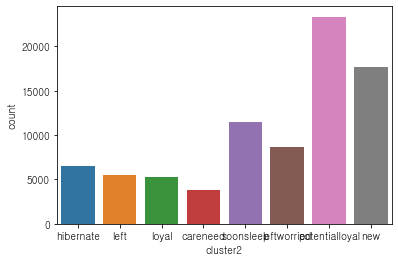

In [121]:
sns.countplot(x='cluster2',data=unique_user)

In [126]:
unique_user.groupby(['cluster2']).size()

cluster2
careneed           3812
hibernate          6466
left               5530
leftworried        8706
loyal              5292
new               17731
potentialloyal    23352
soonsleep         11487
dtype: int64

In [127]:
unique_user.groupby(['cluster2']).size()/unique_user.shape[0]

cluster2
careneed          0.046276
hibernate         0.078494
left              0.067131
leftworried       0.105686
loyal             0.064242
new               0.215245
potentialloyal    0.283481
soonsleep         0.139446
dtype: float64

# 군집 간 차이 분석

In [135]:
unique_user.select_dtypes(include = ["number"]).columns

Index(['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate',
       'is_applied', 'user_id', 'birth_year', 'credit_score', 'yearly_income',
       'company_enter_month', 'desired_amount', 'existing_loan_cnt',
       'existing_loan_amt', 'company_enter_year', 'age', 'Session_x',
       'insert_time_month', 'insert_time_day', 'insert_time_hour',
       'insert_time_weekday', 'company_enter_month_year',
       'company_enter_month_month', 'insert_time_diff', 'application_id_cnt',
       'diff_amount', 'bank_cumcnt', 'bank_popularity', 'product_cumcnt',
       'product_popularity', 'bank_group', 'product_group',
       'loanapply_insert_time_s', 'apply_cnt', 'Session_y', 'how_long',
       'visit_cumsum', 'visit_rate', 'frequency2',
       'CompleteIDCertification_sum', 'EndLoanApply_sum', 'GetCreditInfo_sum',
       'Login_sum', 'OpenApp_sum', 'StartLoanApply_sum', 'UseDSRCalc_sum',
       'UseLoanManage_sum', 'UsePrepayCalc_sum', 'ViewLoanApplyIntro_sum',
       'how_long

In [15]:
#범주형 변수들
cat_cols = ['bank_id', 'product_id', 'gender', 'income_type',
       'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn','isjob','gender','mp_os','is_holiday',
        'more_loan_desired', 'loan_limit_outlier','insert_time_timezone']
#연속형 변수들
num_cols = ['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate',
        'birth_year', 'credit_score', 'yearly_income',
       'company_enter_month', 'desired_amount', 'existing_loan_cnt',
       'existing_loan_amt', 'company_enter_year', 'age',
       'insert_time_month', 'insert_time_day', 'insert_time_hour',
       'insert_time_weekday', 'company_enter_month_year',
       'company_enter_month_month', 'application_id_cnt',
       'diff_amount', 'bank_popularity', 
       'product_popularity', 'bank_group', 'product_group',
        'apply_cnt', 'how_long',
       'visit_rate', 'frequency2',
       'CompleteIDCertification_sum', 'EndLoanApply_sum', 'GetCreditInfo_sum',
       'Login_sum', 'OpenApp_sum', 'StartLoanApply_sum', 'UseDSRCalc_sum',
       'UseLoanManage_sum', 'UsePrepayCalc_sum', 'ViewLoanApplyIntro_sum',
       'how_long_total', 'managing_service', 'frequency', 'recency',
       'recency2', 'applied_user', 'isjob']

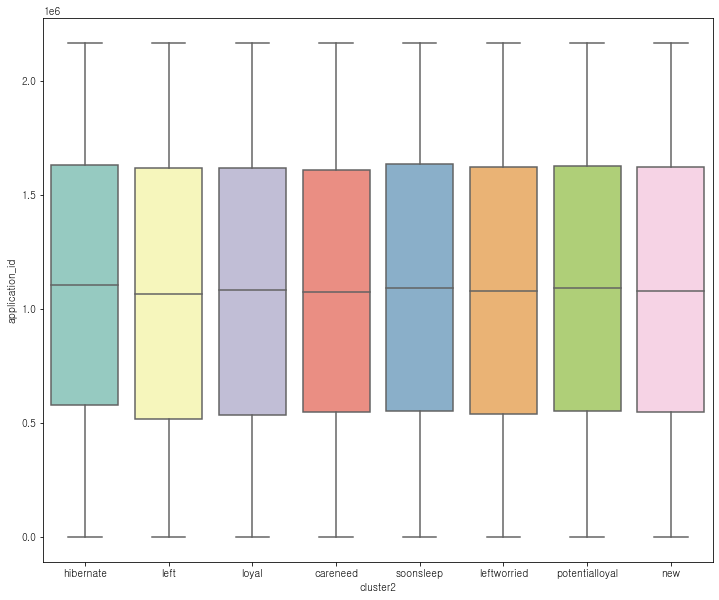

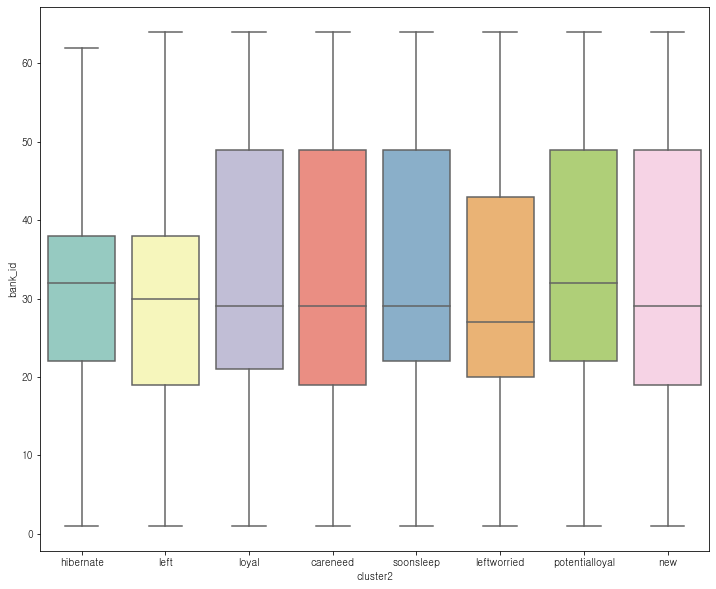

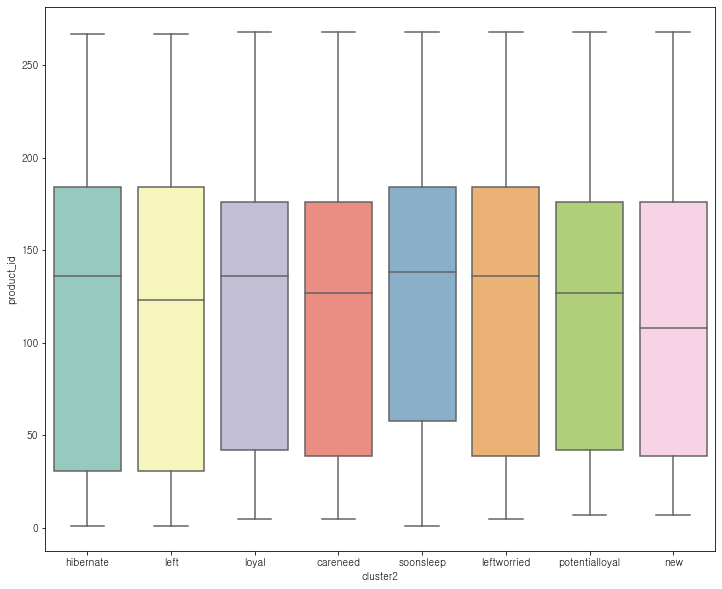

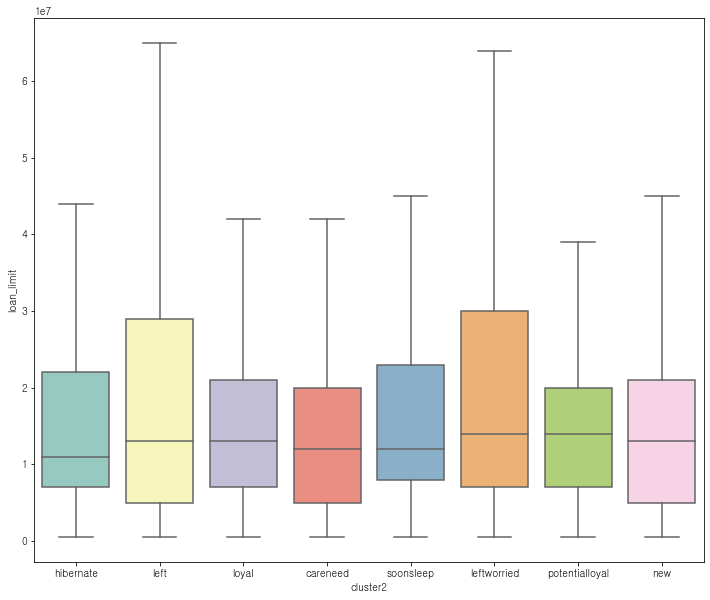

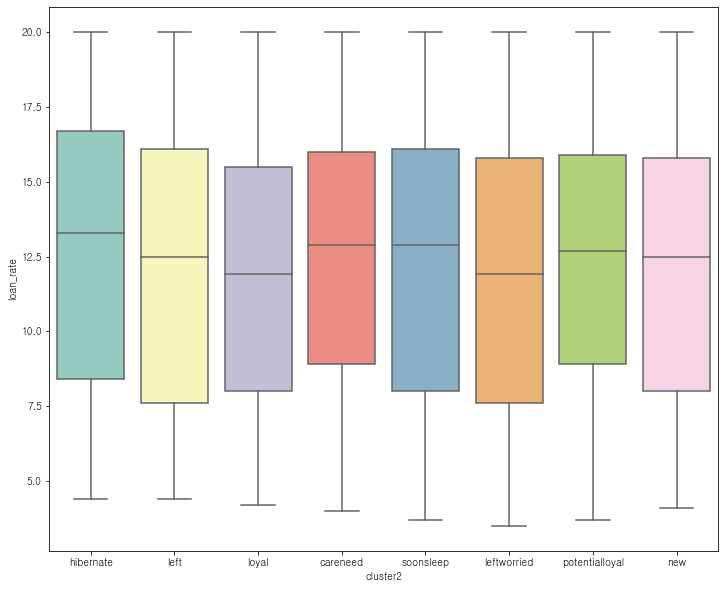

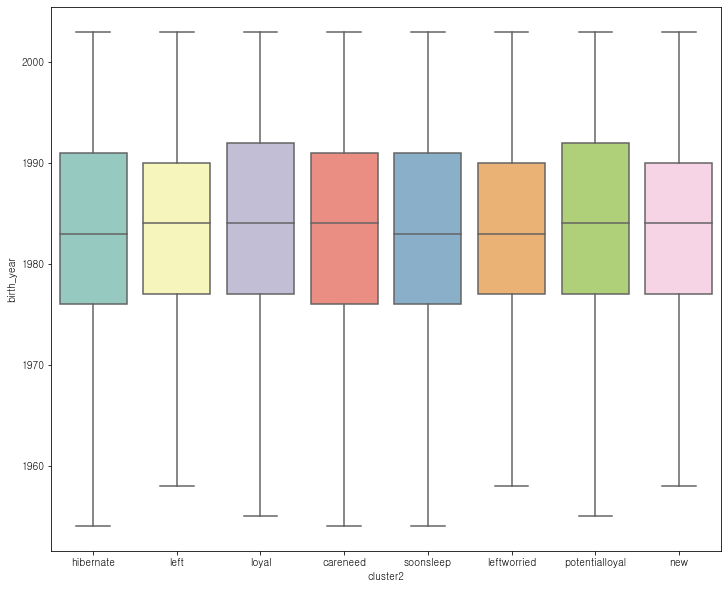

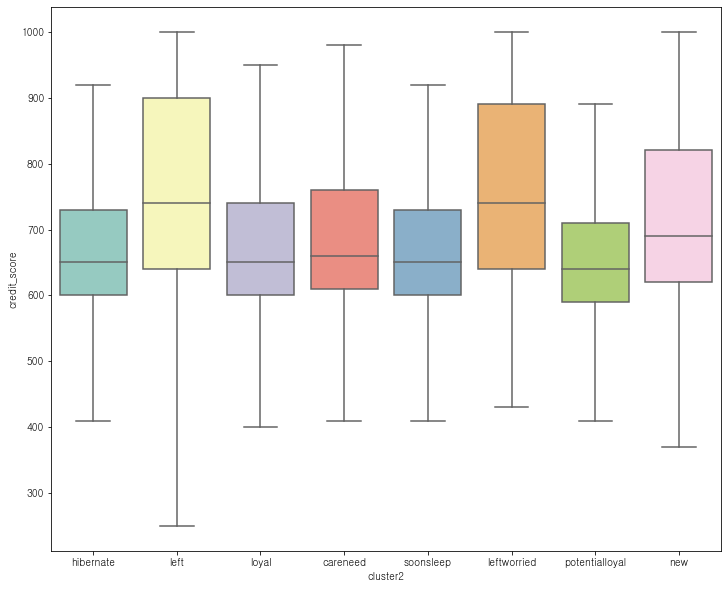

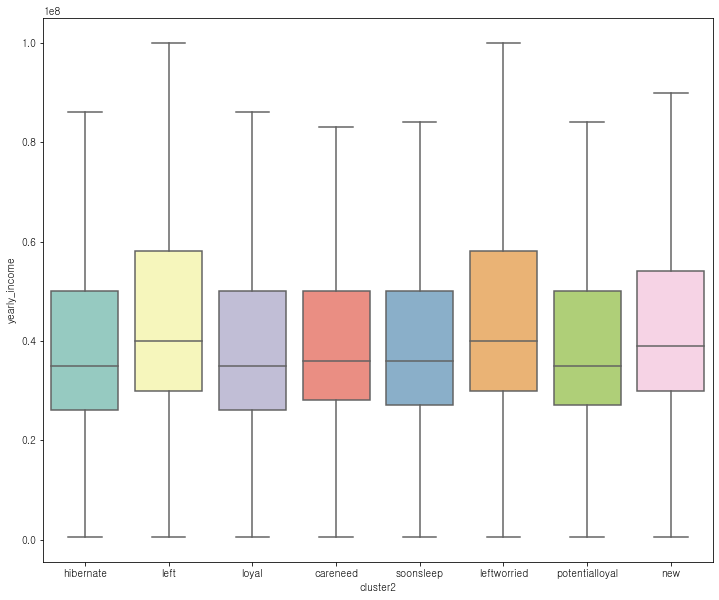

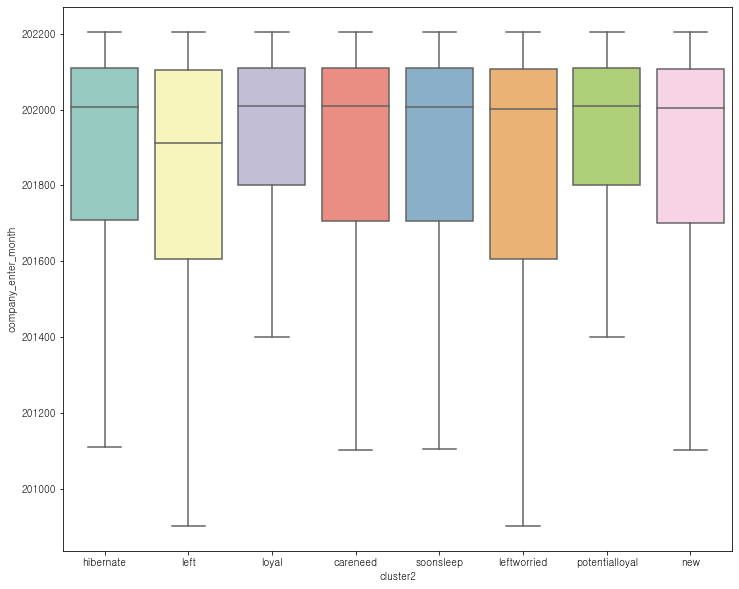

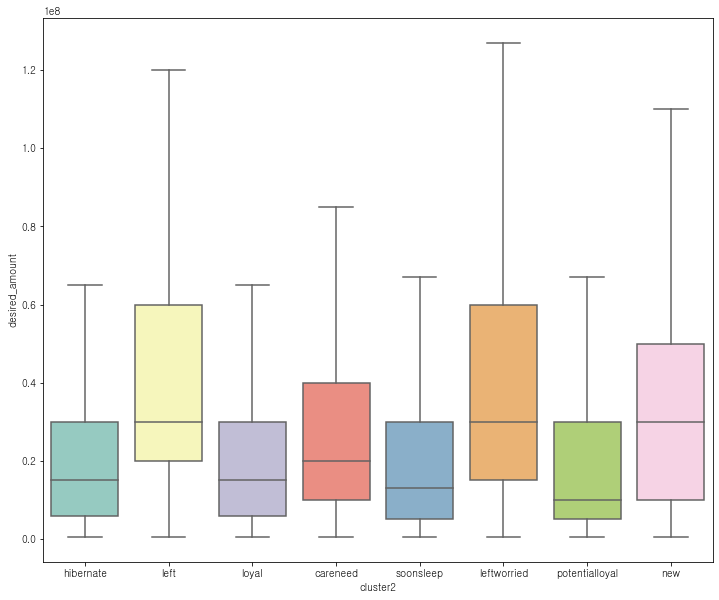

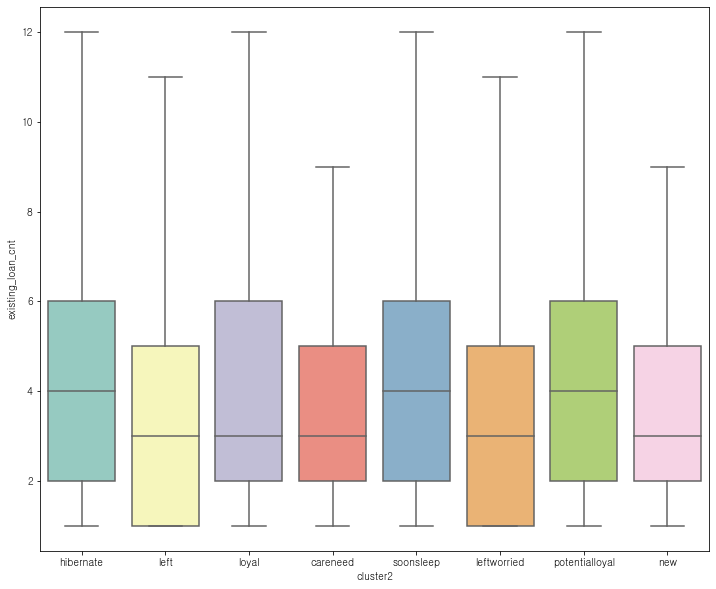

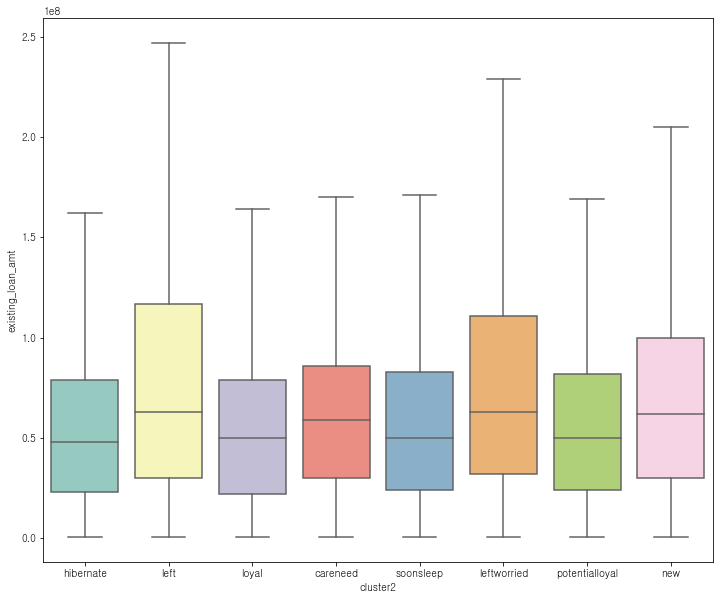

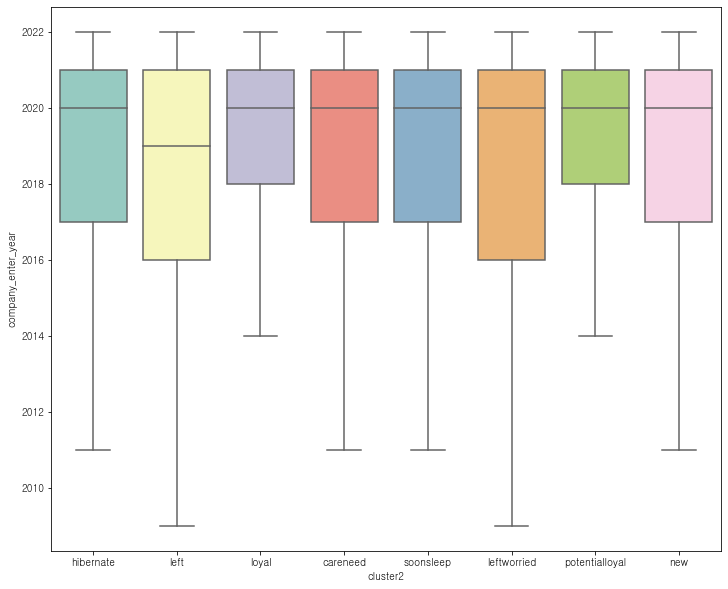

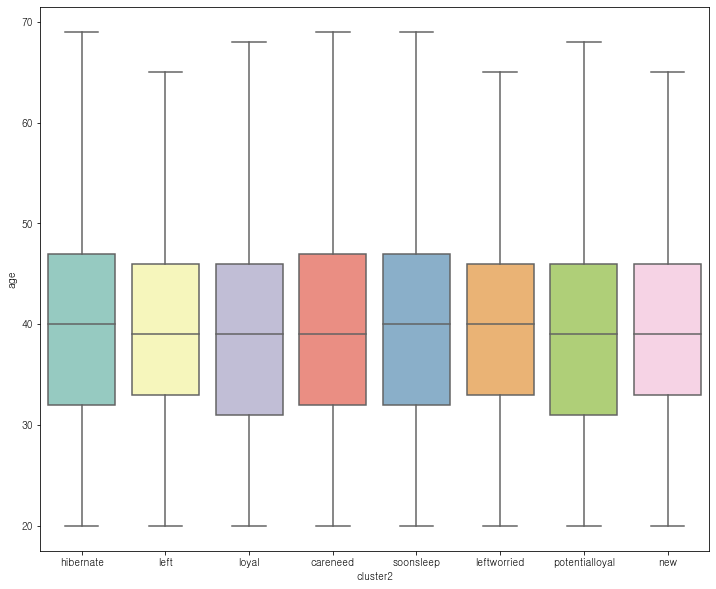

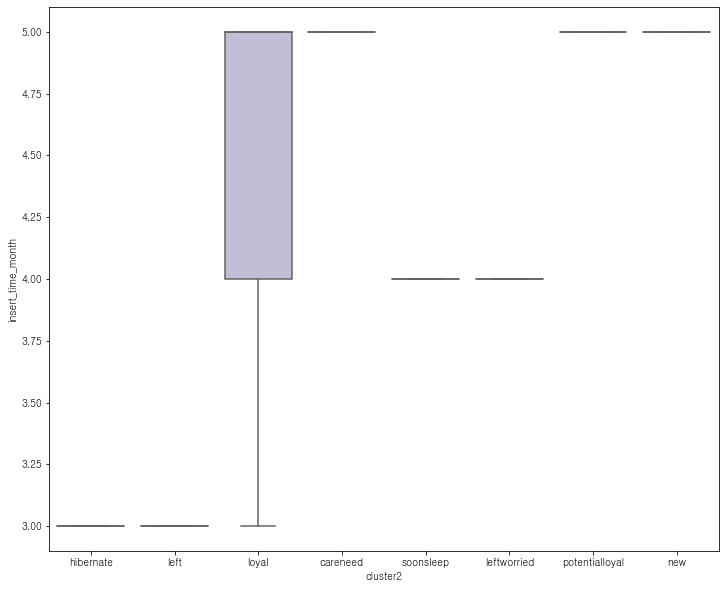

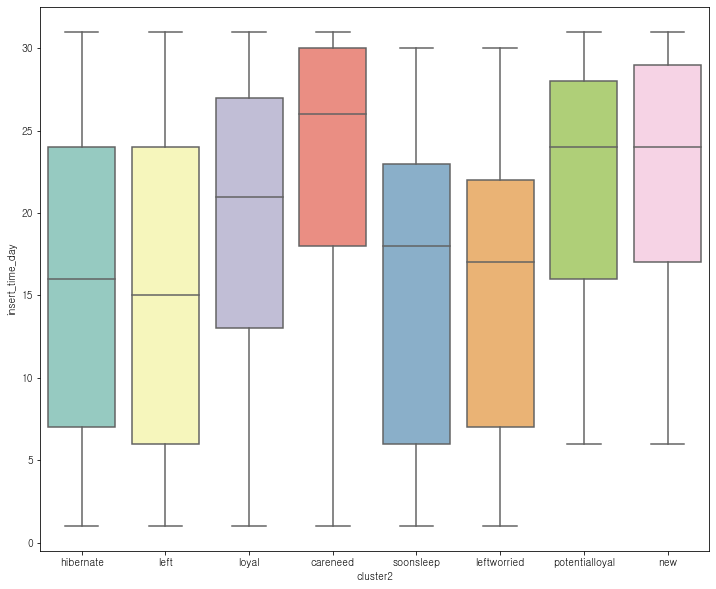

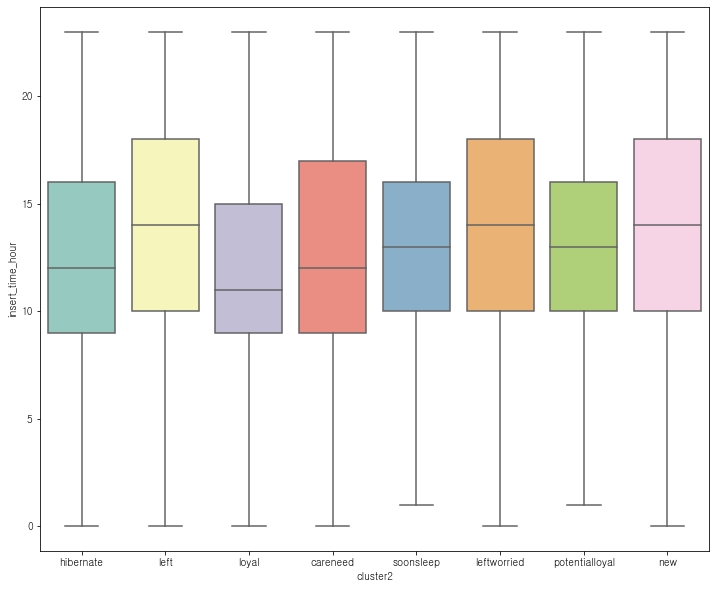

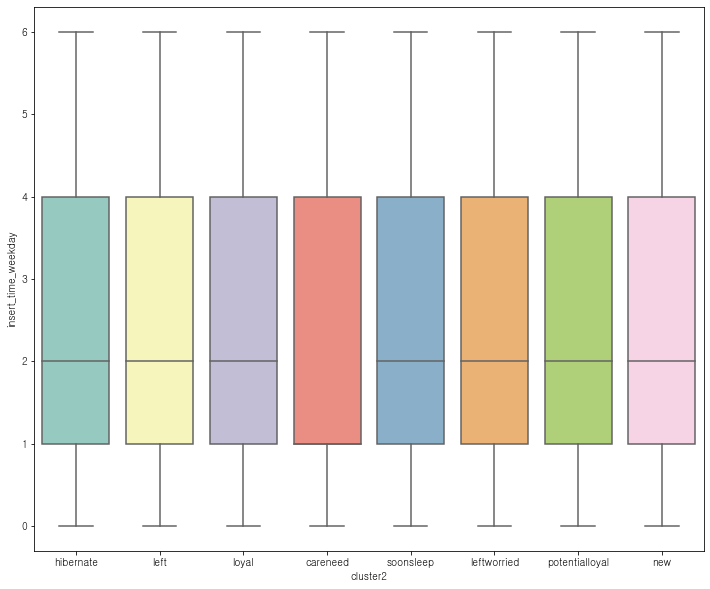

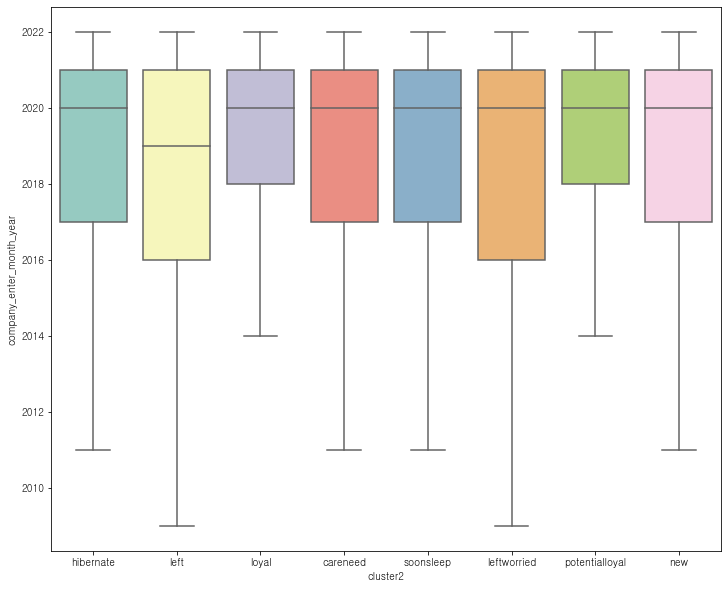

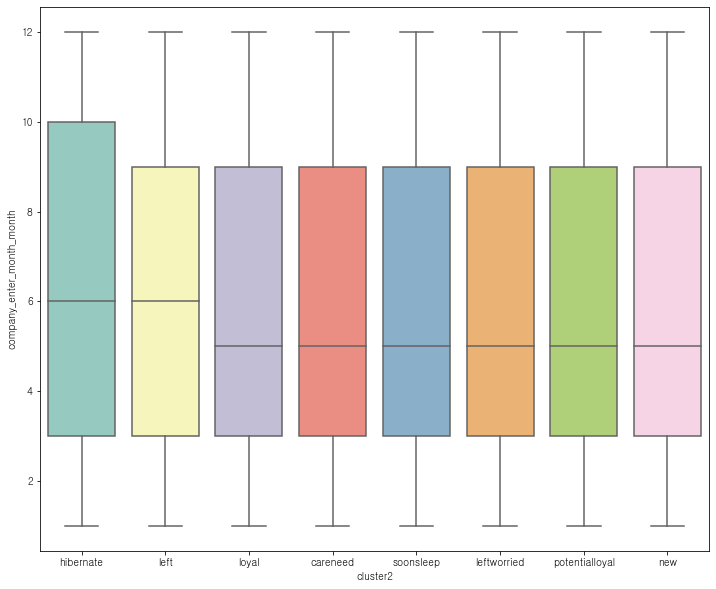

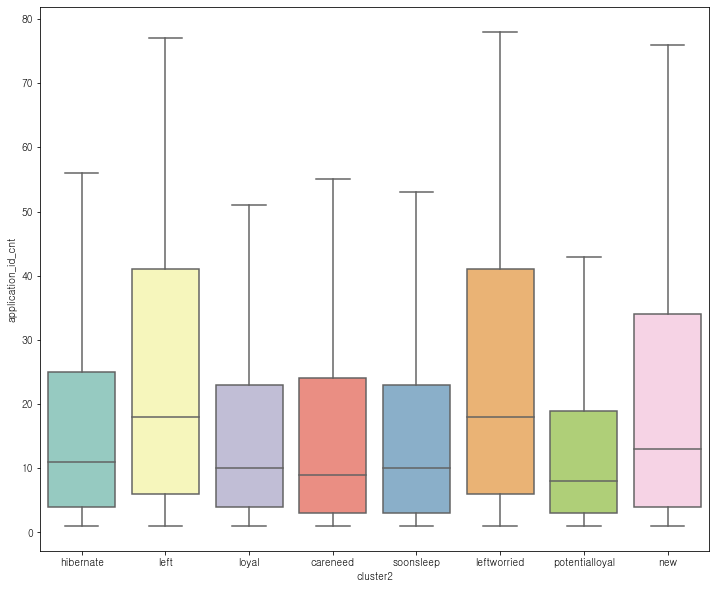

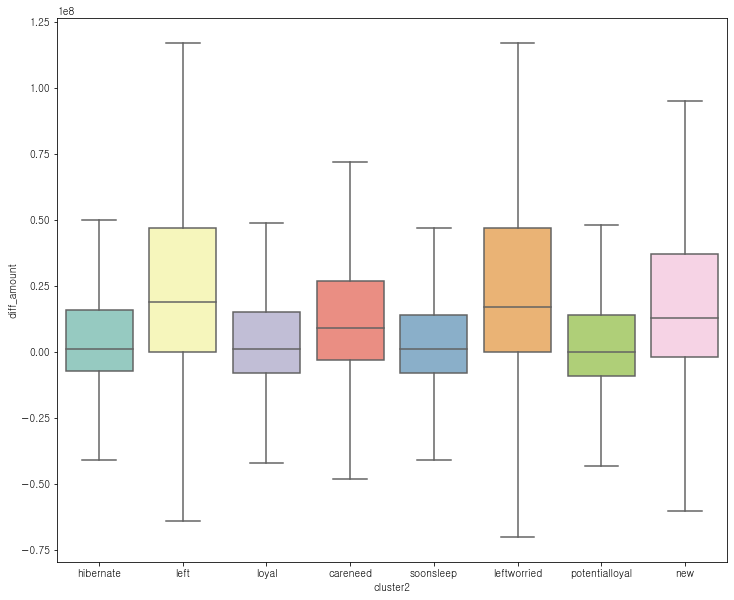

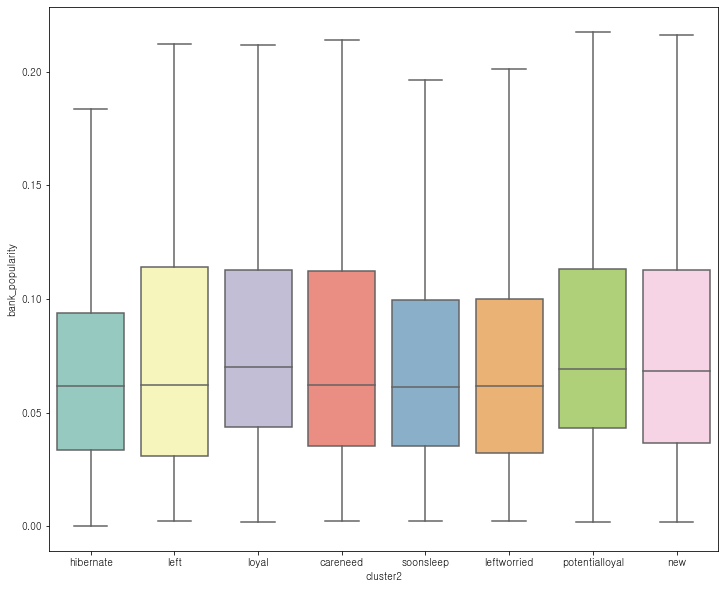

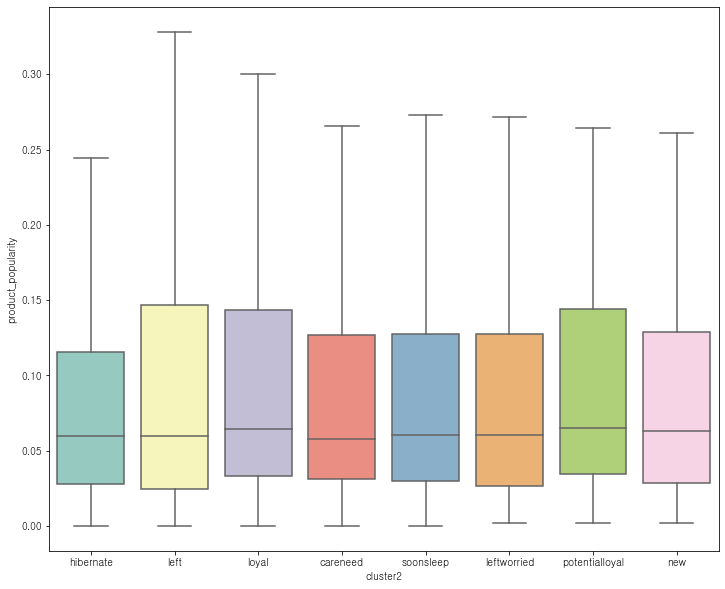

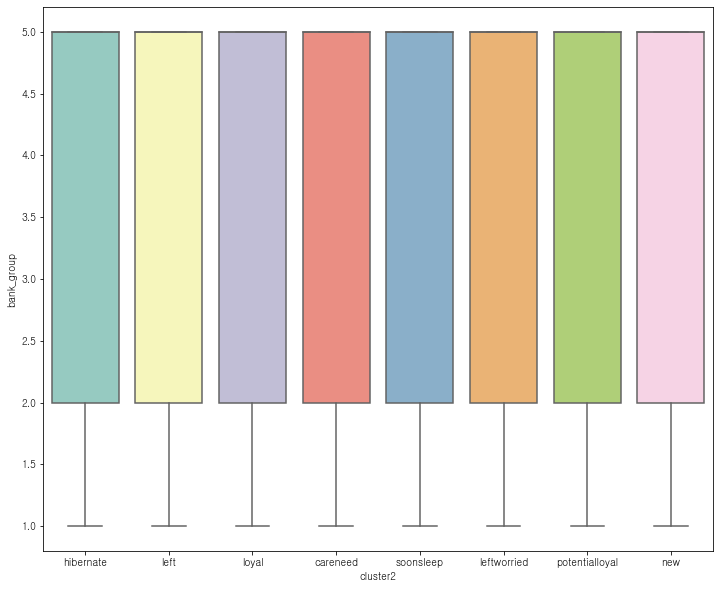

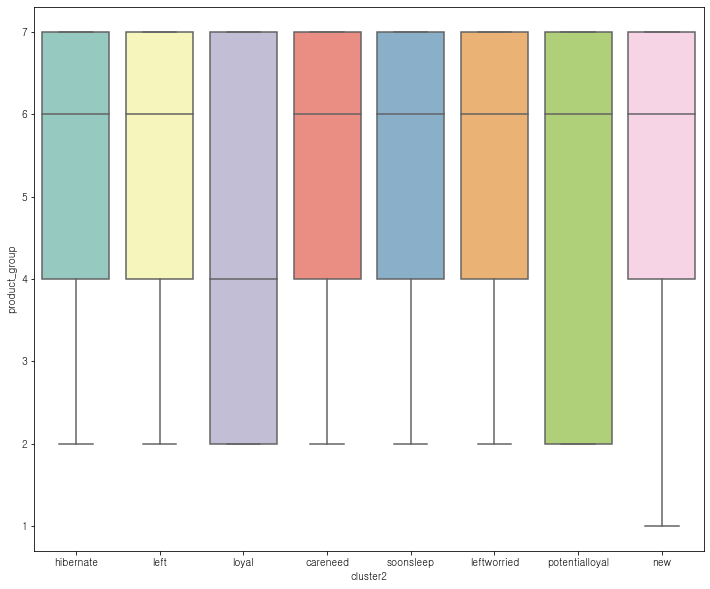

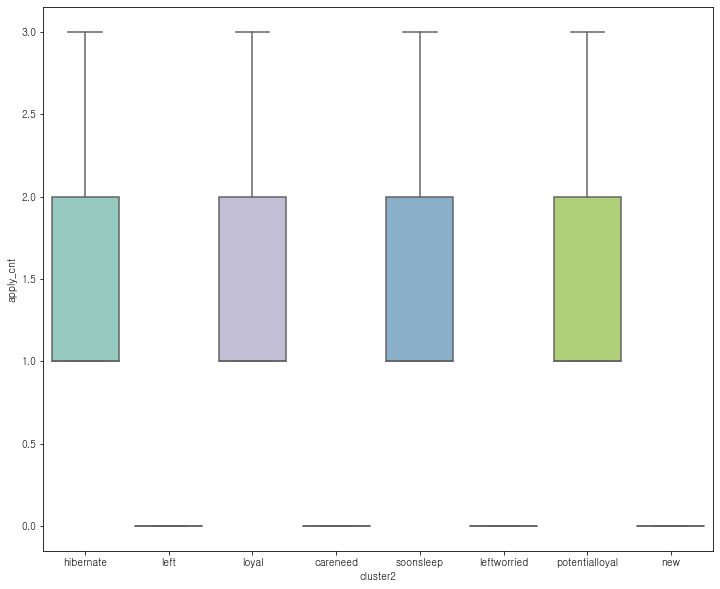

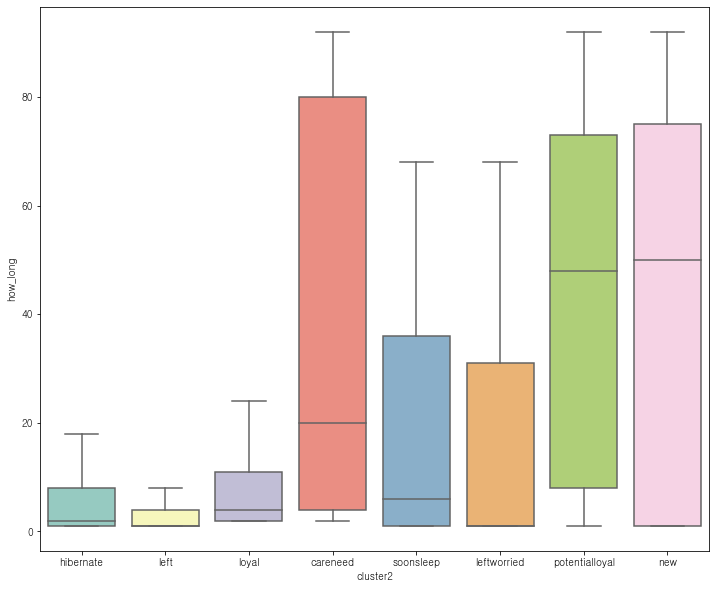

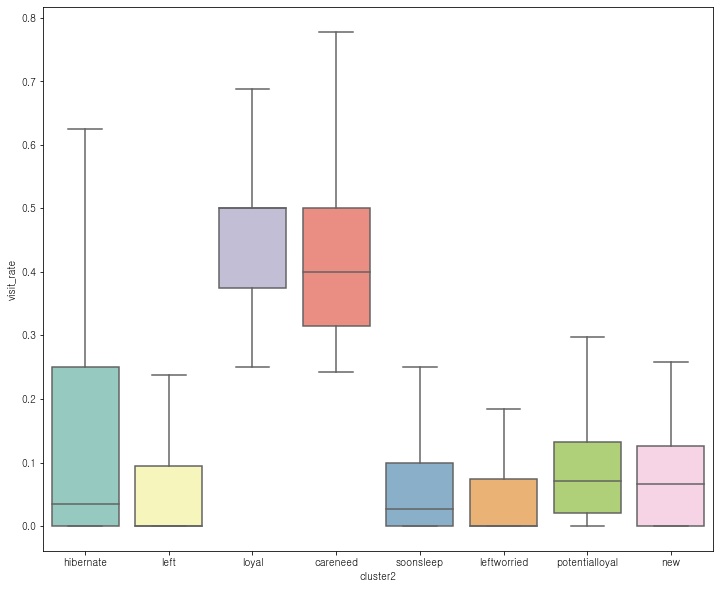

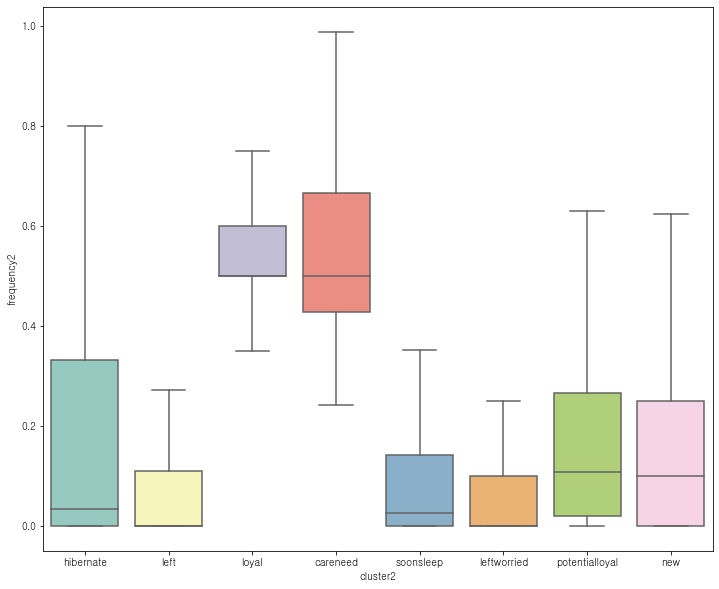

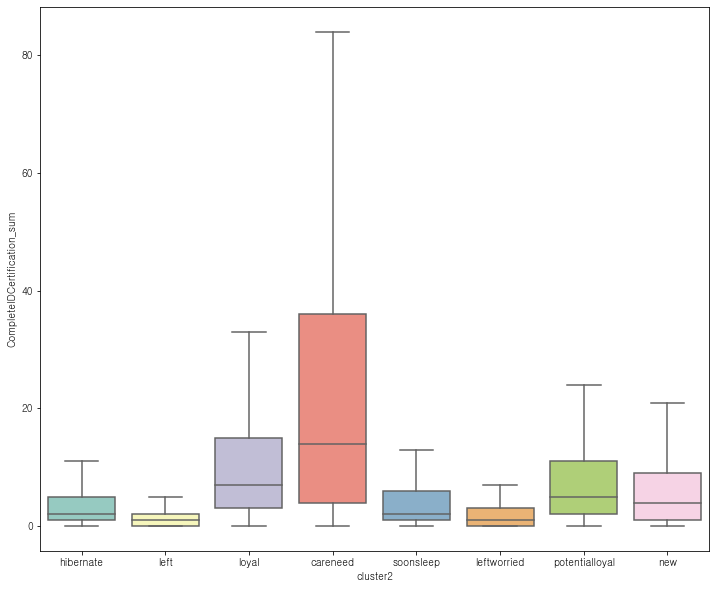

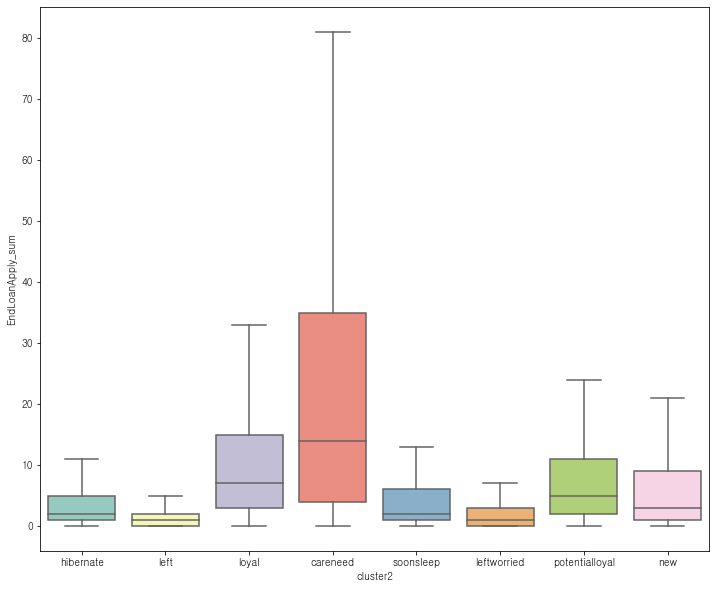

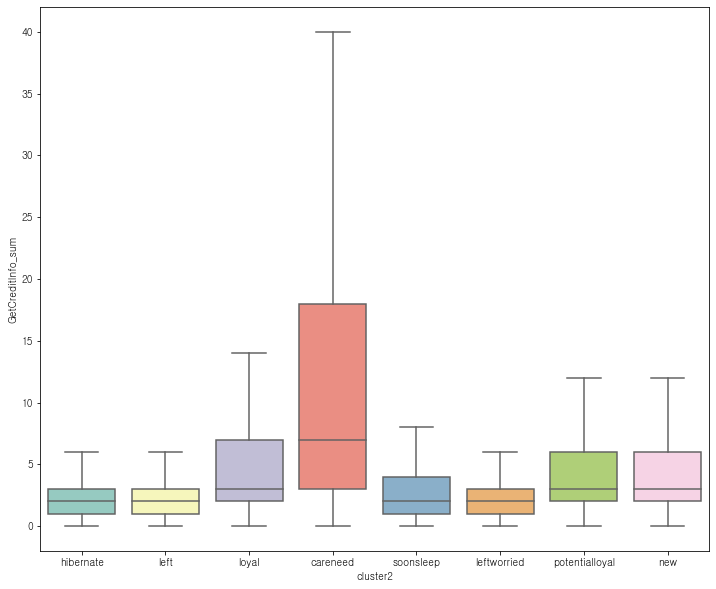

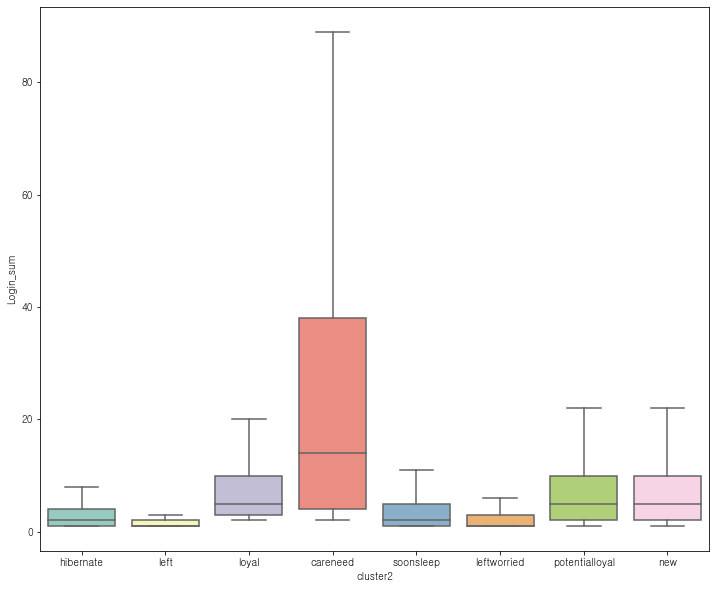

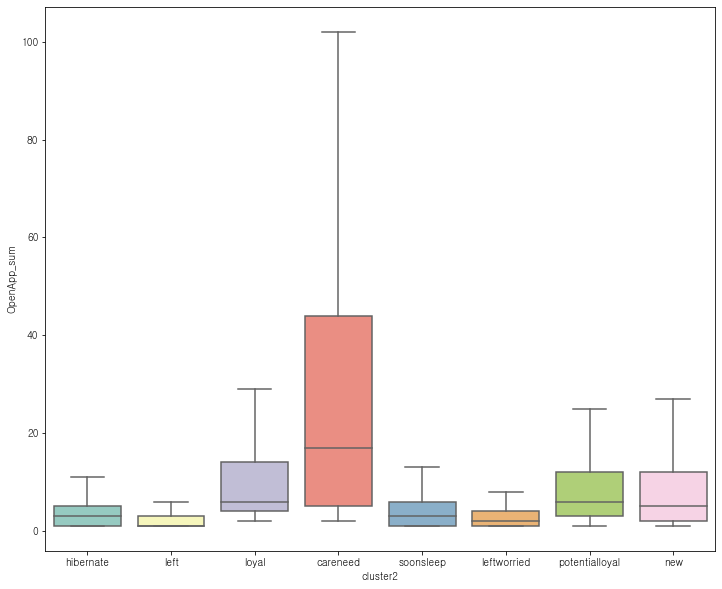

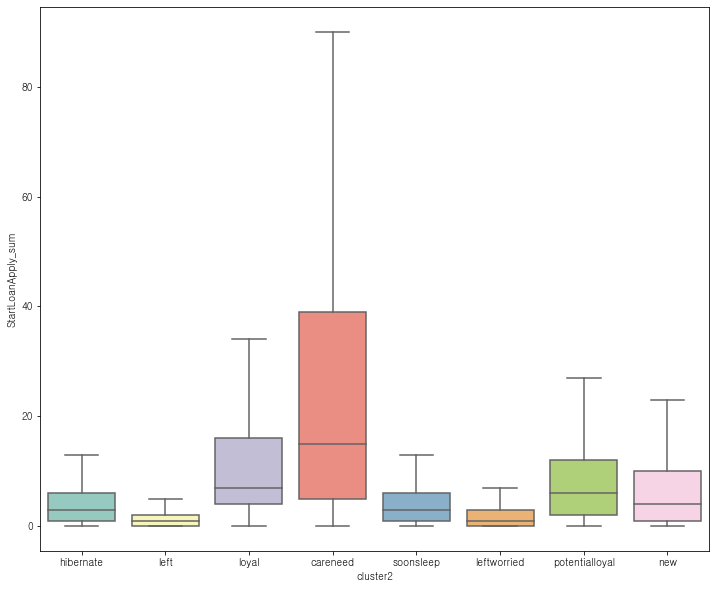

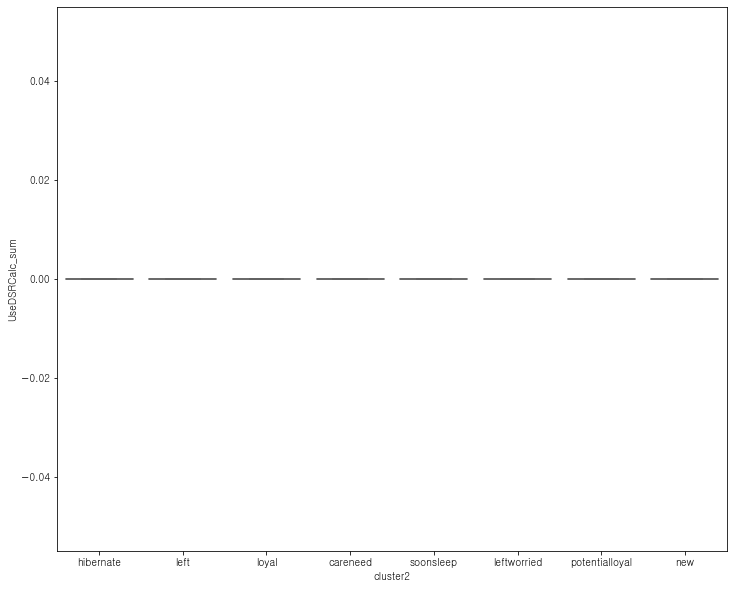

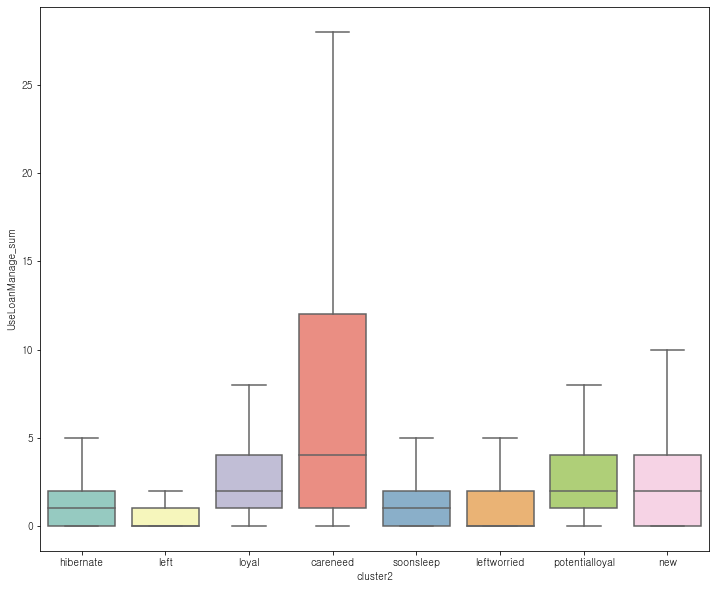

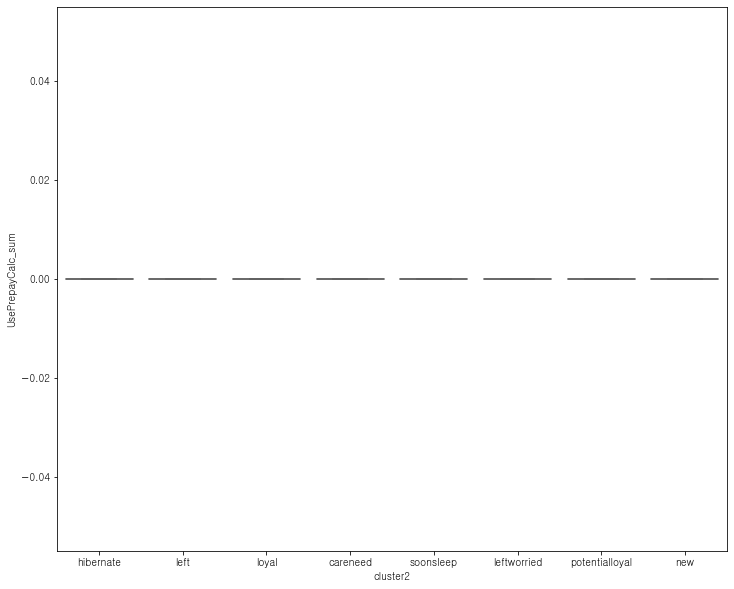

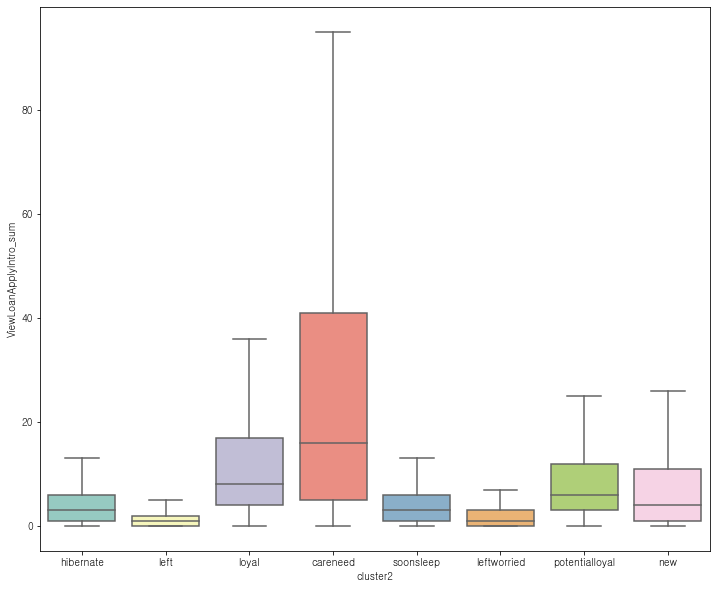

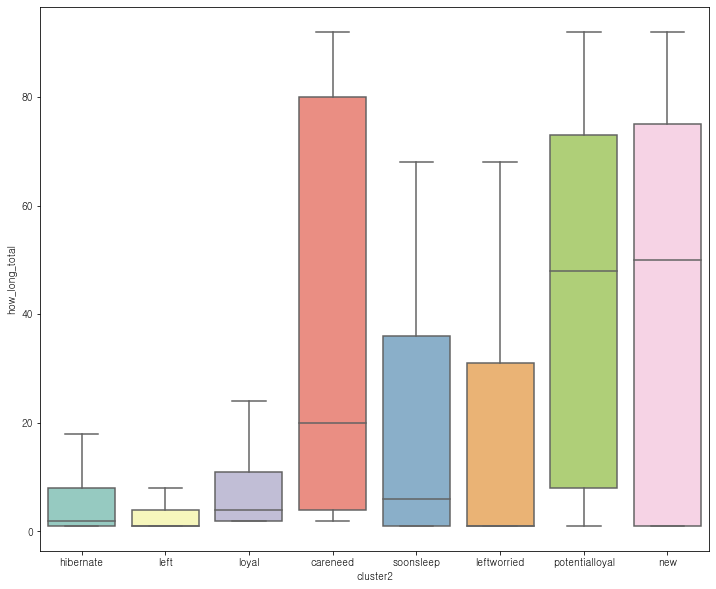

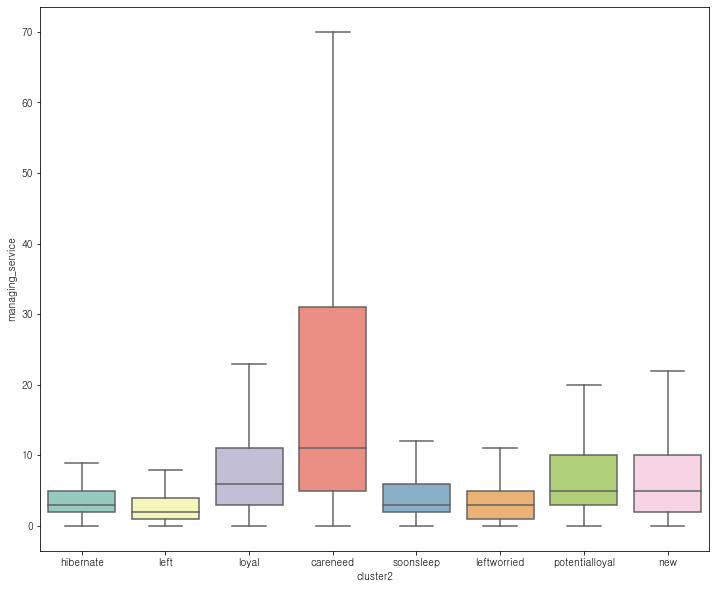

ValueError: Could not interpret input 'frequency'

<Figure size 864x720 with 0 Axes>

In [16]:
for col in num_cols:
    qualitative_colors = sns.color_palette("Set3", 16)
    sns.set_palette(qualitative_colors)
    plt.figure(figsize=(12,10))
    sns.boxplot(data=unique_user, y=col, x='cluster2',showfliers=False)
    plt.show();
    

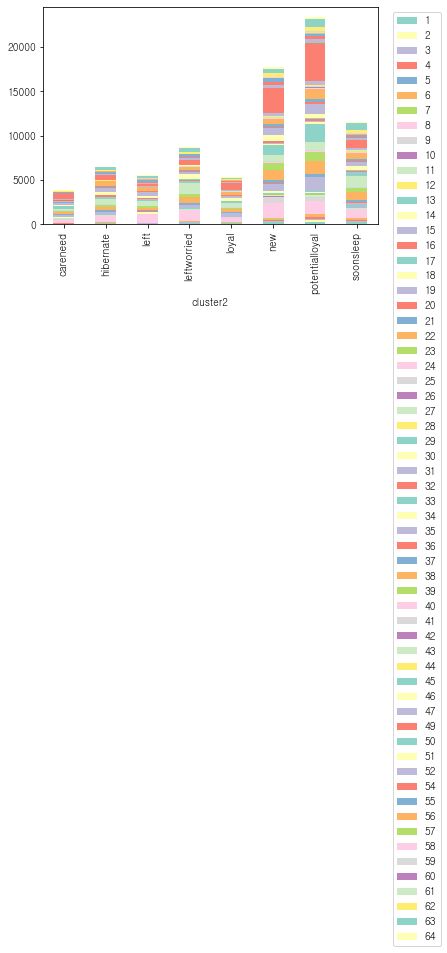

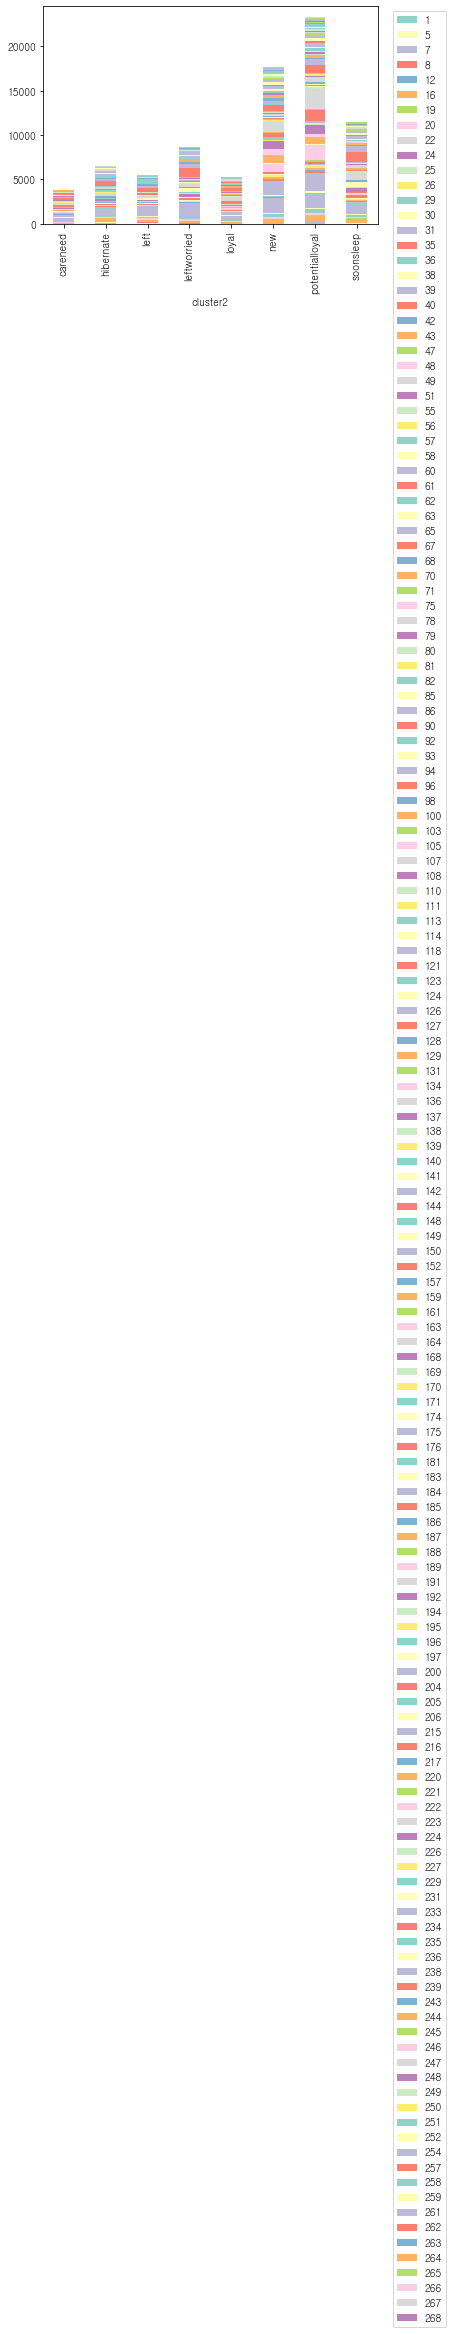

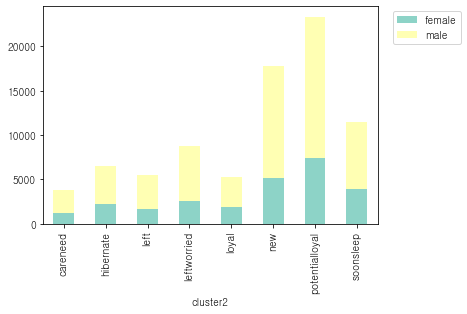

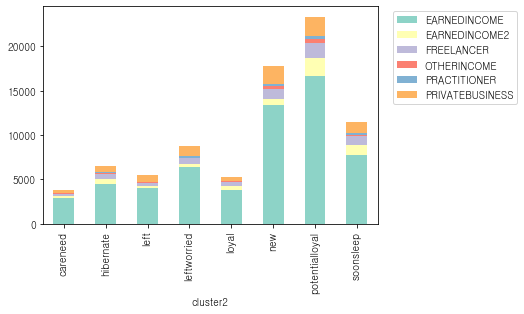

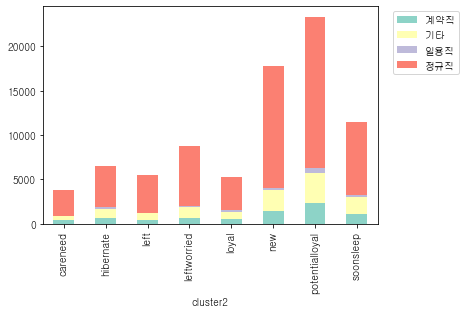

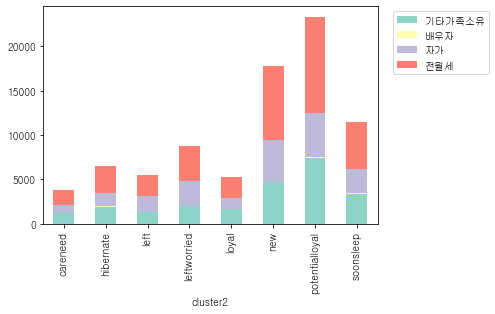

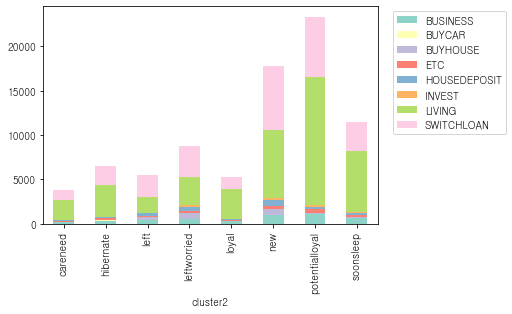

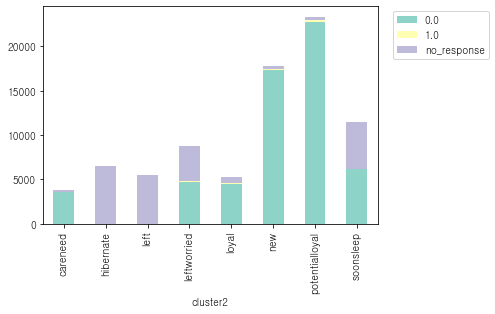

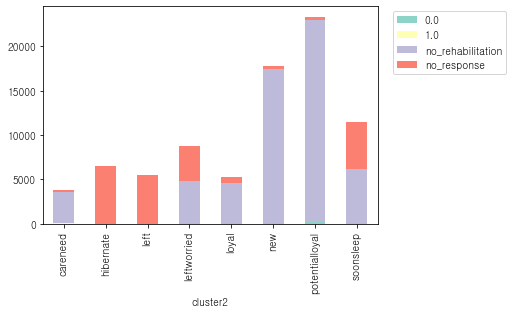

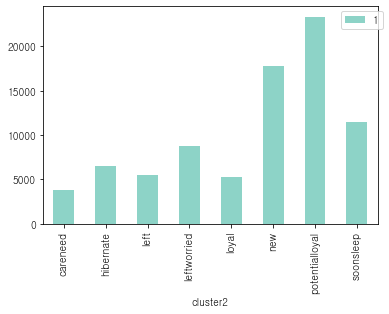

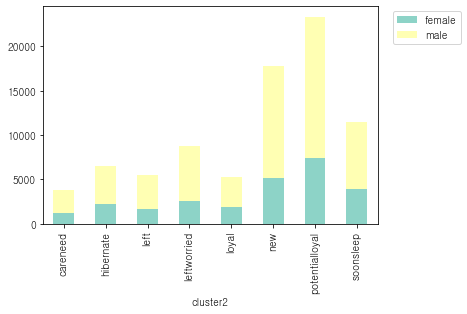

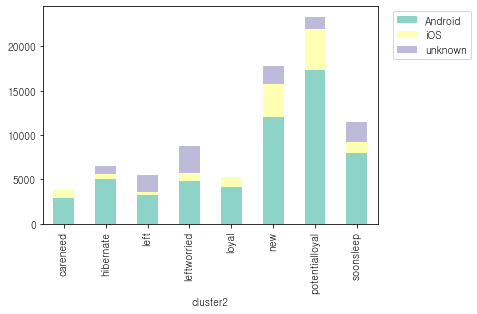

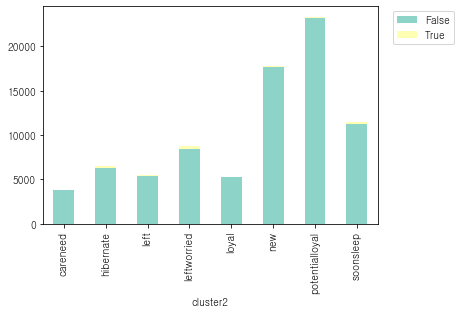

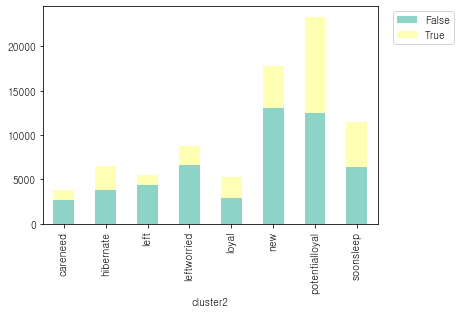

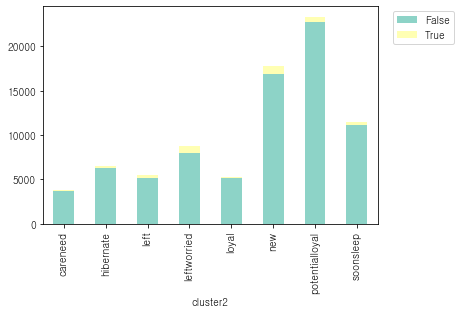

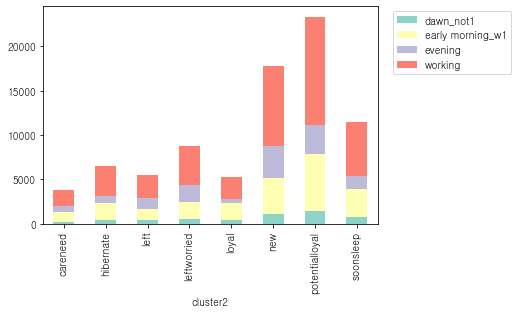

In [143]:
horiz_offset = 1.03
vert_offset = 1.

for col in cat_cols:
  df_plot = unique_user.groupby([col,'cluster2']).size().reset_index().pivot(columns =col, index='cluster2', values=0)
  ax=df_plot.plot(kind ='bar', stacked=True)
  ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))